In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import awkward as ak
import uproot
import hist
import numpy as np
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.processor import dict_accumulator, list_accumulator

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5
import itertools
import json

# for making fancy 2d histograms
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from utils import (plot_1d_trigger_efficiencies, 
                plot_1d_trigger_efficiencies_improvement, 
                plot_fancy_2d_trigger_efficiencies, 
                compare_trigger_efficiencies, 
                plot_1d_trigger_soup_compact,
                plot_1d_trigger_soup_cms)
from trig_eff_process import (create_baseline_selection_mask_new, 
                            TriggerEfficiencyProcessor, 
                            TriggerEfficiencyImprovementProcessor, 
                            VBFBaselineCutFlowProcessor, 
                            GeneralBaselineCutFlowProcessor,
                            TriggerSoupProcessor,
                            TriggerSoupProcessor_individual,
                            ParkingSoupProcessor)

In [2]:
trig_vars = {
    'ht': {
        'label': "H_{T} [GeV]",
        'axis': hist.axis.Regular(bins=100, start=0, stop=2000, name="ht", label="H_{T} [GeV]"),
        'proc': lambda events: ak.sum(events.FatJet.pt, axis=1)
    },
    'pt': {
        'label': "Leading Jet $p_{T}$ [GeV]",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1200, name="pt", label="Leading Jet $p_{T}$ [GeV]"),
        'proc': lambda events: ak.fill_none(ak.pad_none(events.FatJet.pt, 1, clip=True)[:, 0], np.nan)
    },
    'msd': {
        'label': "Leading Jet $m_{SD}$ [GeV]",
        'axis': hist.axis.Regular(bins=10, start=40, stop=200, name="msd", label="Leading Jet $m_{SD}$ [GeV]"),
        'proc': lambda events: ak.fill_none(ak.pad_none(events.FatJet.msoftdrop, 1, clip=True)[:, 0], np.nan)
    },
    'num_ak4': {
        'label': "Number of AK4 Jets",
        'axis': hist.axis.Integer(0, 20, name="num_ak4", label="Number of AK4 Jets"),
        'proc': lambda events: ak.num(events.Jet)
    },
    'gen_H_pt': {
        'label': "Gen Higgs pT [GeV]",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1200, name="gen_H_pt", label="Gen Higgs pT [GeV]"),
        'proc': lambda events: events.HTXS.Higgs_pt
    },
    'particleNet_XbbVsQCD':{
        'label': "Leading Particle Net TXbb score",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1, name="particleNet_XbbVsQCD", label="Leading Particle Net TXbb score"),
        'proc': lambda events: ak.fill_none(
            ak.pad_none(events.FatJet.particleNet_XbbVsQCD, 1, clip=True)[:, 0],
            np.nan
        )
    }
}

trig_vars_data = {
    'ht': {
        'label': "H_{T} [GeV]",
        'axis': hist.axis.Regular(bins=100, start=0, stop=2000, name="ht", label="H_{T} [GeV]"),
        'proc': lambda events: ak.sum(events.FatJet.pt, axis=1)
    },
    'pt': {
        'label': "Leading Jet $p_{T}$ [GeV]",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1200, name="pt", label="Leading Jet $p_{T}$ [GeV]"),
        'proc': lambda events: ak.fill_none(ak.pad_none(events.FatJet.pt, 1, clip=True)[:, 0], np.nan)
    },
    'msd': {
        'label': "Leading Jet $m_{SD}$ [GeV]",
        'axis': hist.axis.Regular(bins=10, start=40, stop=200, name="msd", label="Leading Jet $m_{SD}$ [GeV]"),
        'proc': lambda events: ak.fill_none(ak.pad_none(events.FatJet.msoftdrop, 1, clip=True)[:, 0], np.nan)
    },
    'num_ak4': {
        'label': "Number of AK4 Jets",
        'axis': hist.axis.Integer(0, 20, name="num_ak4", label="Number of AK4 Jets"),
        'proc': lambda events: ak.num(events.Jet)
    },
    'particleNet_XbbVsQCD':{
        'label': "Leading Particle Net TXbb score",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1, name="particleNet_XbbVsQCD", label="Leading Particle Net TXbb score"),
        'proc': lambda events: ak.fill_none(
            ak.pad_none(events.FatJet.particleNet_XbbVsQCD, 1, clip=True)[:, 0],
            np.nan
        )
    }
}  # no Gen Higgs pT


In [3]:
trigger_dict_periods = {
    '2022': [
        'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35',
        'AK8PFJet425_SoftDropMass40',
        'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65'
    ],
    '2022EE': [
        'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35',
        'AK8PFJet425_SoftDropMass40',
        'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65'
    ],
    '2023': [
        'AK8PFJet250_SoftDropMass40_PNetBB0p06',
        'AK8PFJet425_SoftDropMass40',
        'PFHT340_QuadPFJet70_50_40_40_PNet2BTagMean0p70',
        'VBF_DiPFJet125_45_Mjj720_Detajj3p0'
    ],
    '2023BPix': [
        'AK8PFJet250_SoftDropMass40_PNetBB0p06',
        'AK8PFJet425_SoftDropMass40',
        'PFHT340_QuadPFJet70_50_40_40_PNet2BTagMean0p70',
        'VBF_DiPFJet125_45_Mjj720_Detajj3p0'
    ]
}

## MC

Processing period 2023
Currently processing production mode VBF


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


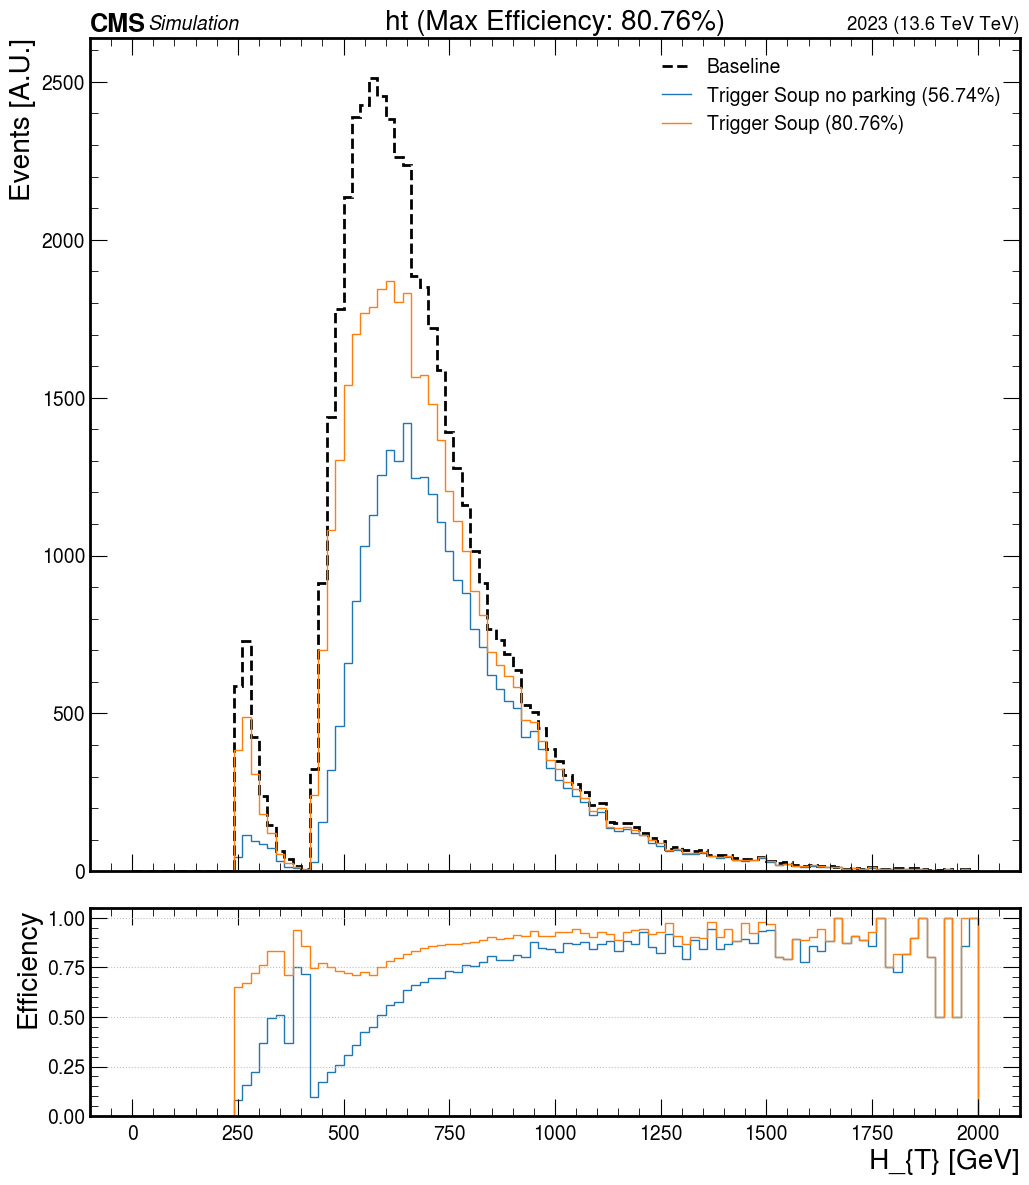

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


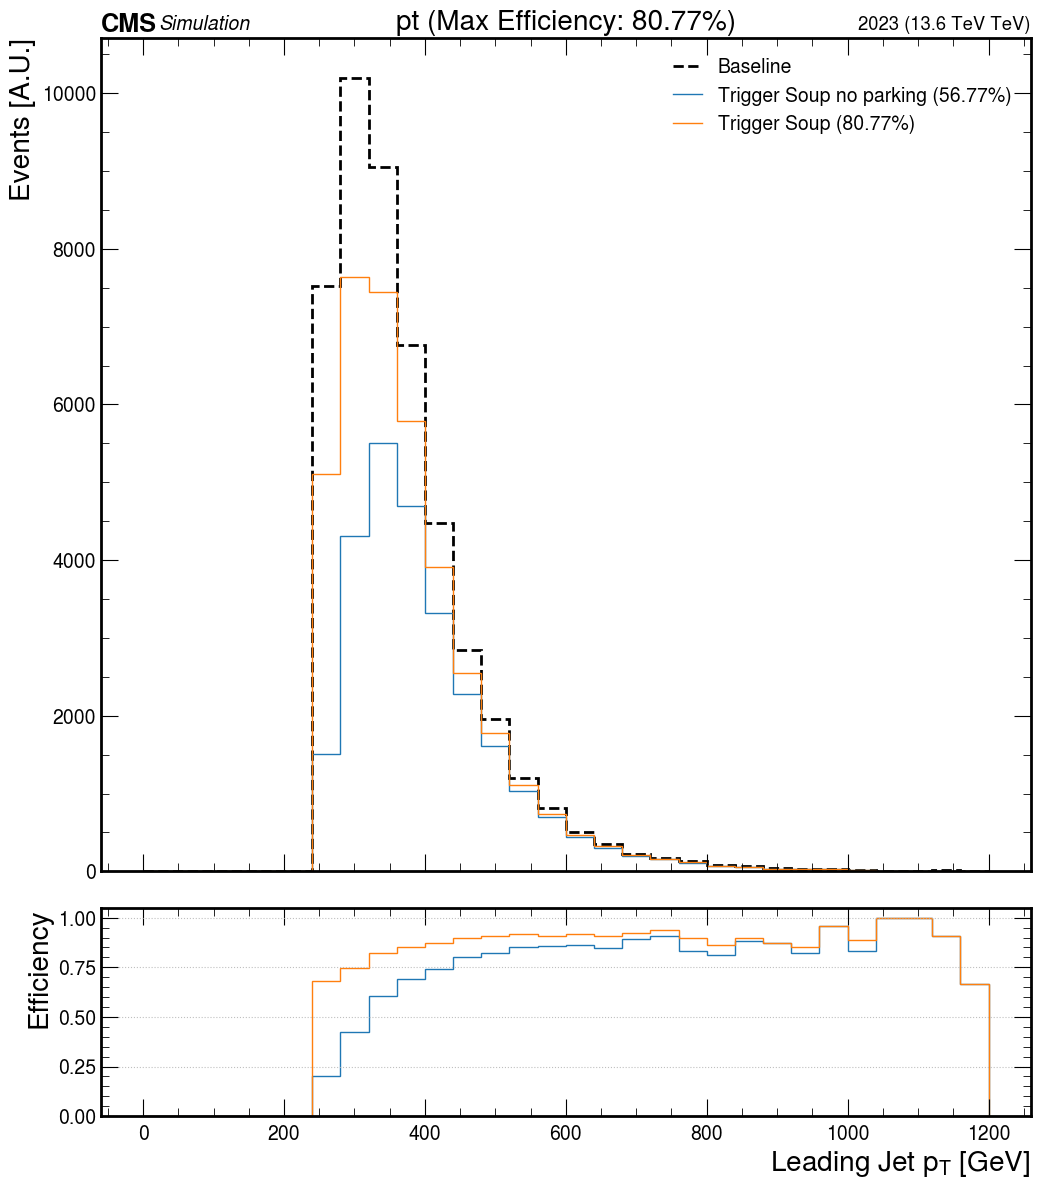

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


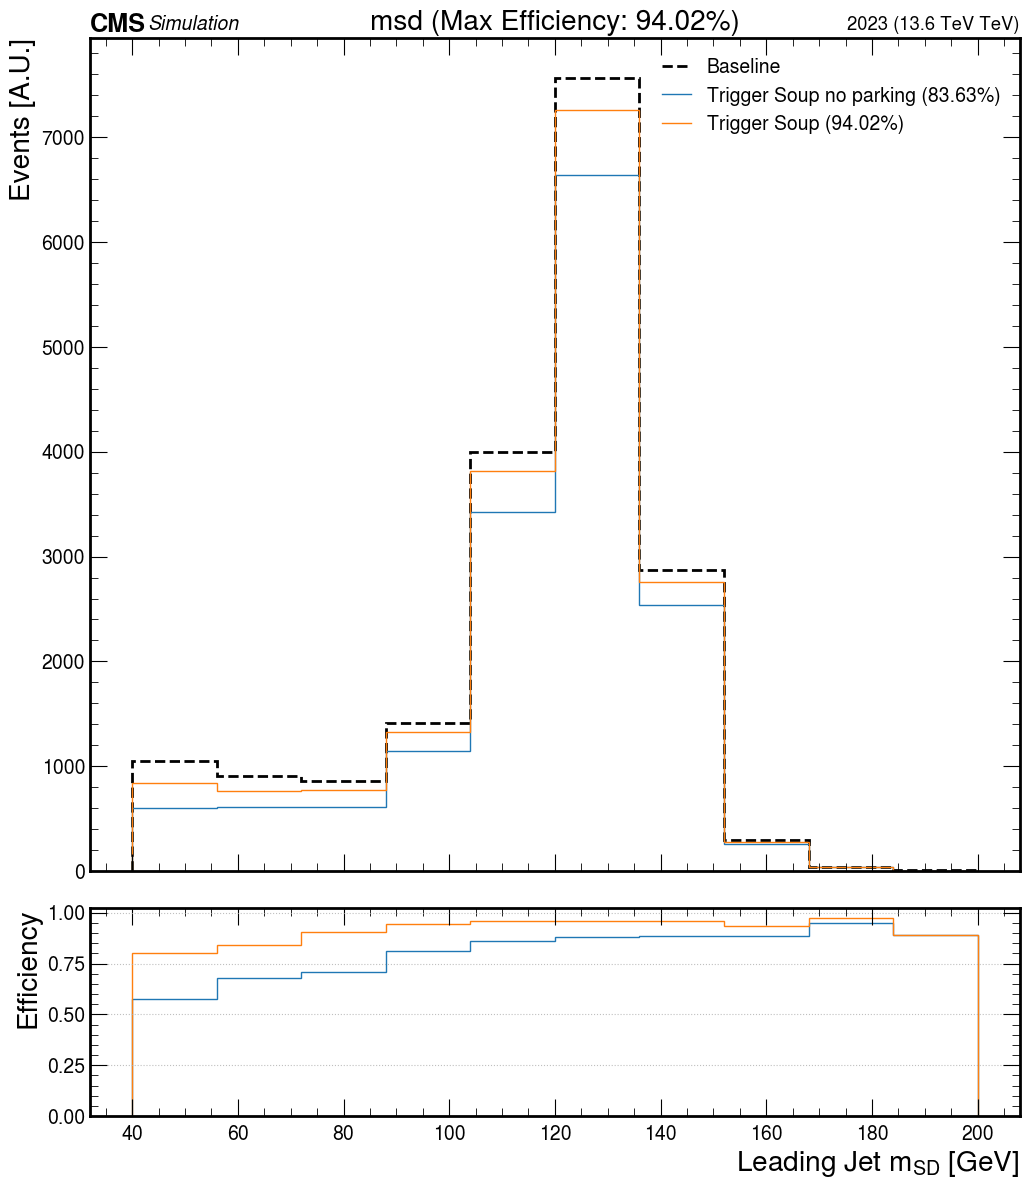

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


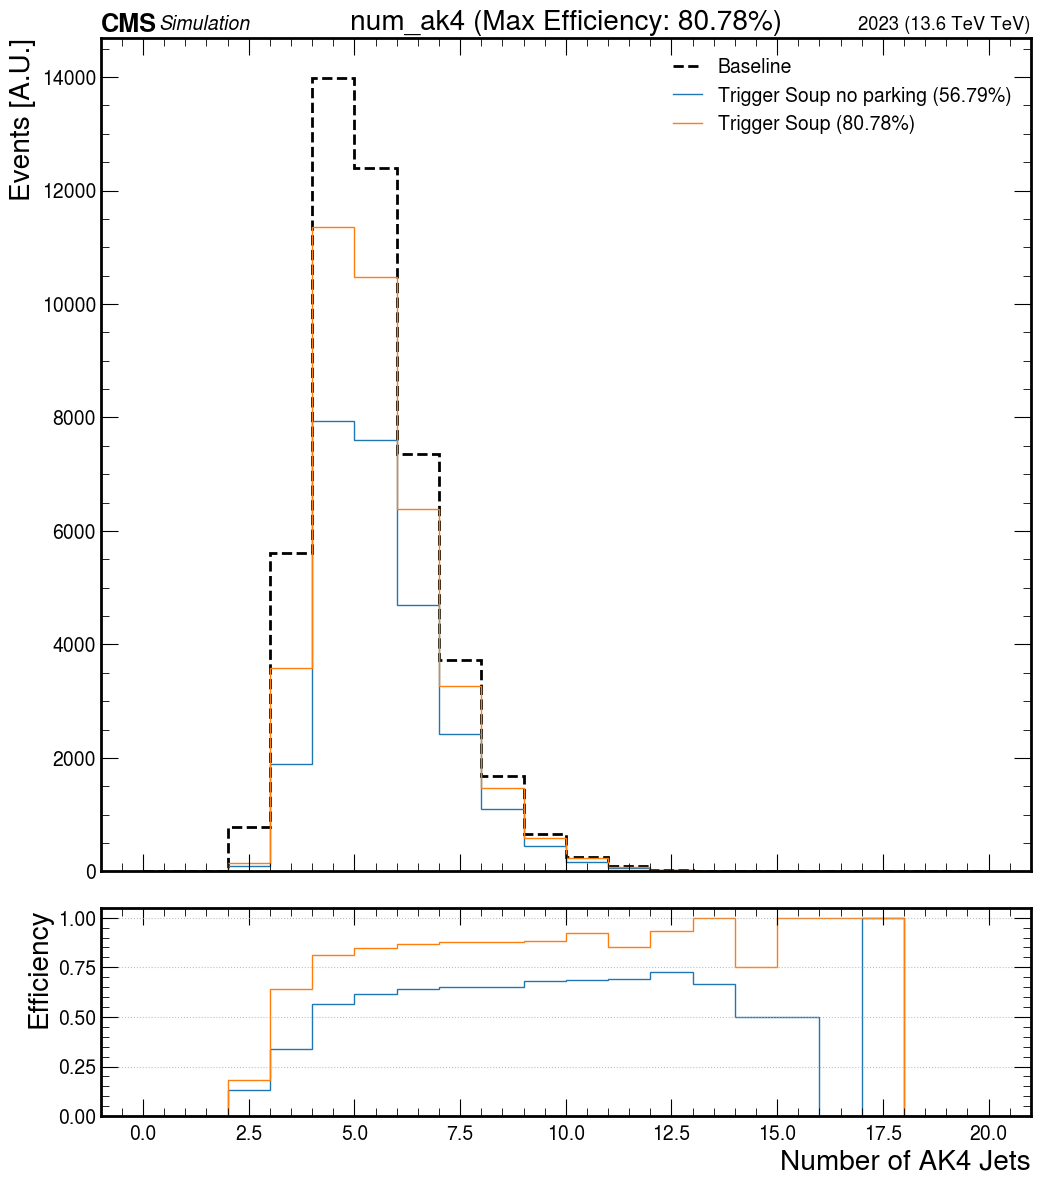

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


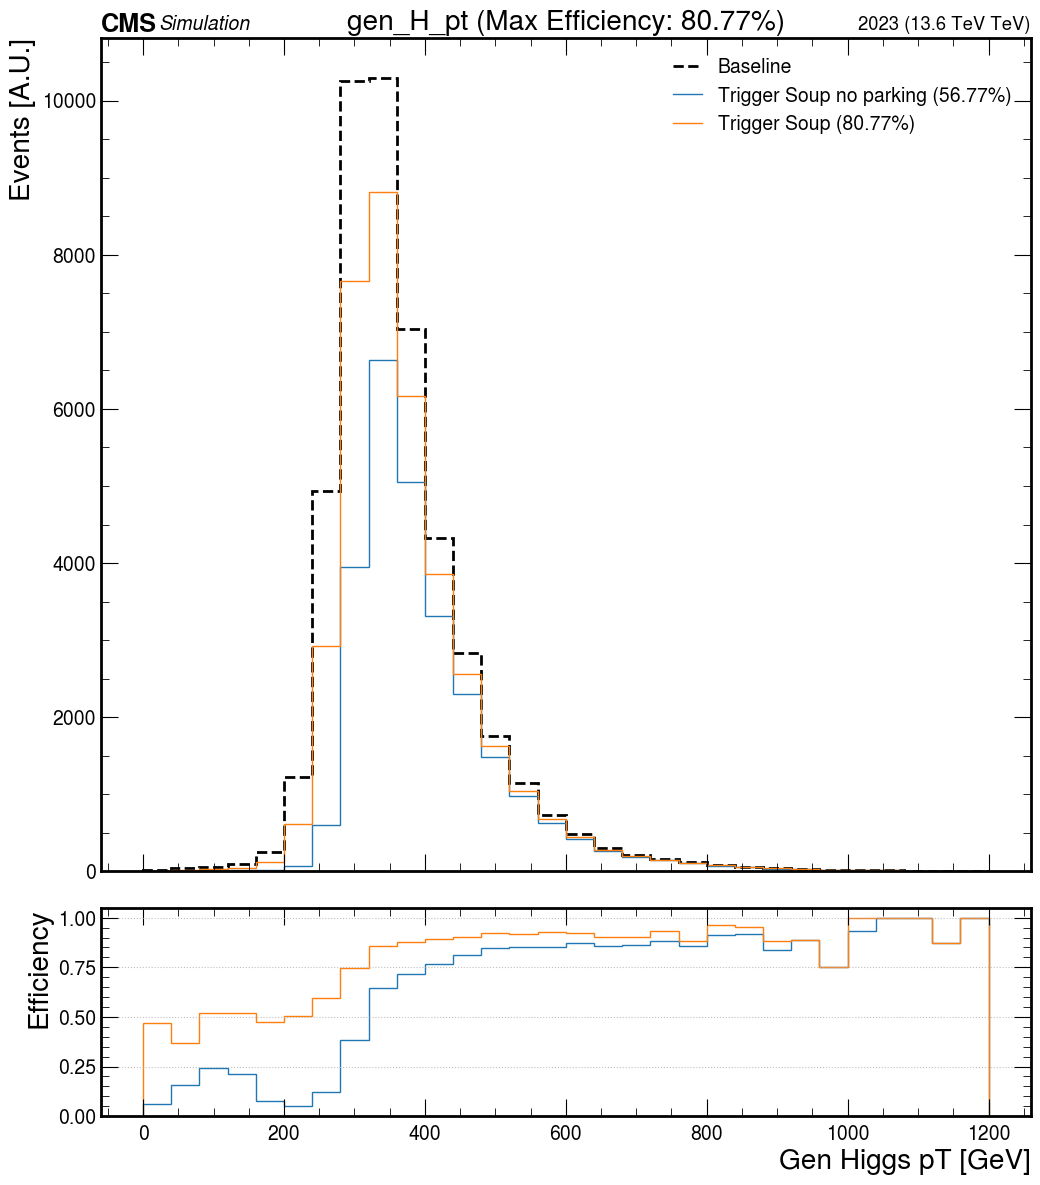

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


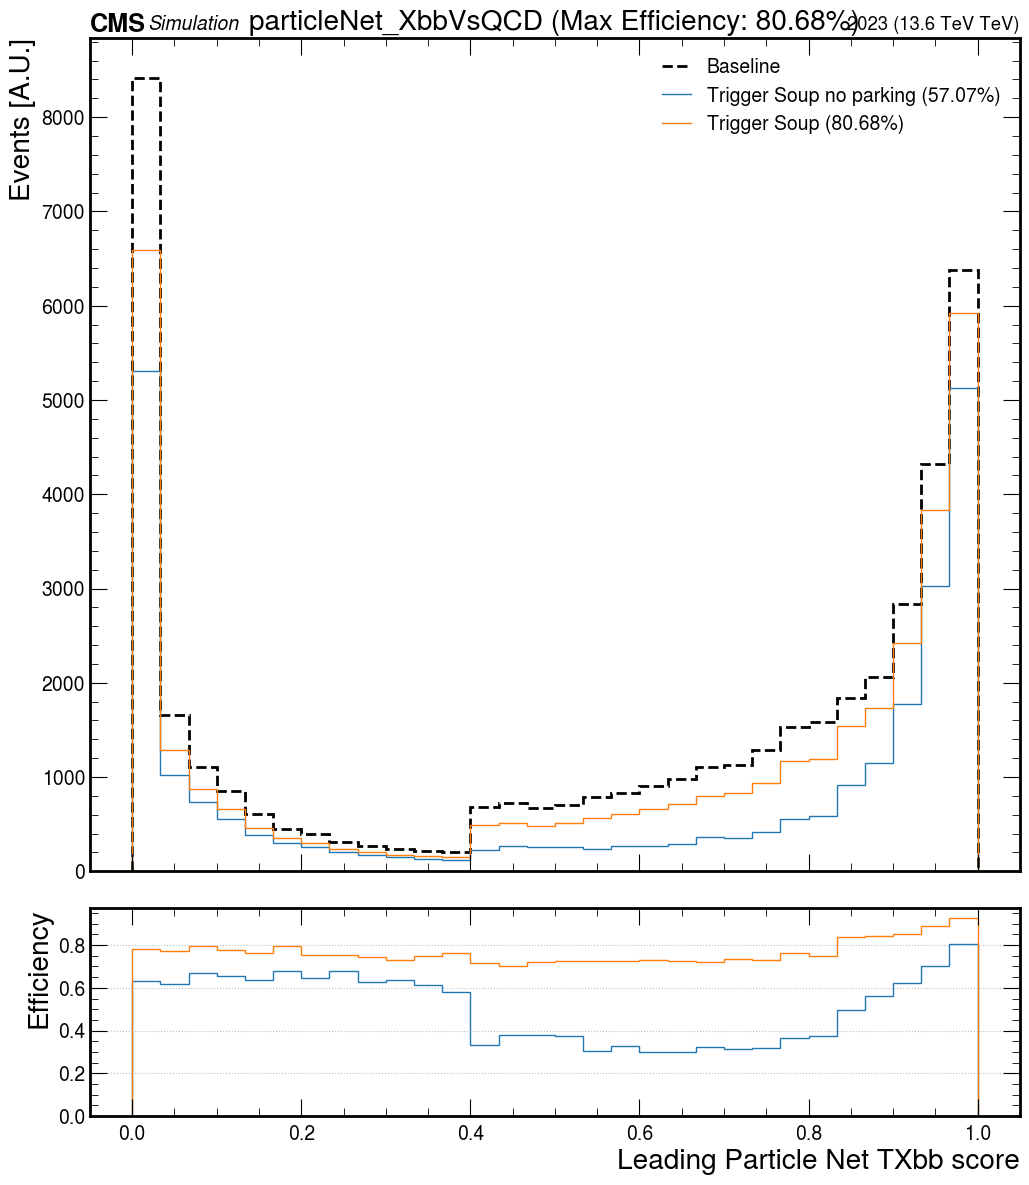

Currently processing production mode ggF


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


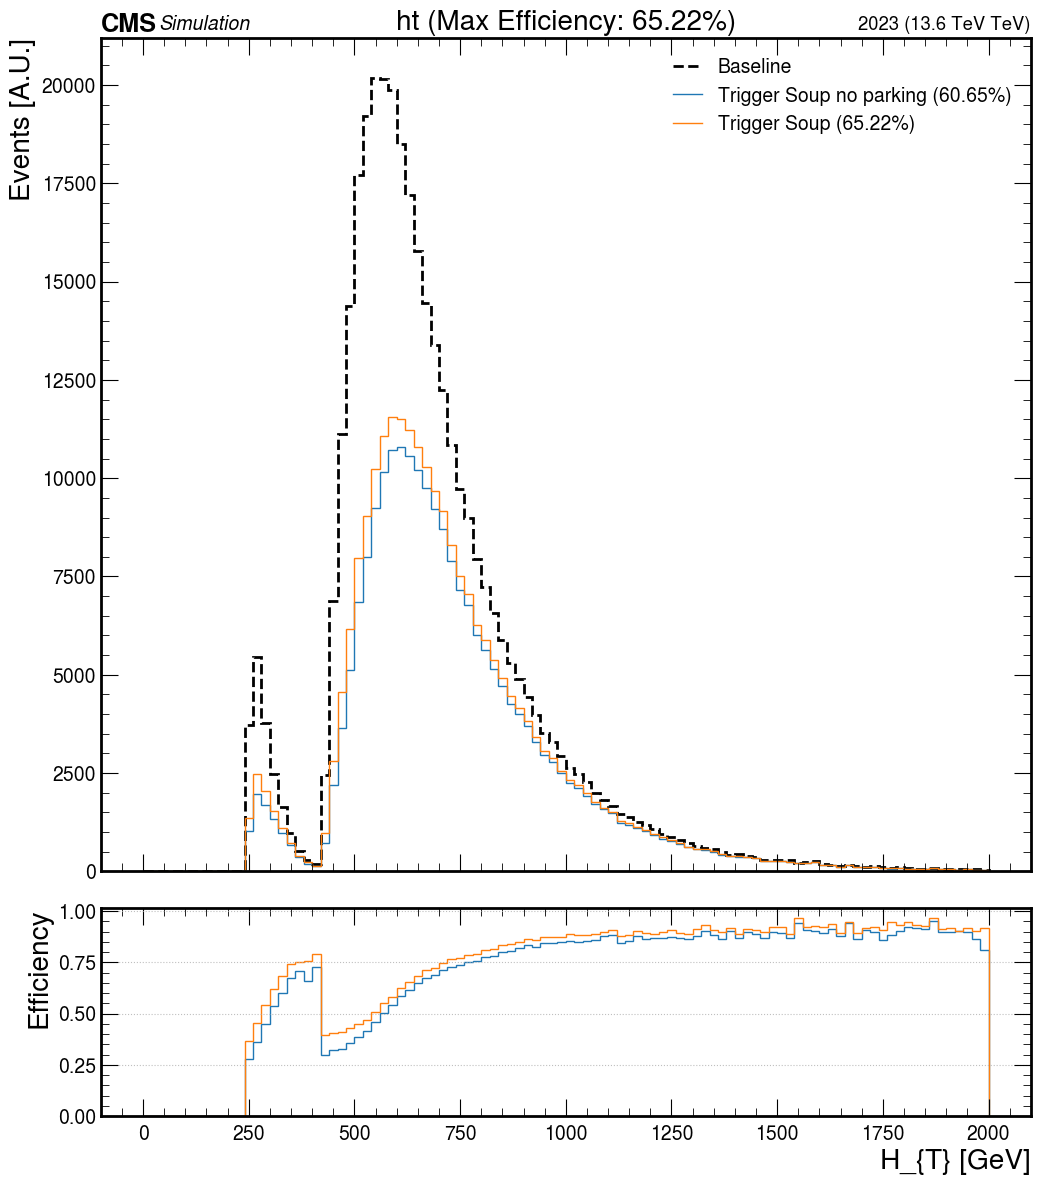

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


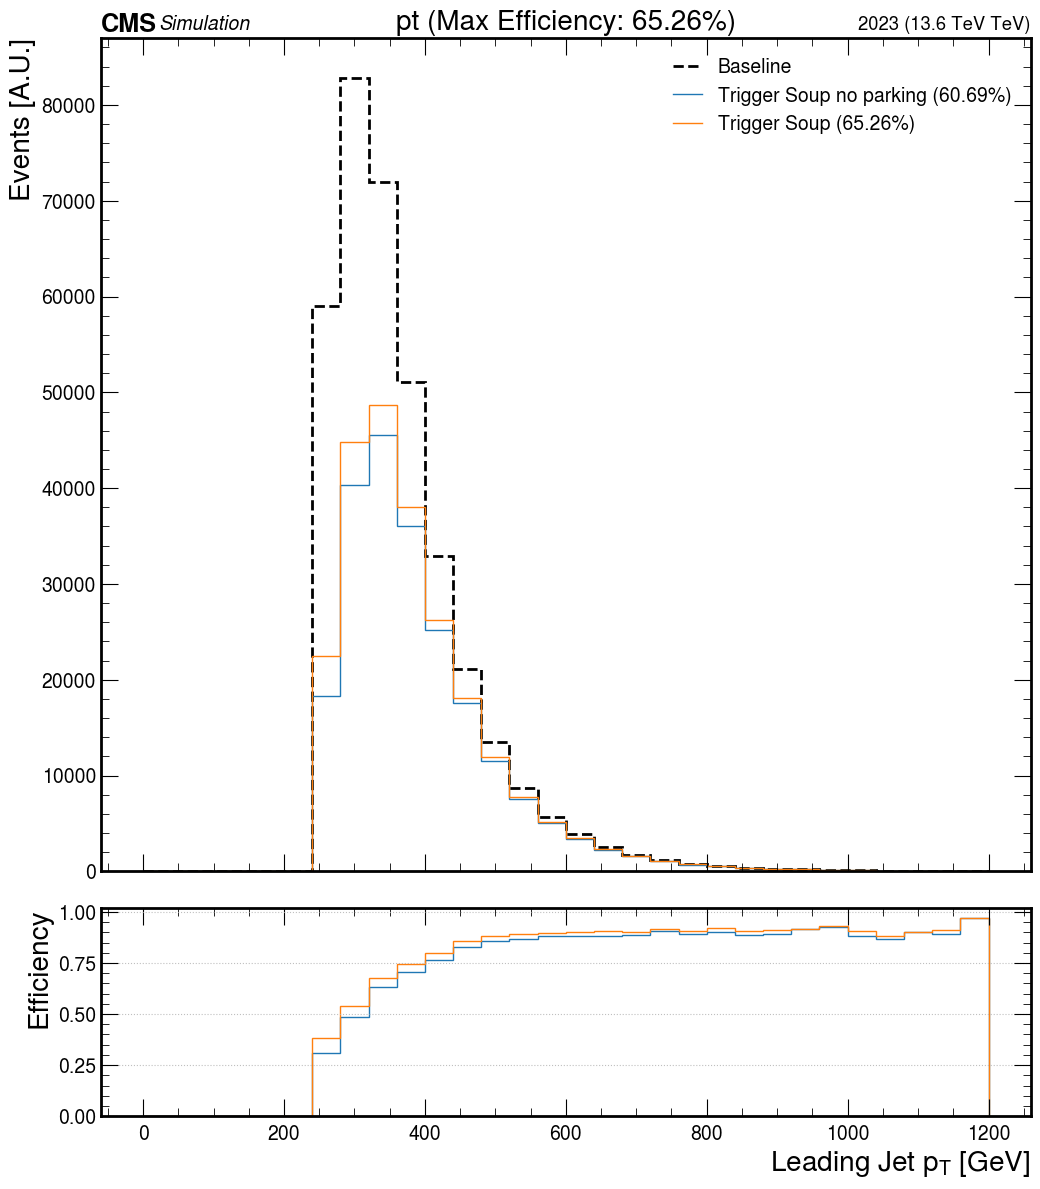

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


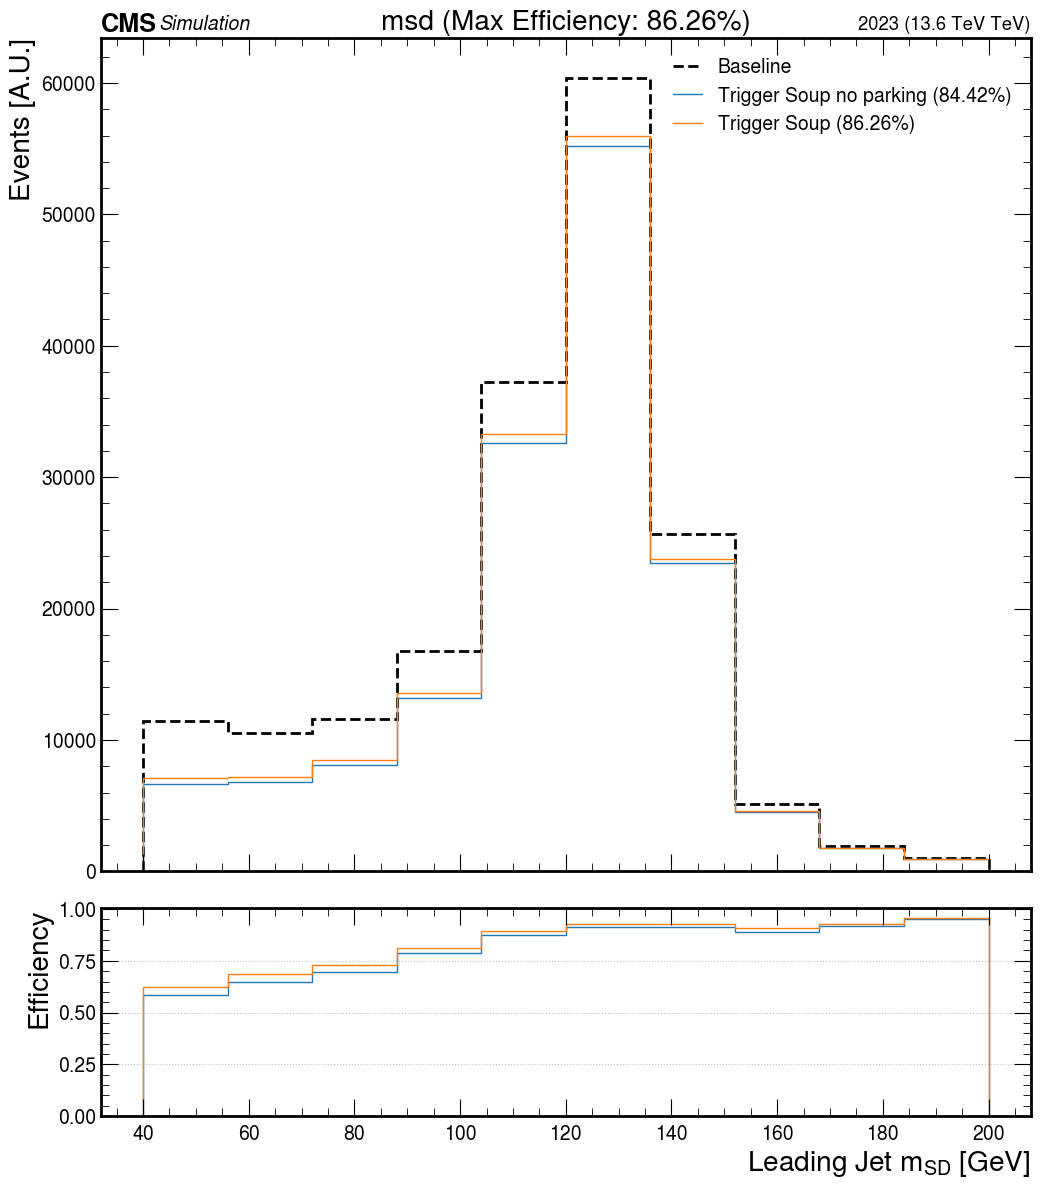

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


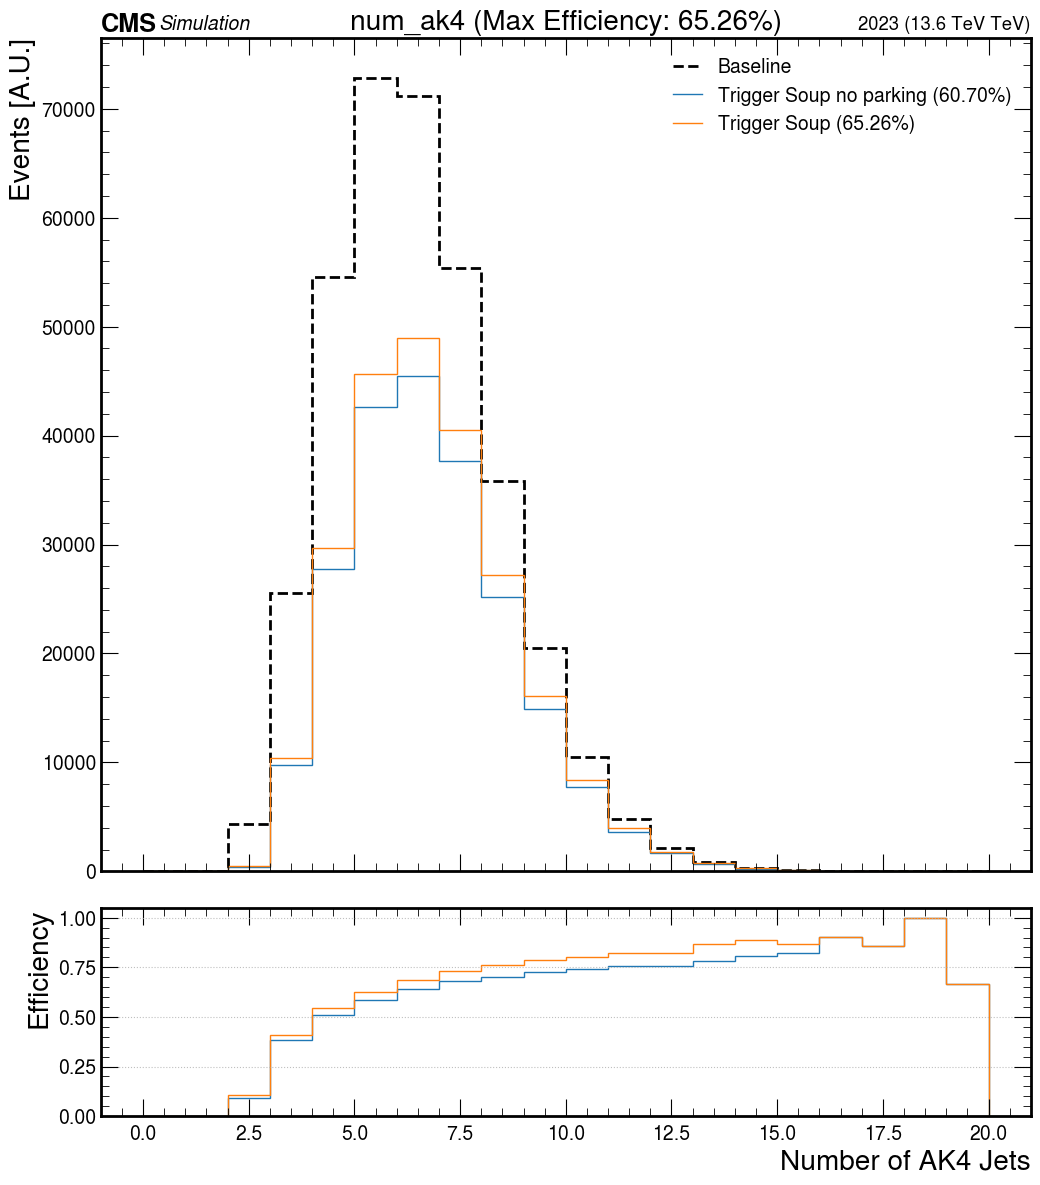

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


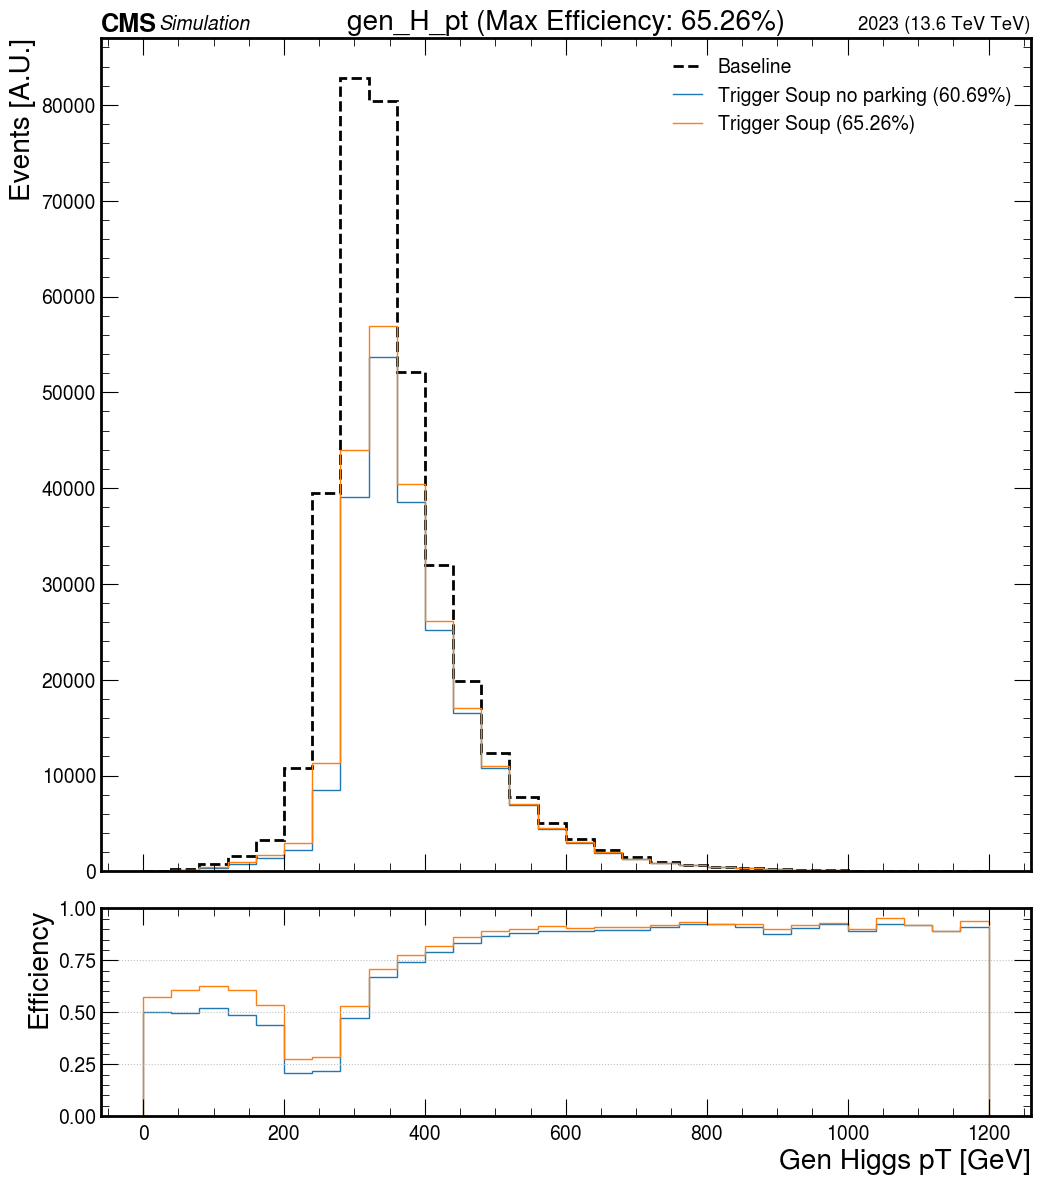

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


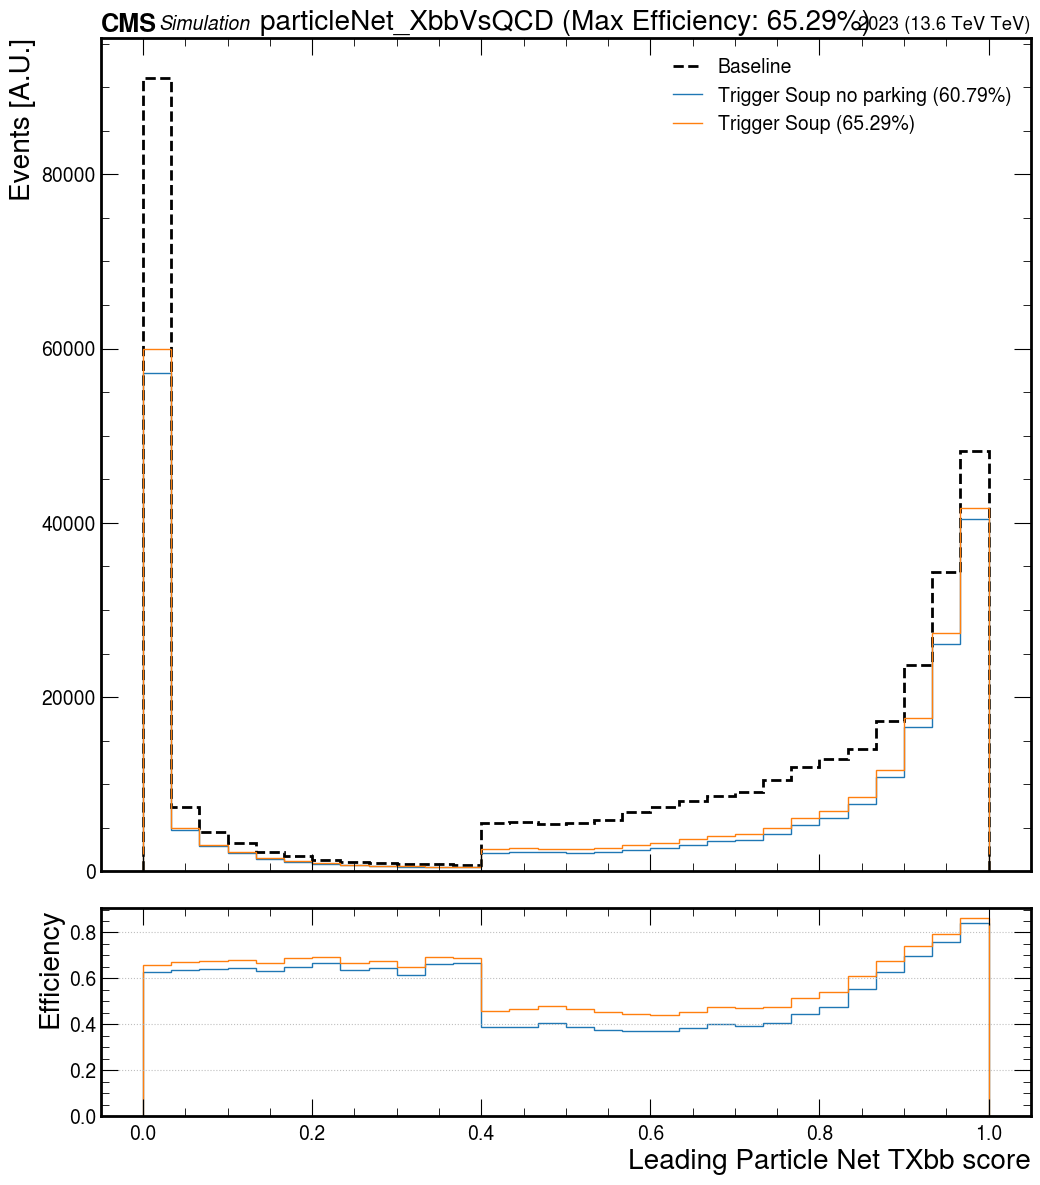

Processing period 2023BPix
Currently processing production mode VBF


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


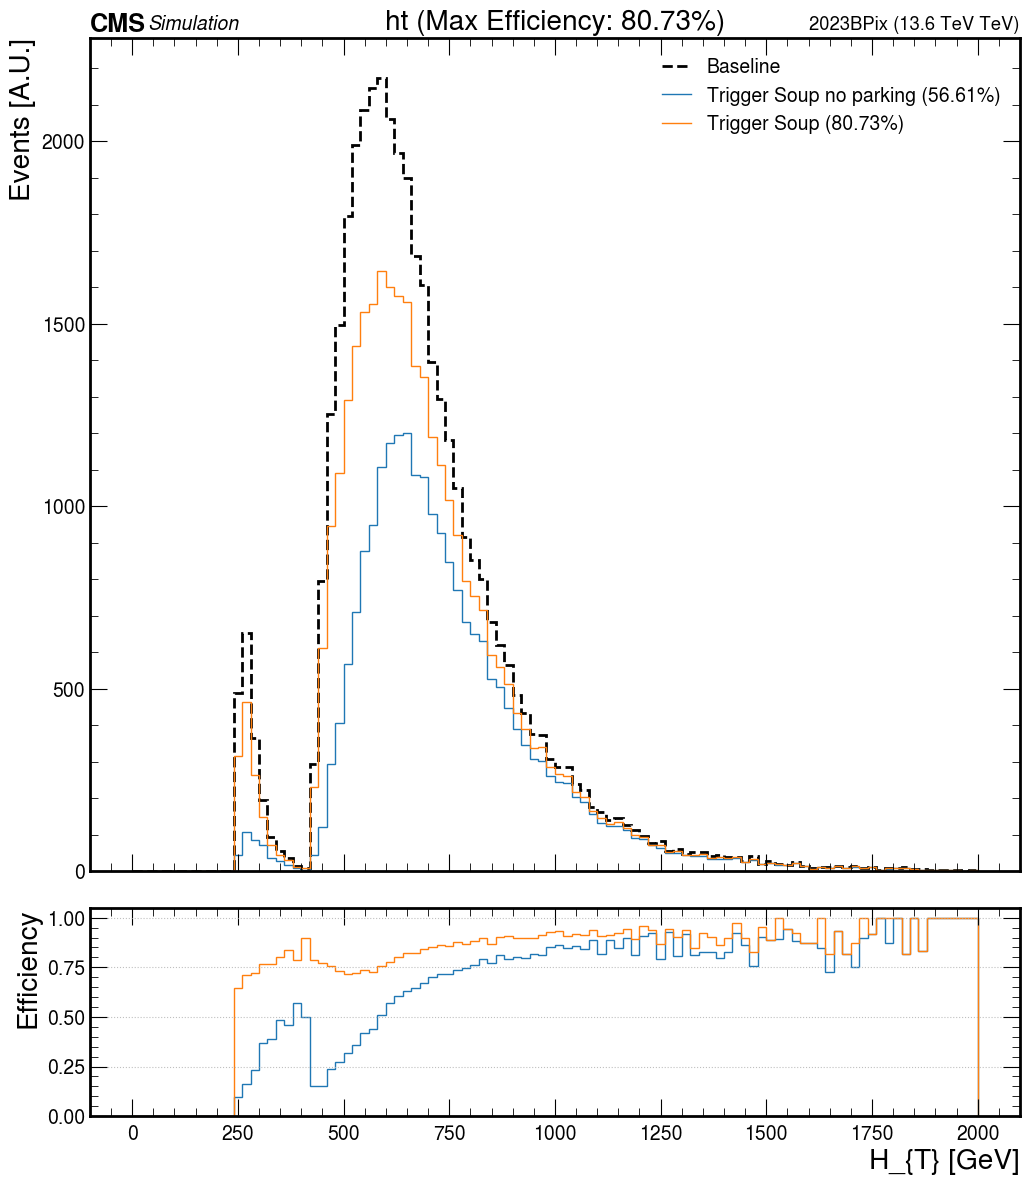

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


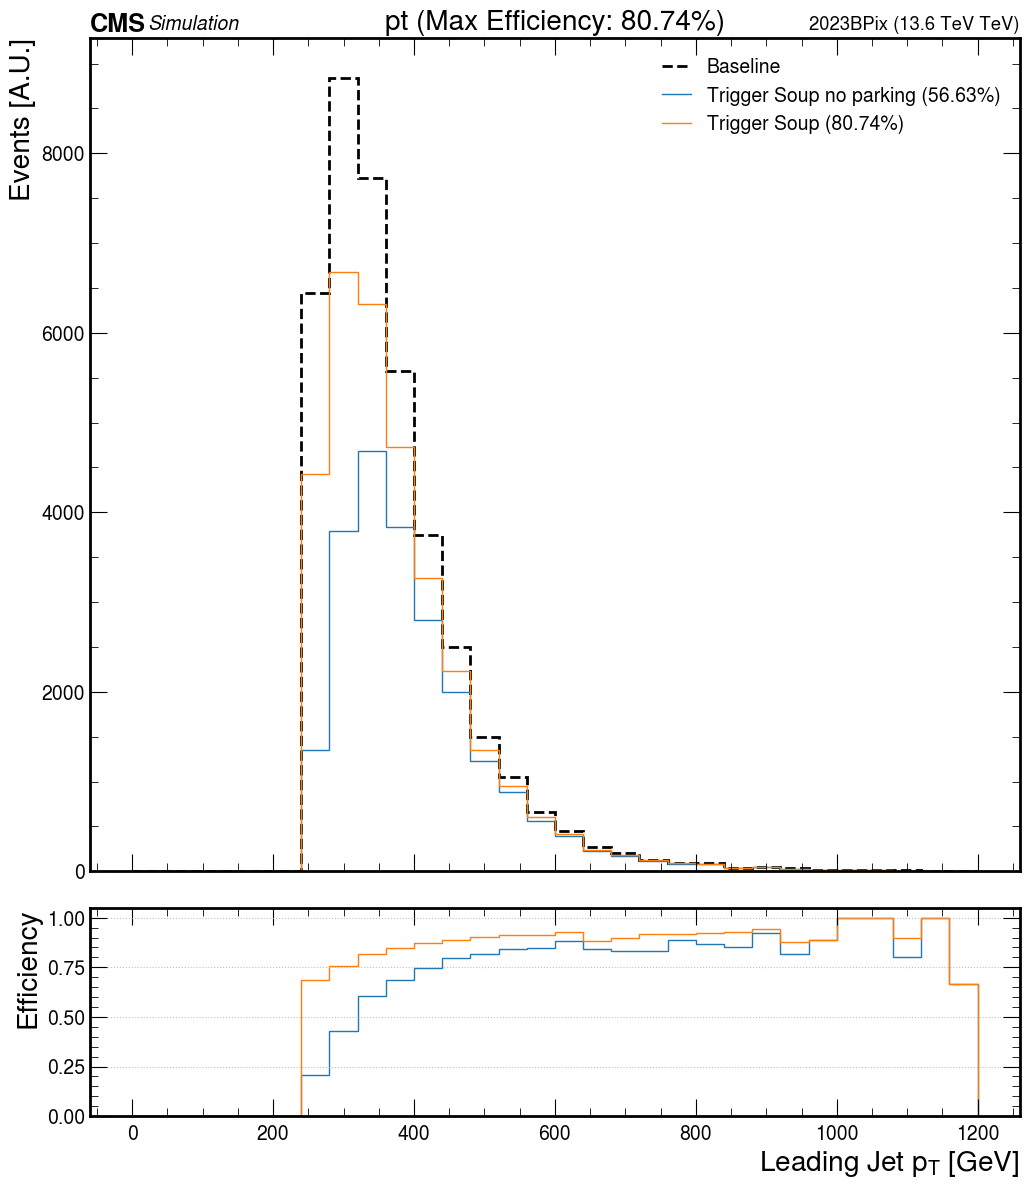

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


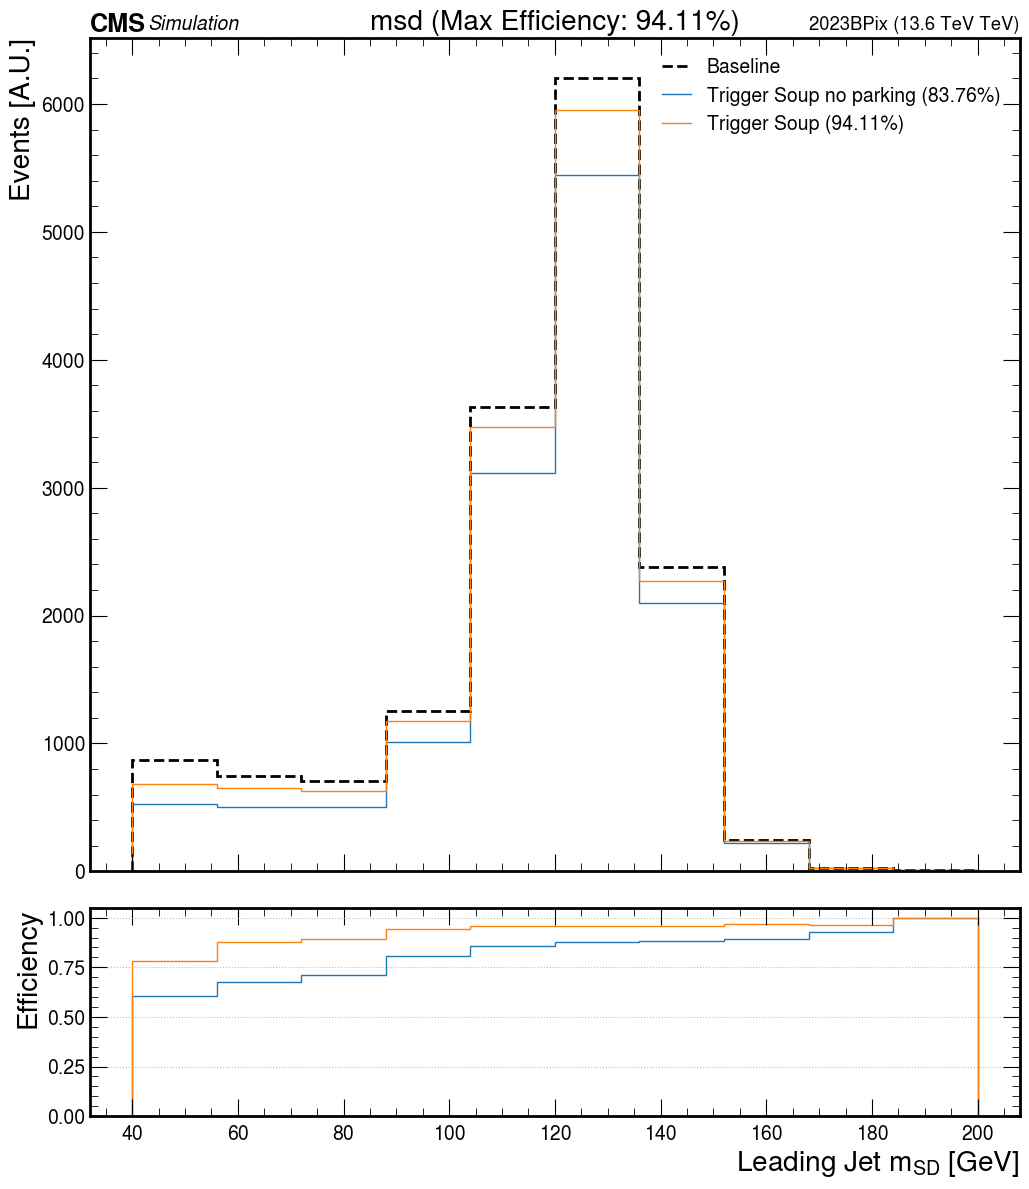

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


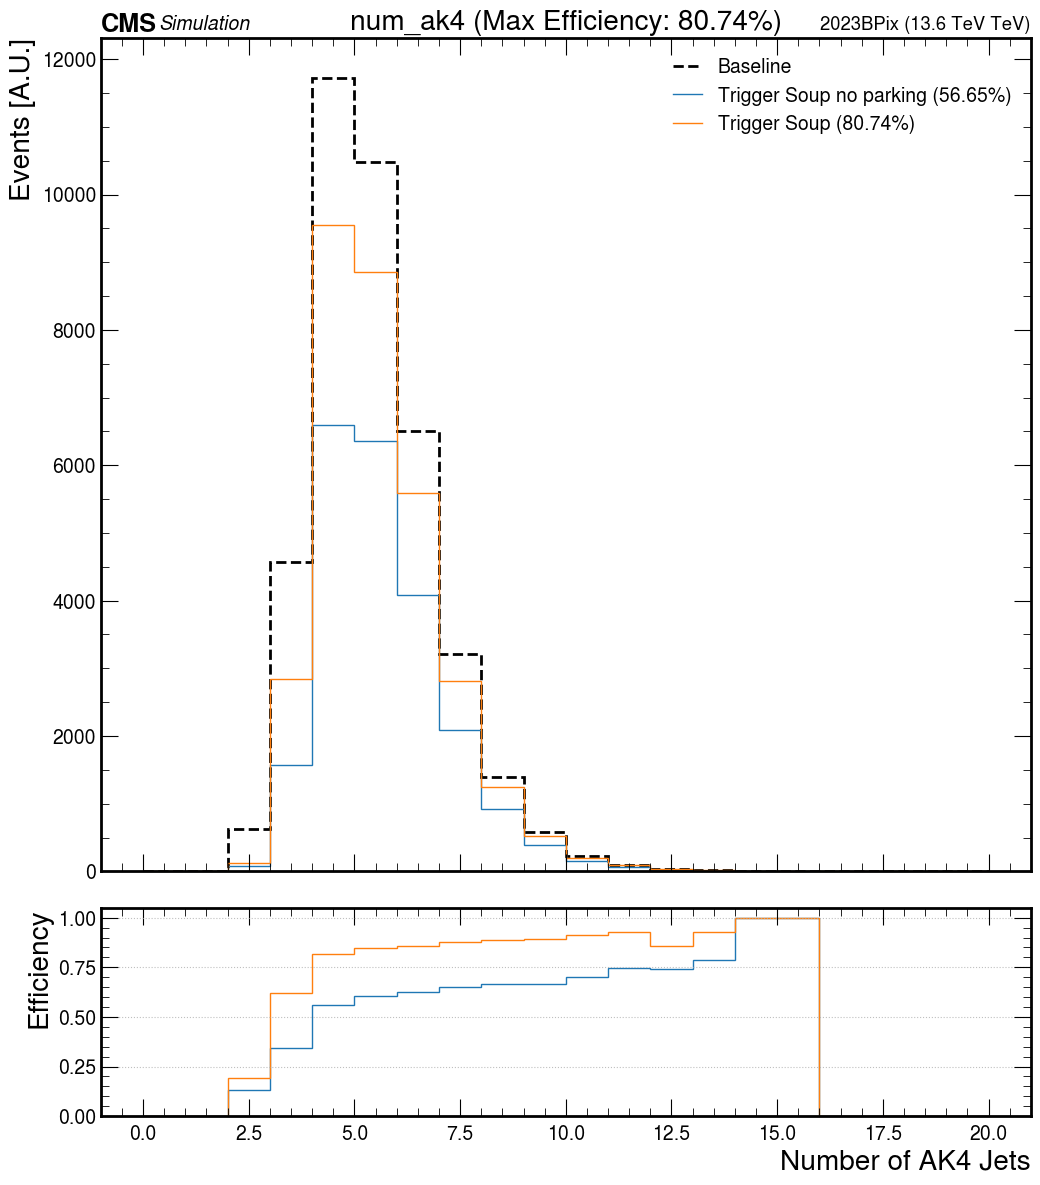

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


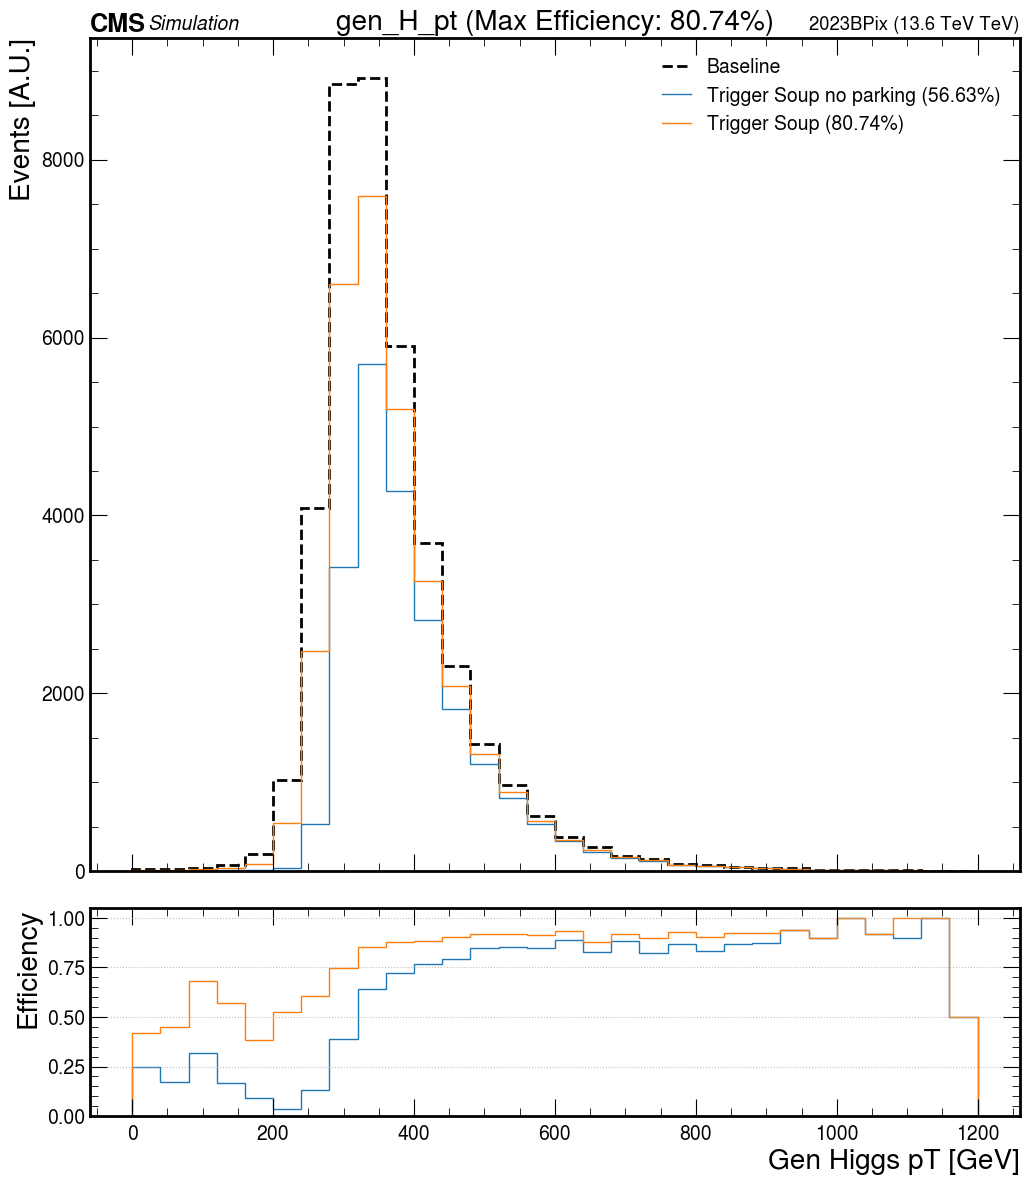

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


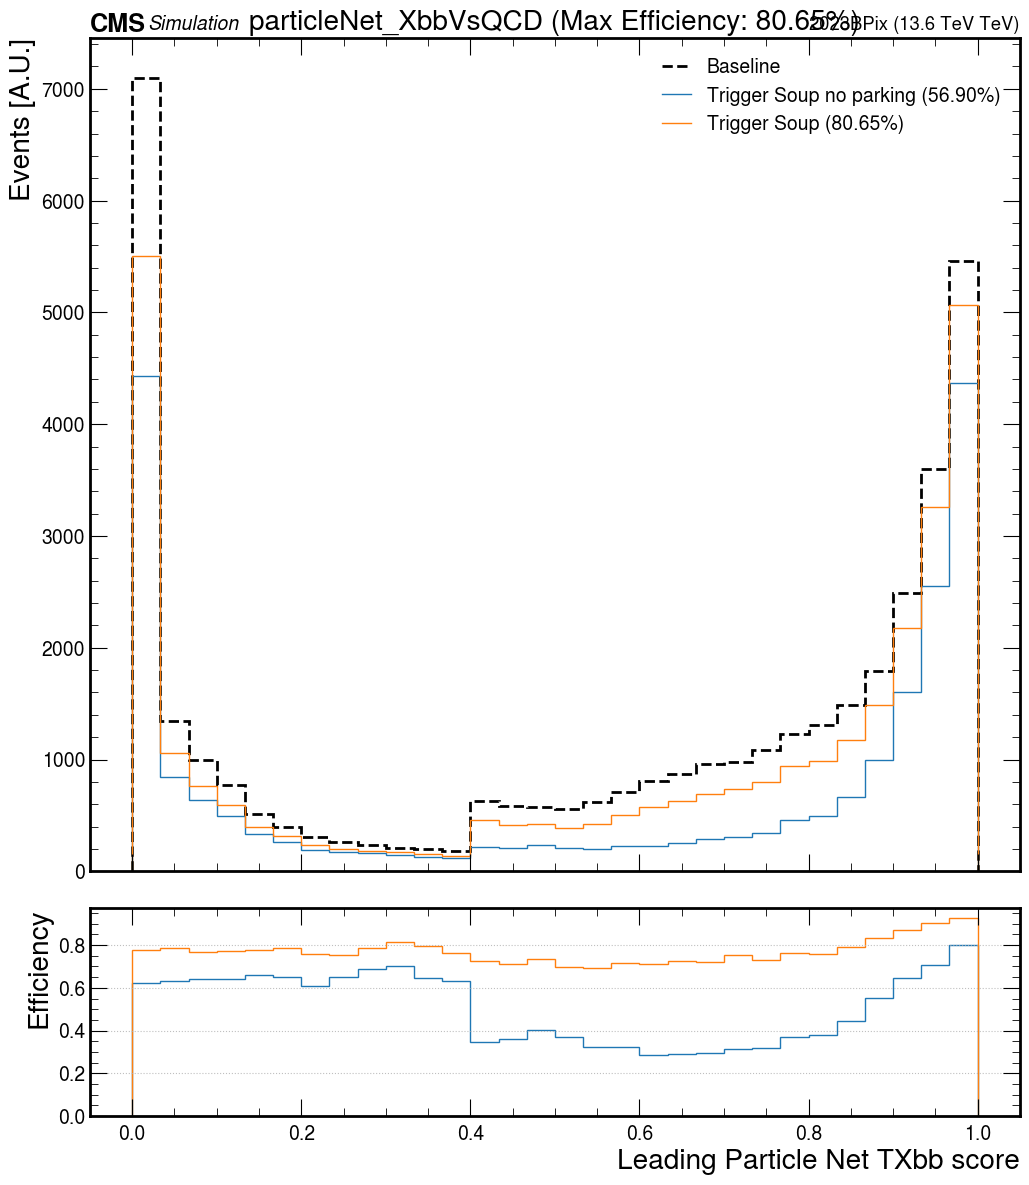

Currently processing production mode ggF


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


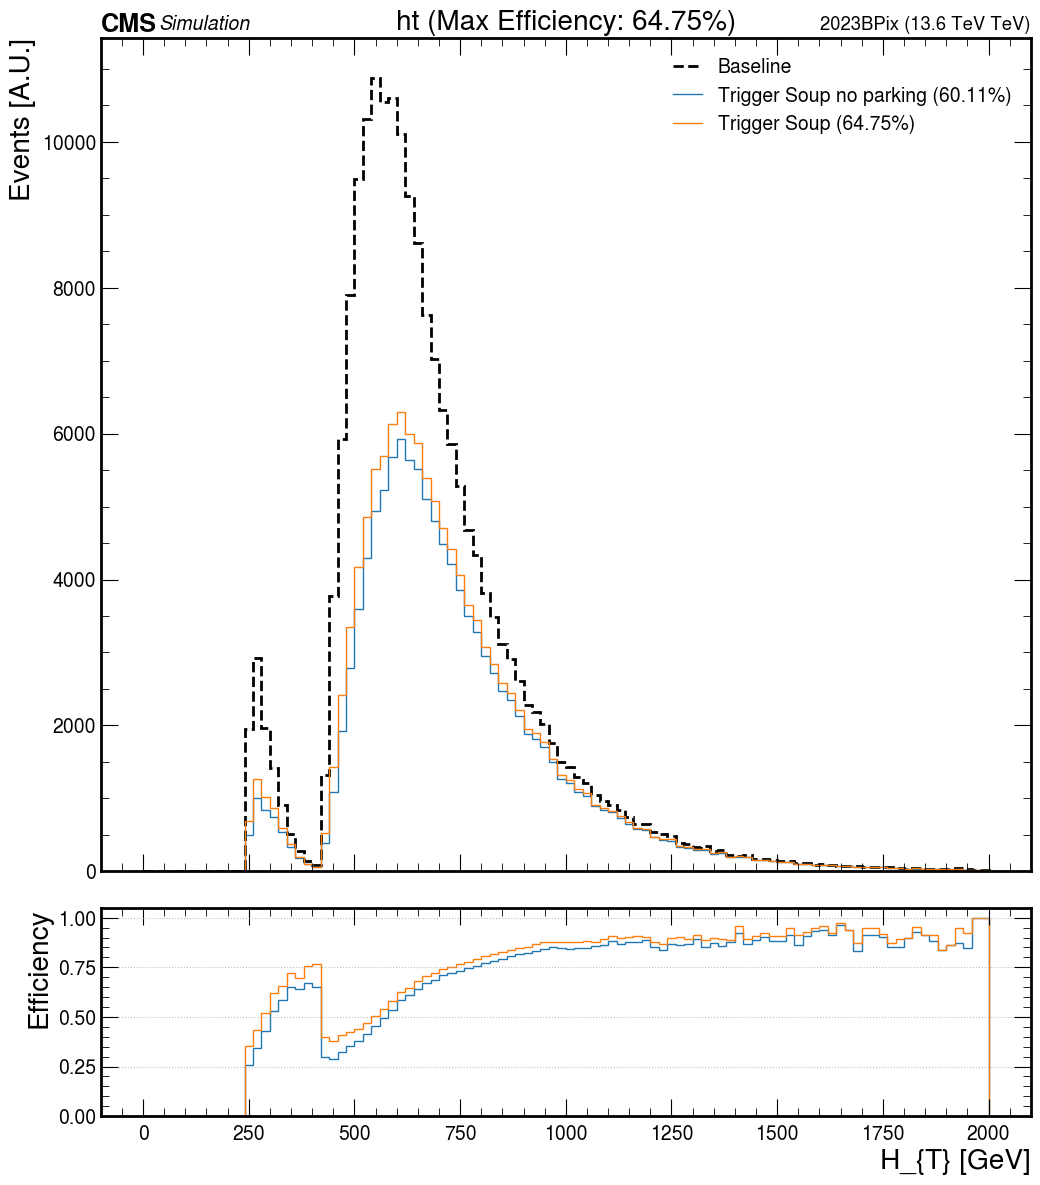

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


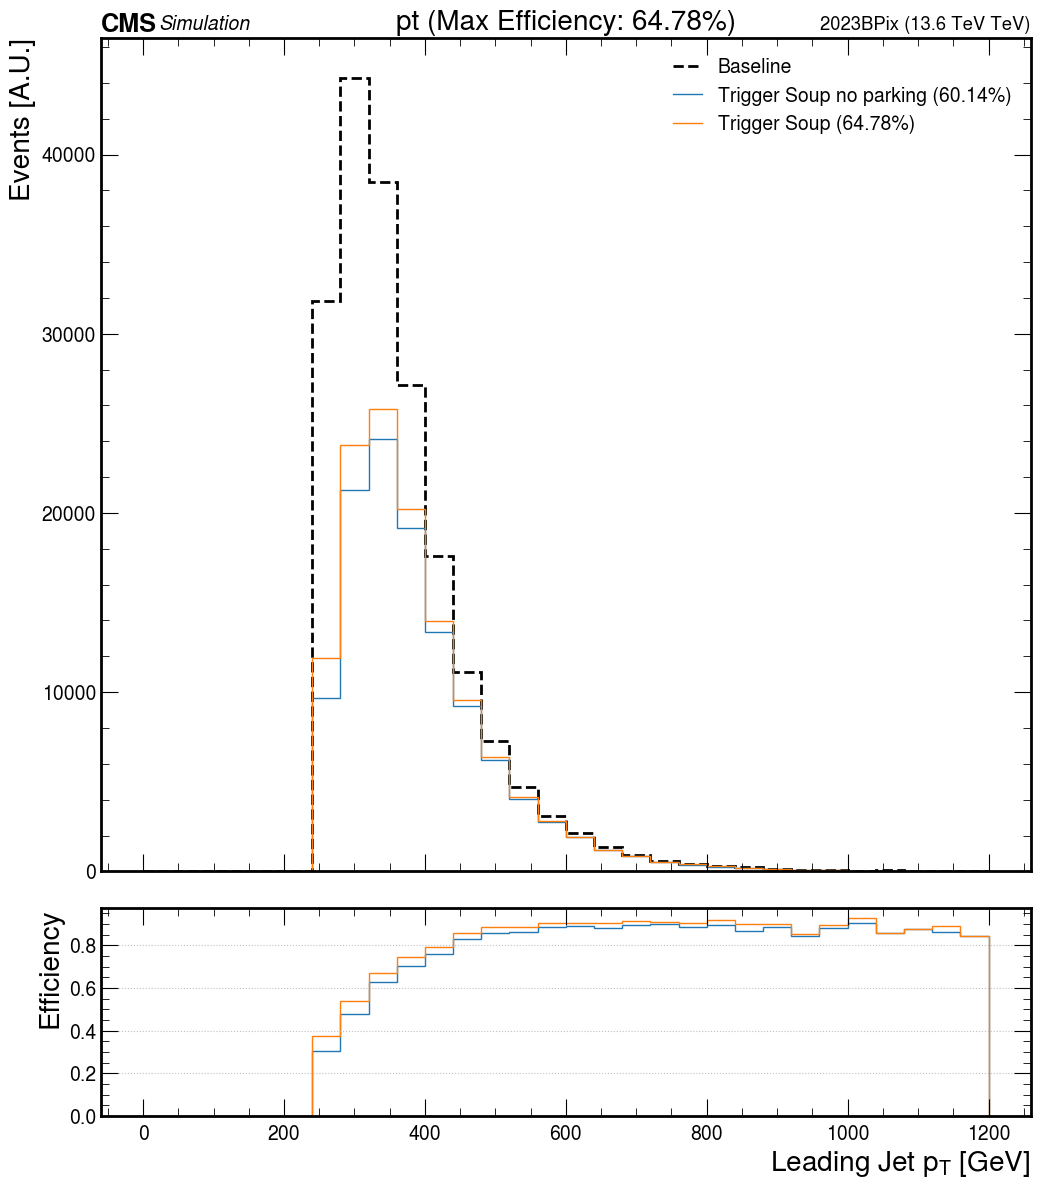

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


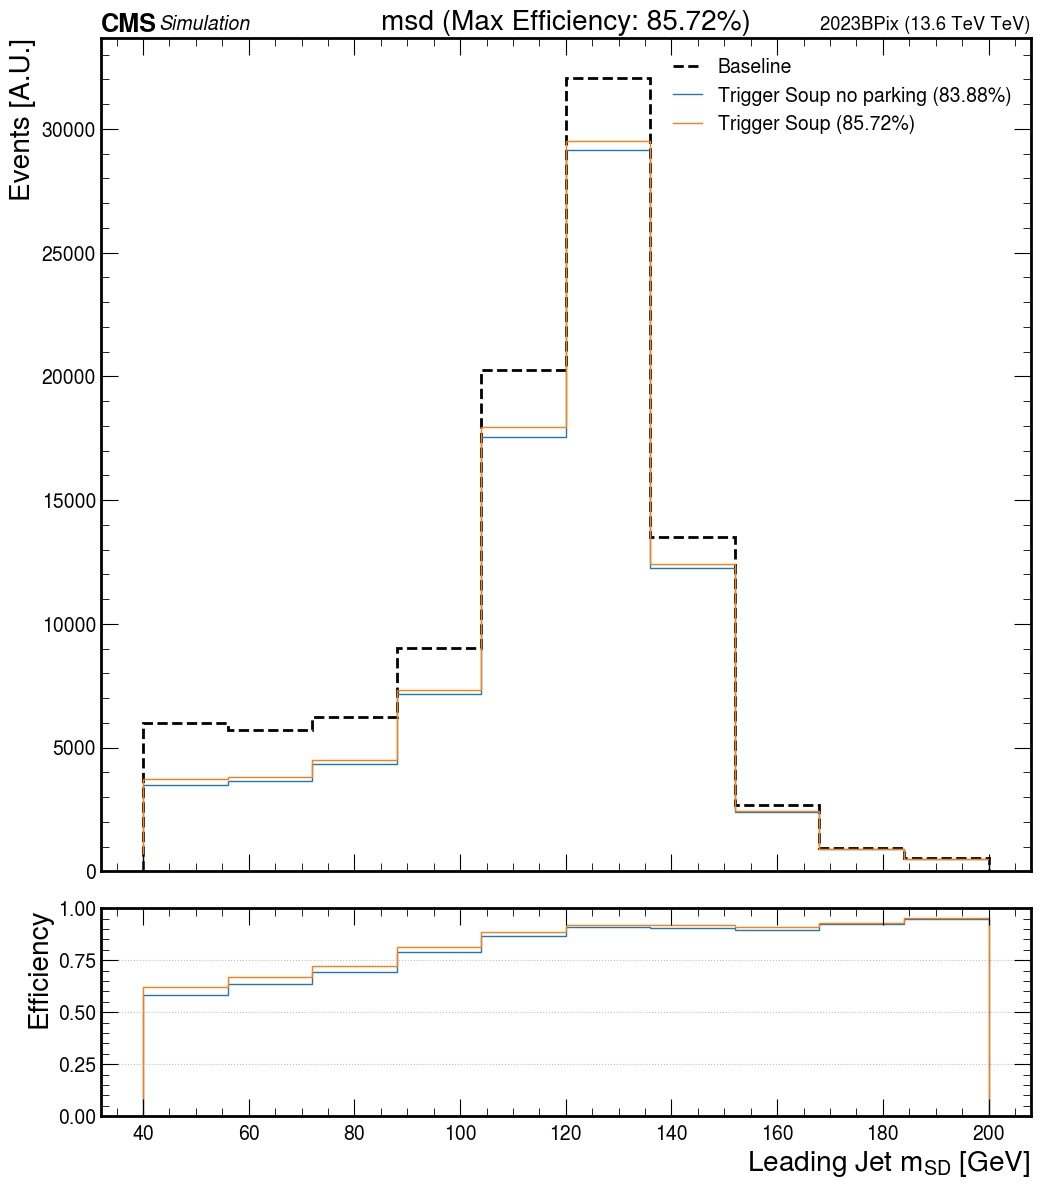

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


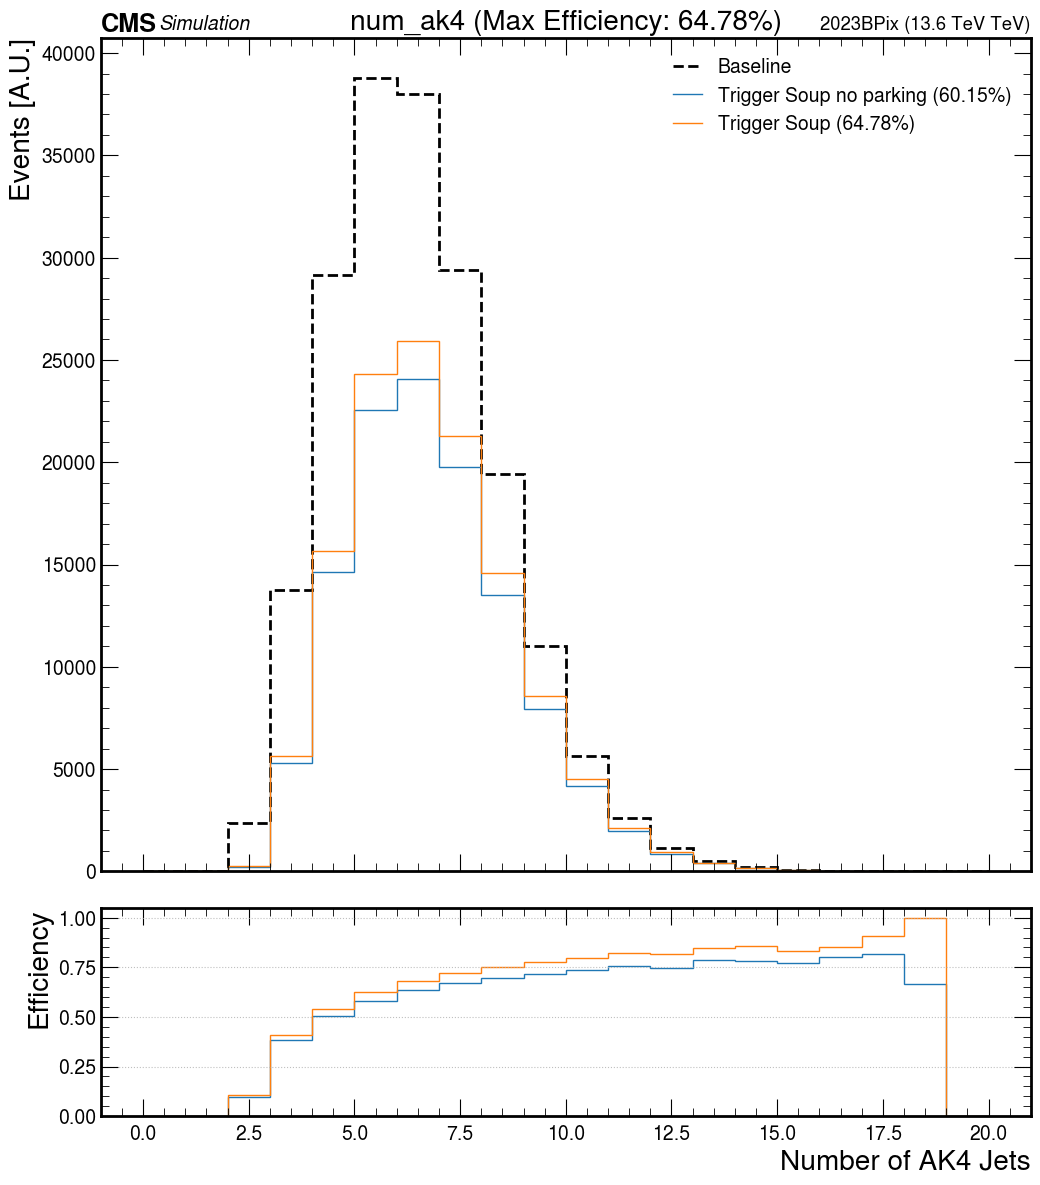

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


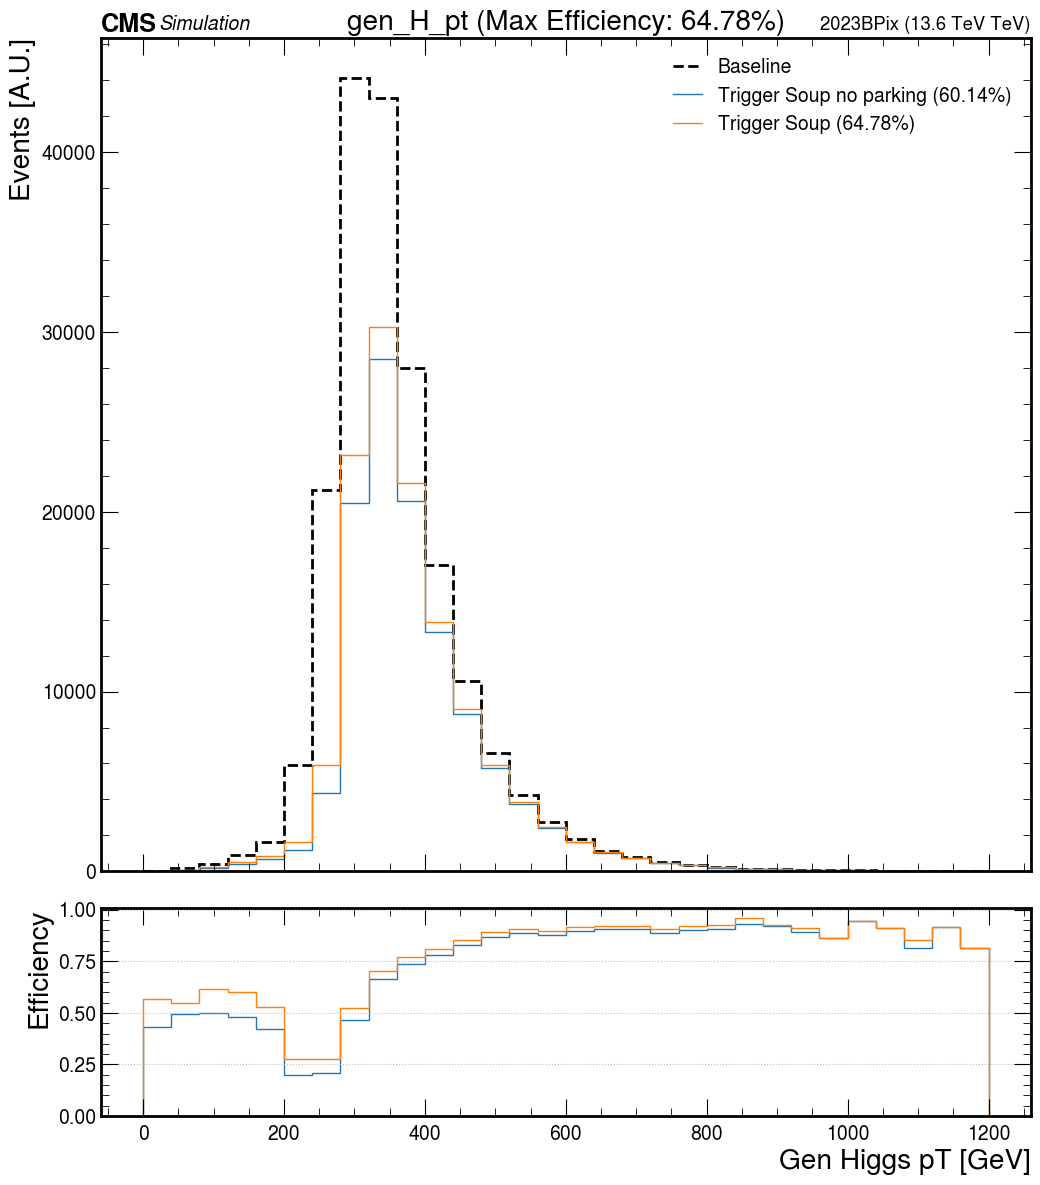

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


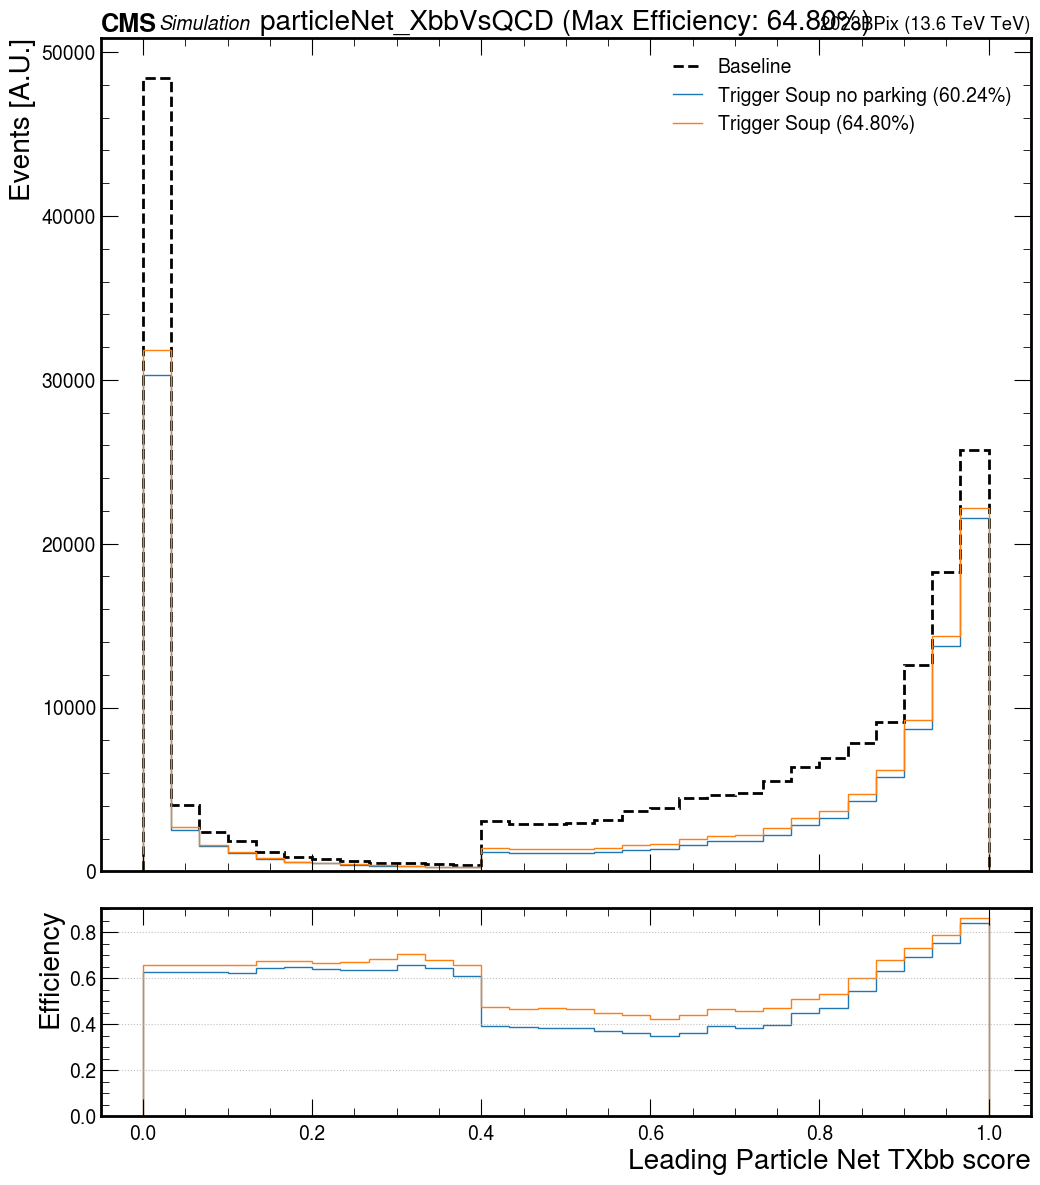

Processing period 2022
Currently processing production mode VBF


Output()

Output()

In [ ]:
# for year in ['2023', '2023BPix', '2022EE']:
for year in ['2023', '2023BPix', '2022', '2022EE']:
# for year in ['2022', '2022EE']:
# for year in ['2023', '2023BPix']:
    print(f'Processing period {year}')
    all_triggers = trigger_dict_periods[year]
    no_parking = all_triggers[:3] # differs from all_triggers only for 2023 and 2023BPix
    file_dict = {'VBF': "VBF_Hto2B", 'ggF': "GluGlu_Hto2B"}
    outputs = {key_prod: [] for key_prod in file_dict.keys()}
    for prod_mode, file_name in file_dict.items():
        print("Currently processing production mode", prod_mode)
        with open(f'/srv/{year}/{year}_{prod_mode}.json', 'r') as file:
            data = json.load(file)
        samples = data[file_name]
        samples = samples[:50]
        iterative_run = processor.Runner(
                executor = processor.FuturesExecutor(compression=None, workers=2),
                schema=NanoAODSchema,
                skipbadfiles=True,  # Skip files that fail to open
                savemetrics=True,   # Save metrics to understand where failures occur
        )
        fileset = {"Dataset" : samples}
        group_1_tag = 'Trigger Soup no parking'
        group_2_tag = 'Trigger Soup'
        out = iterative_run(
            fileset,
            treename="Events",
            processor_instance=ParkingSoupProcessor(no_parking, all_triggers, trig_vars, group_1_tag, group_2_tag, baseline_key=prod_mode),
        )
        output = out[0]
        outputs[prod_mode] = output
    
        save_dir = f"/srv/figures/MC/{year}/{prod_mode}/"
        plot_1d_trigger_soup_cms(output, trig_vars, save_dir=save_dir, year=year, data=False, show_img=False)
        

## Data

In [4]:
file_dict_periods = {'2022': {'JetData': "JetMET_Run2022C", 'MuonData': "Muon_Run2022C"},
                     '2022EE': {'JetData': "JetMET_Run2022E", 'MuonData': "Muon_Run2022E"},
                     '2023': {'JetData': "JetMET0_Run2023C-v4", 'MuonData': "Muon0_Run2023C-v4"},
                     '2023BPix': {'JetData': "JetMET0_Run2023D-v1", 'MuonData': "Muon0_Run2023D-v1"}
                    }

Processing period 2023
Currently processing production mode JetData


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


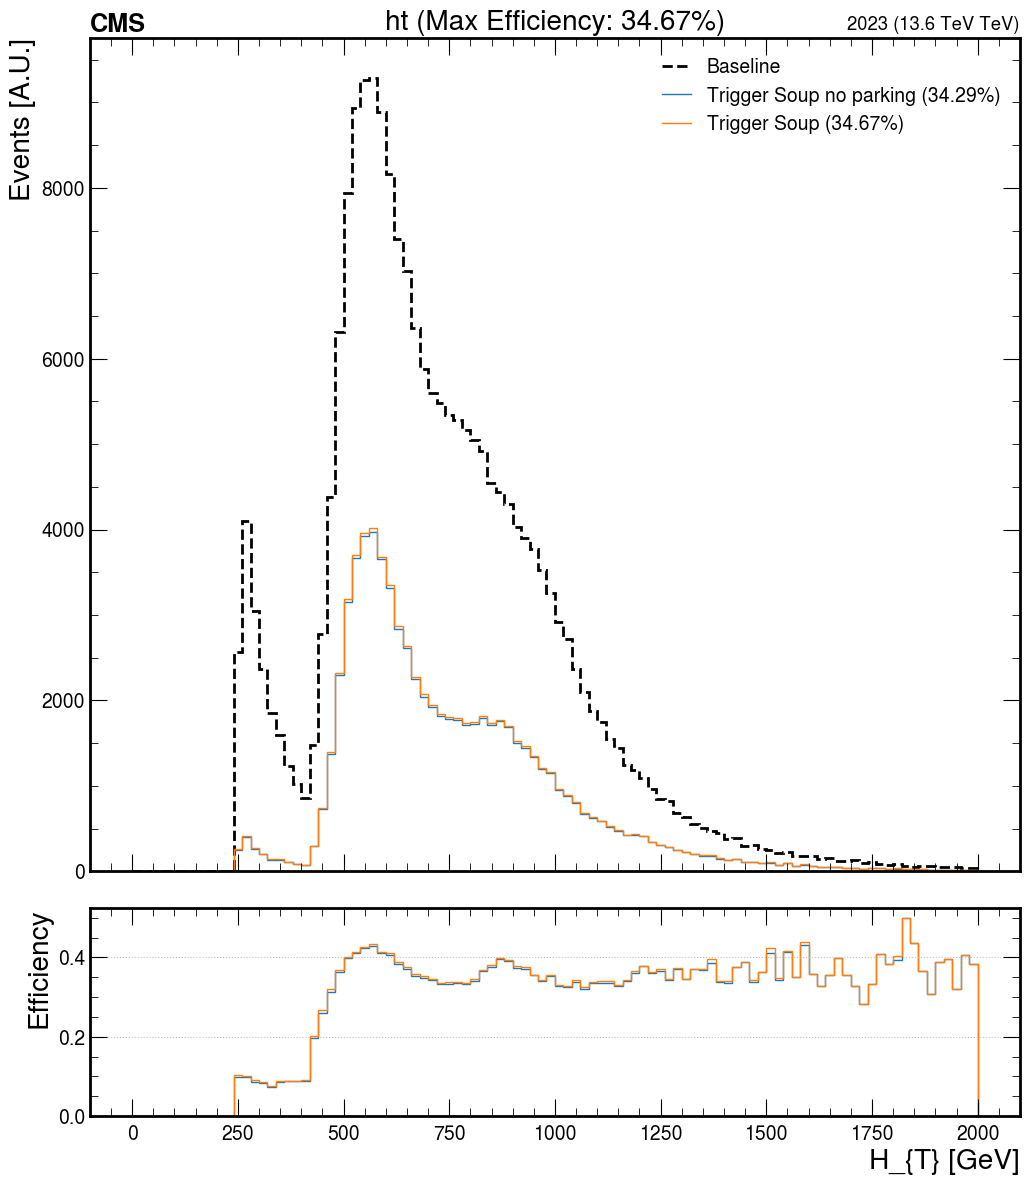

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


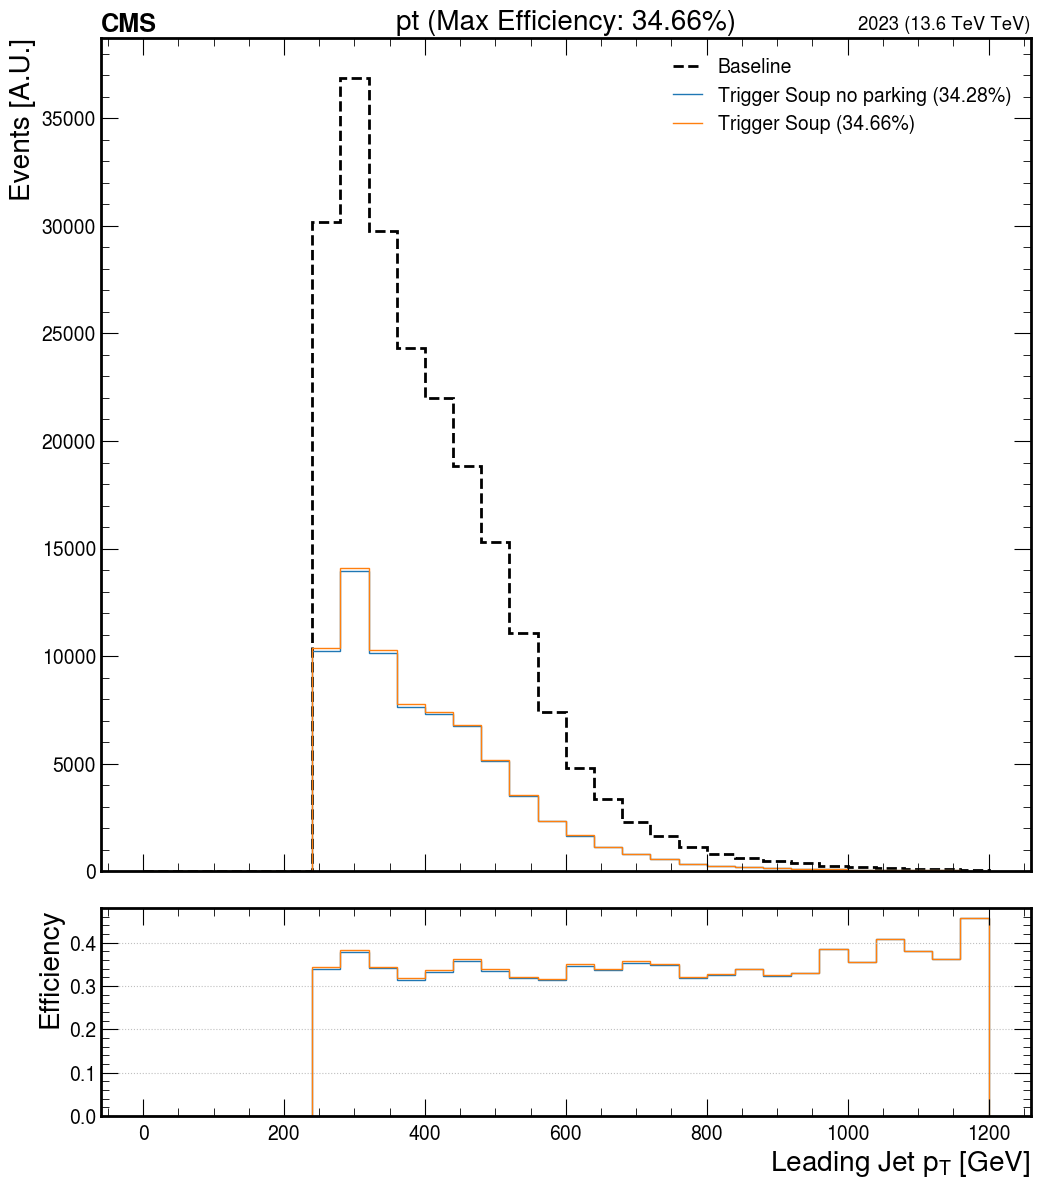

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


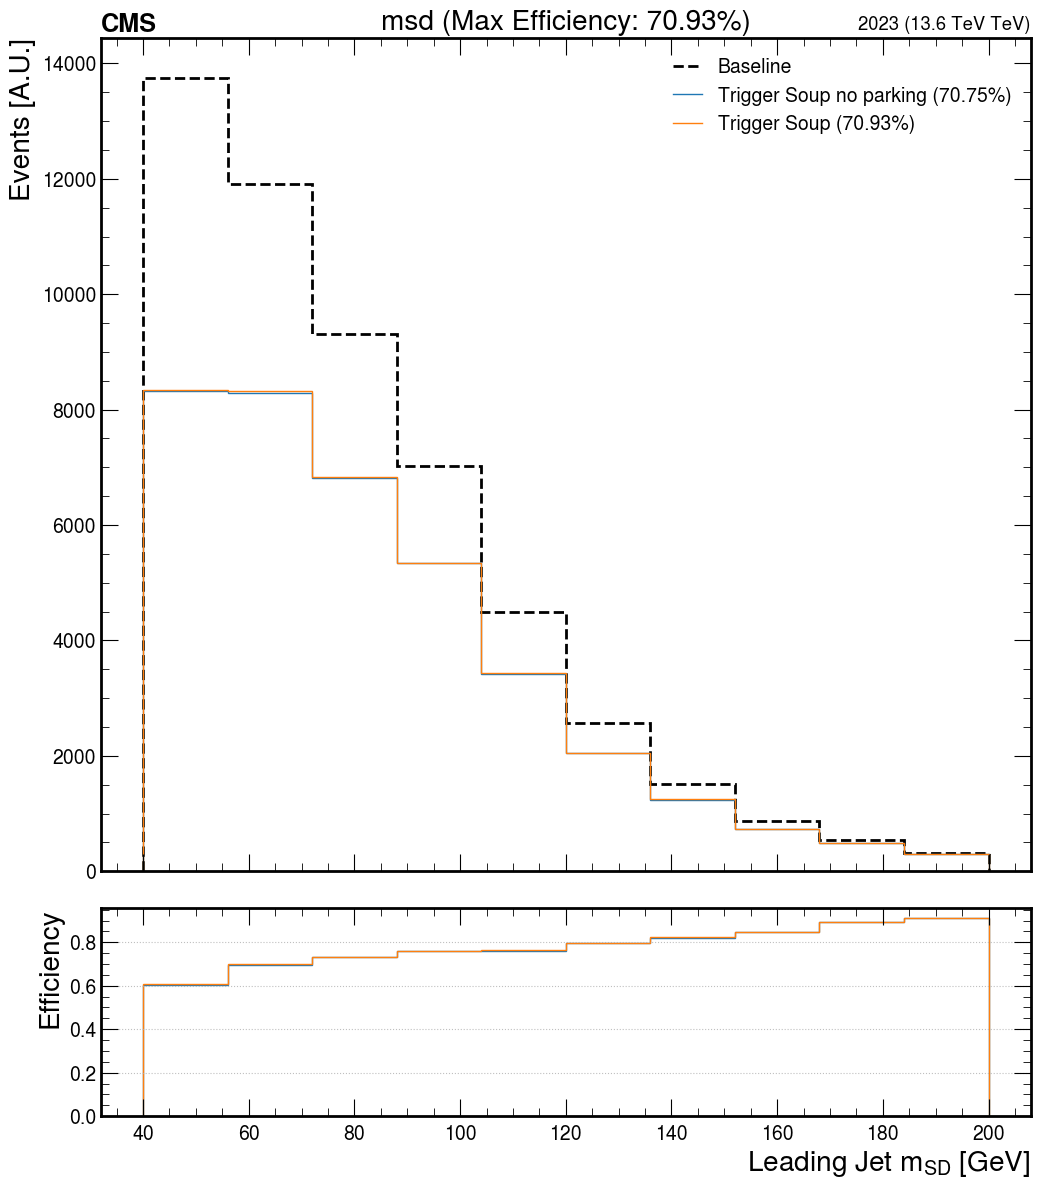

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


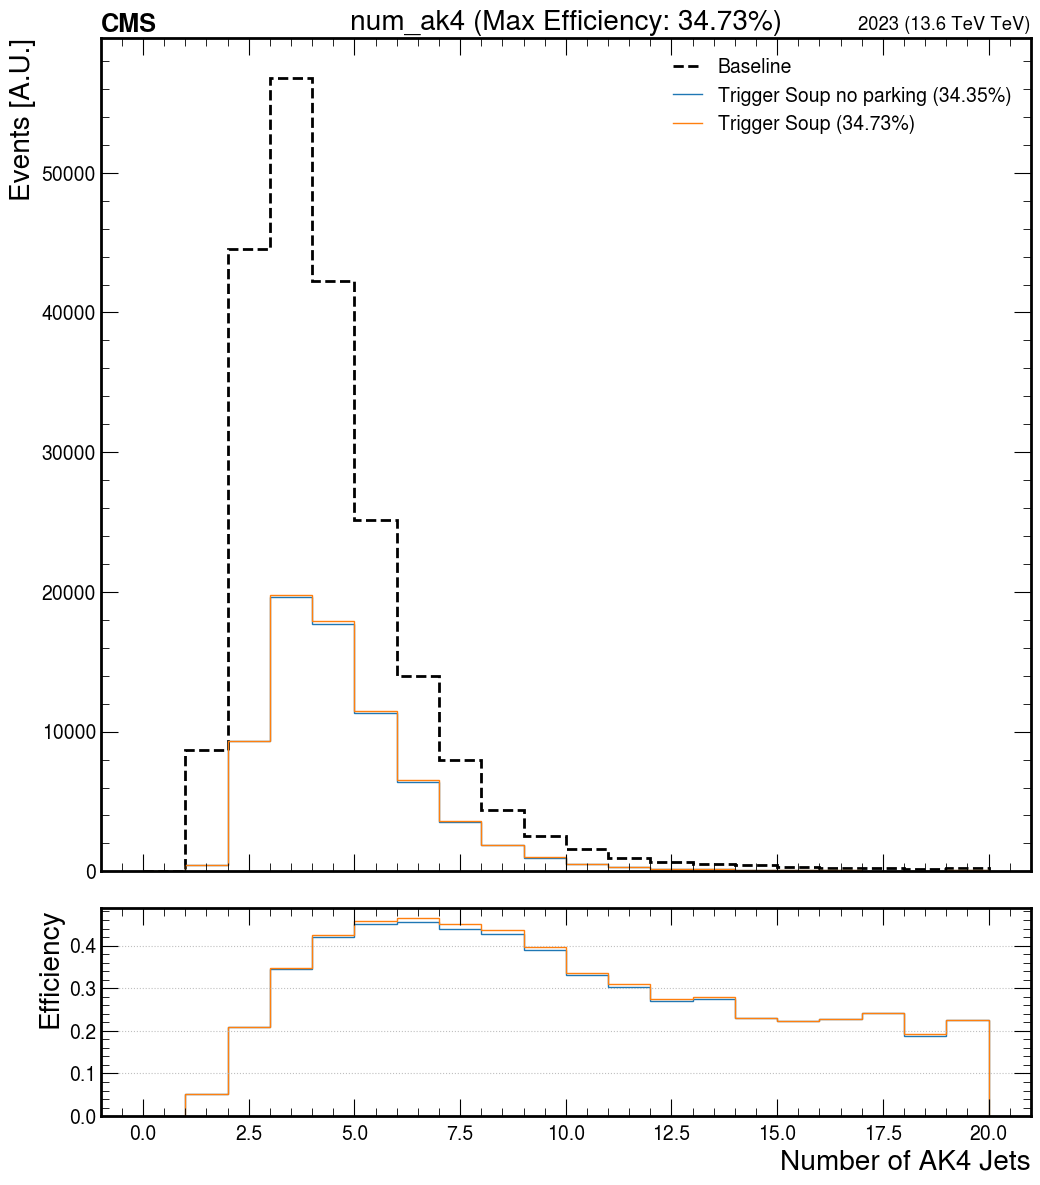

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


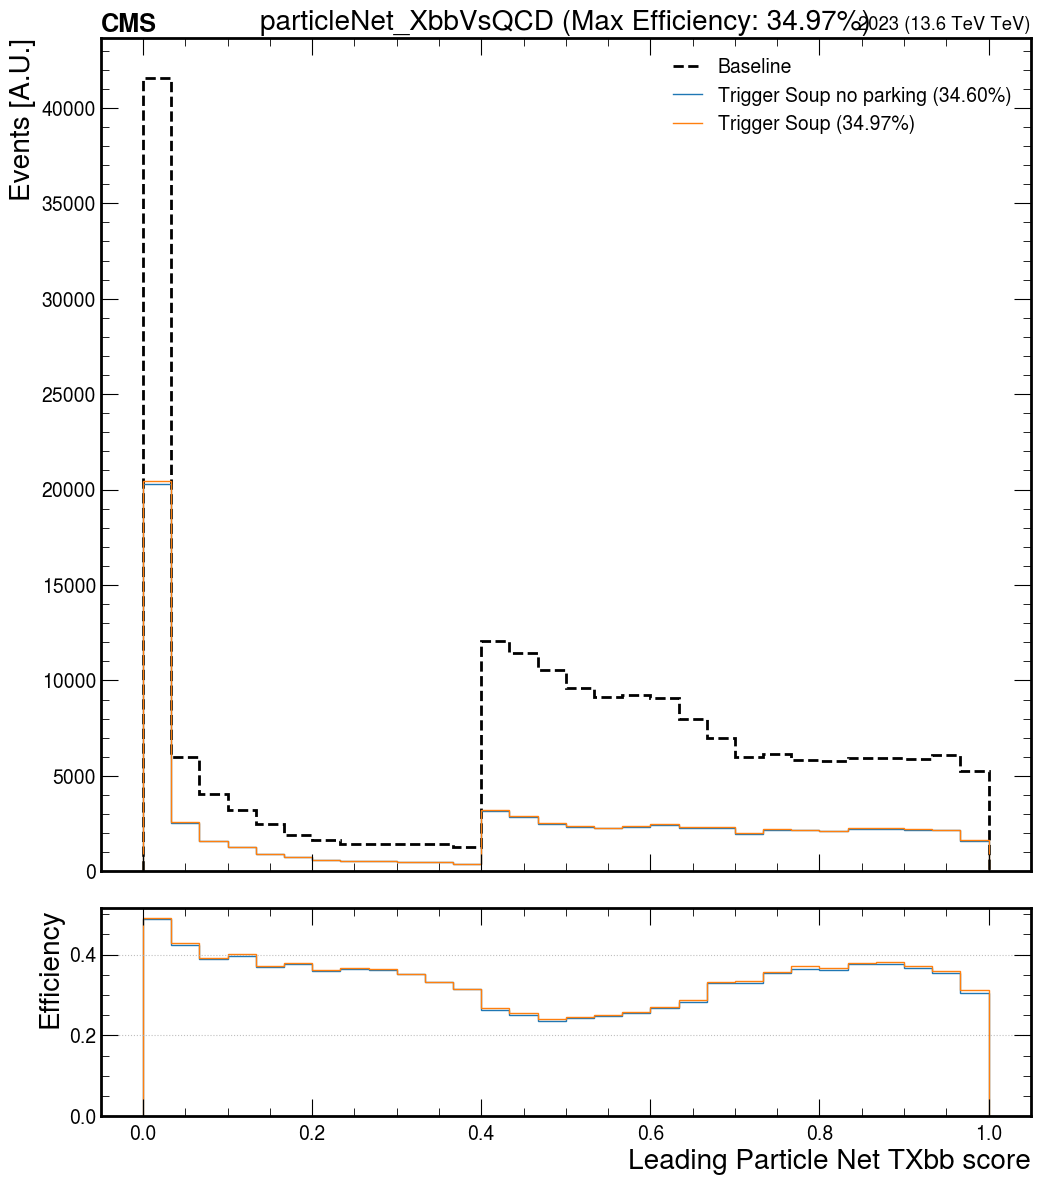

Currently processing production mode MuonData


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


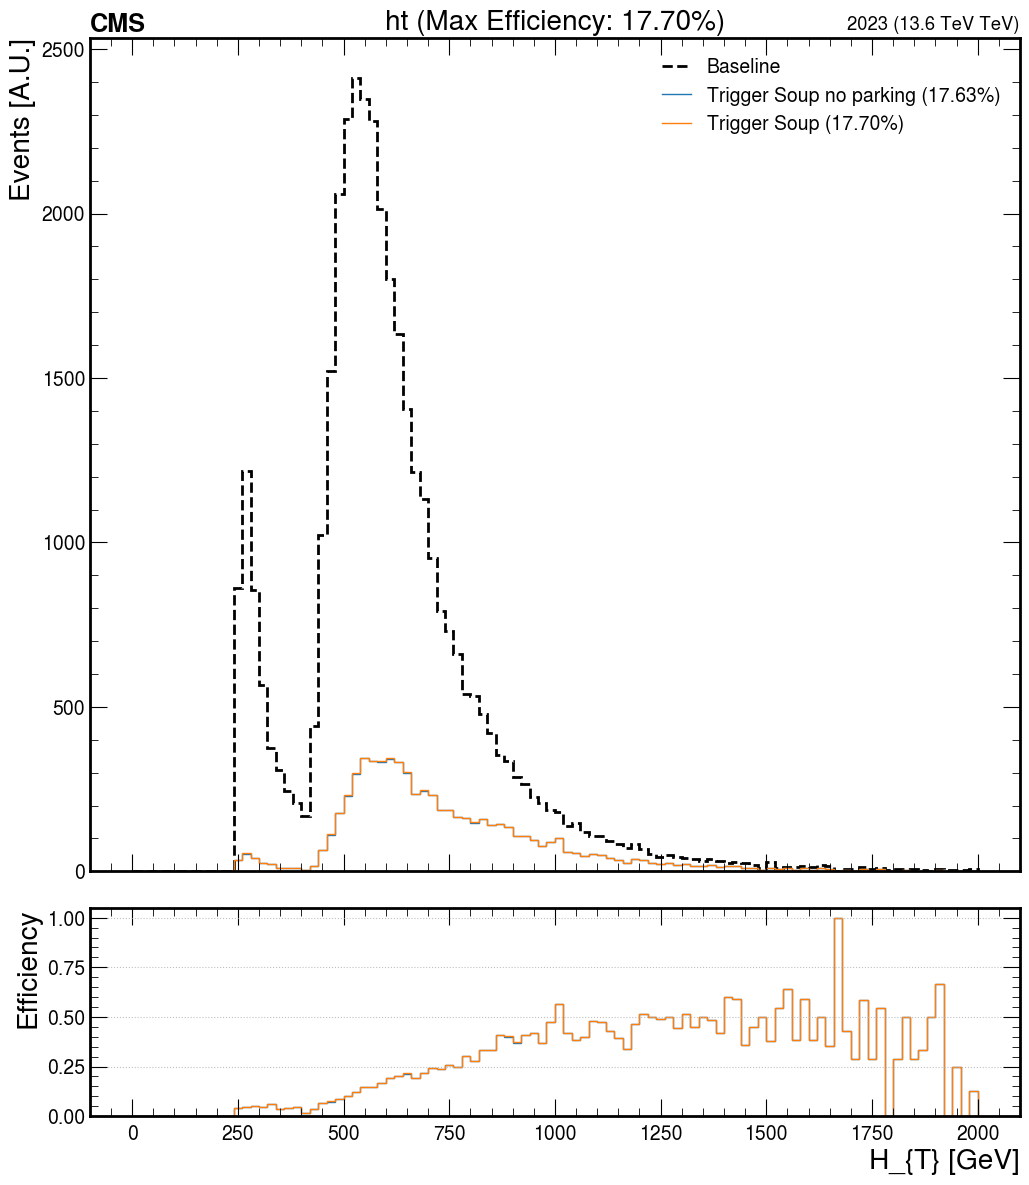

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


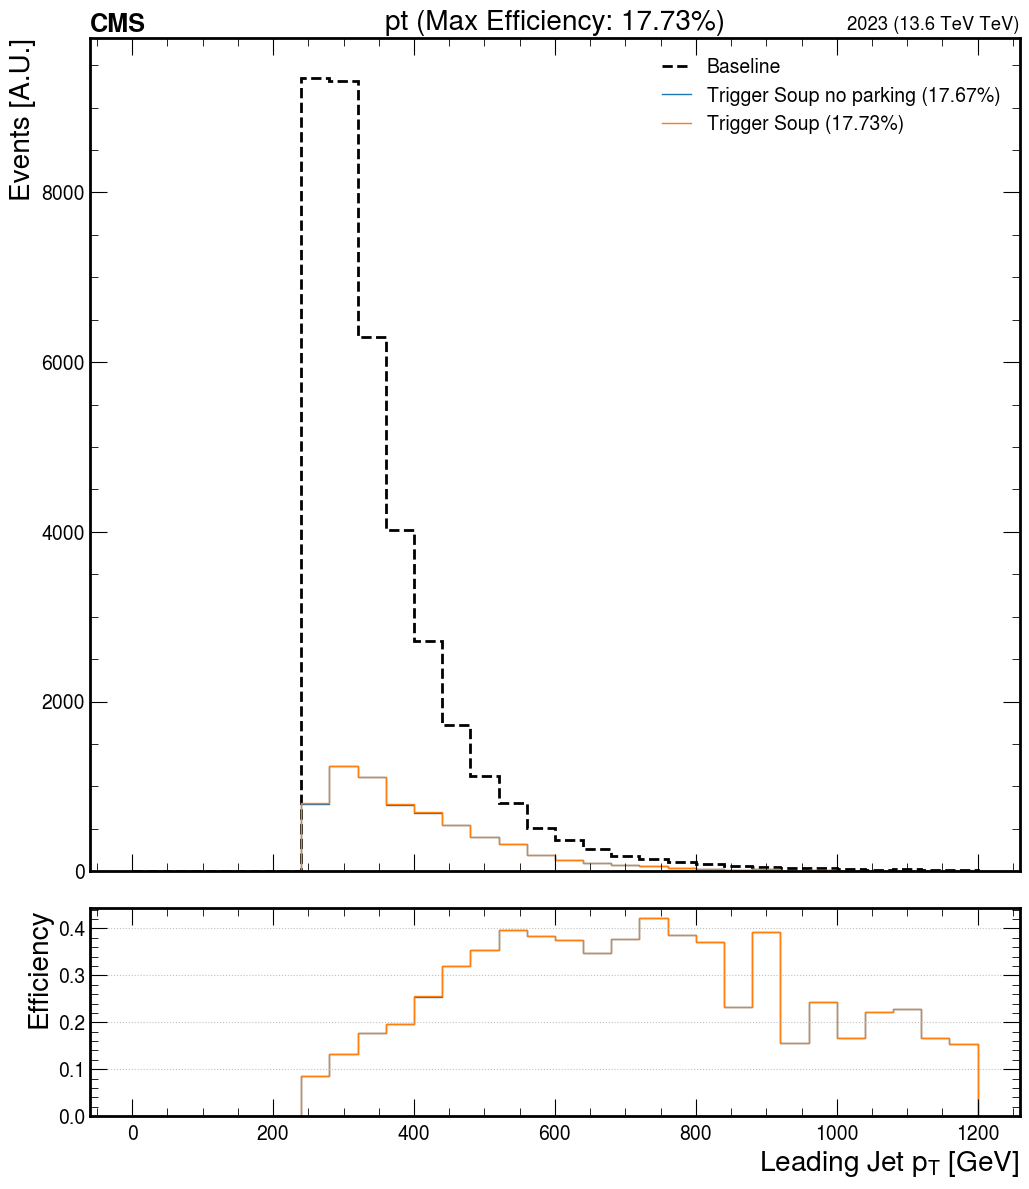

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


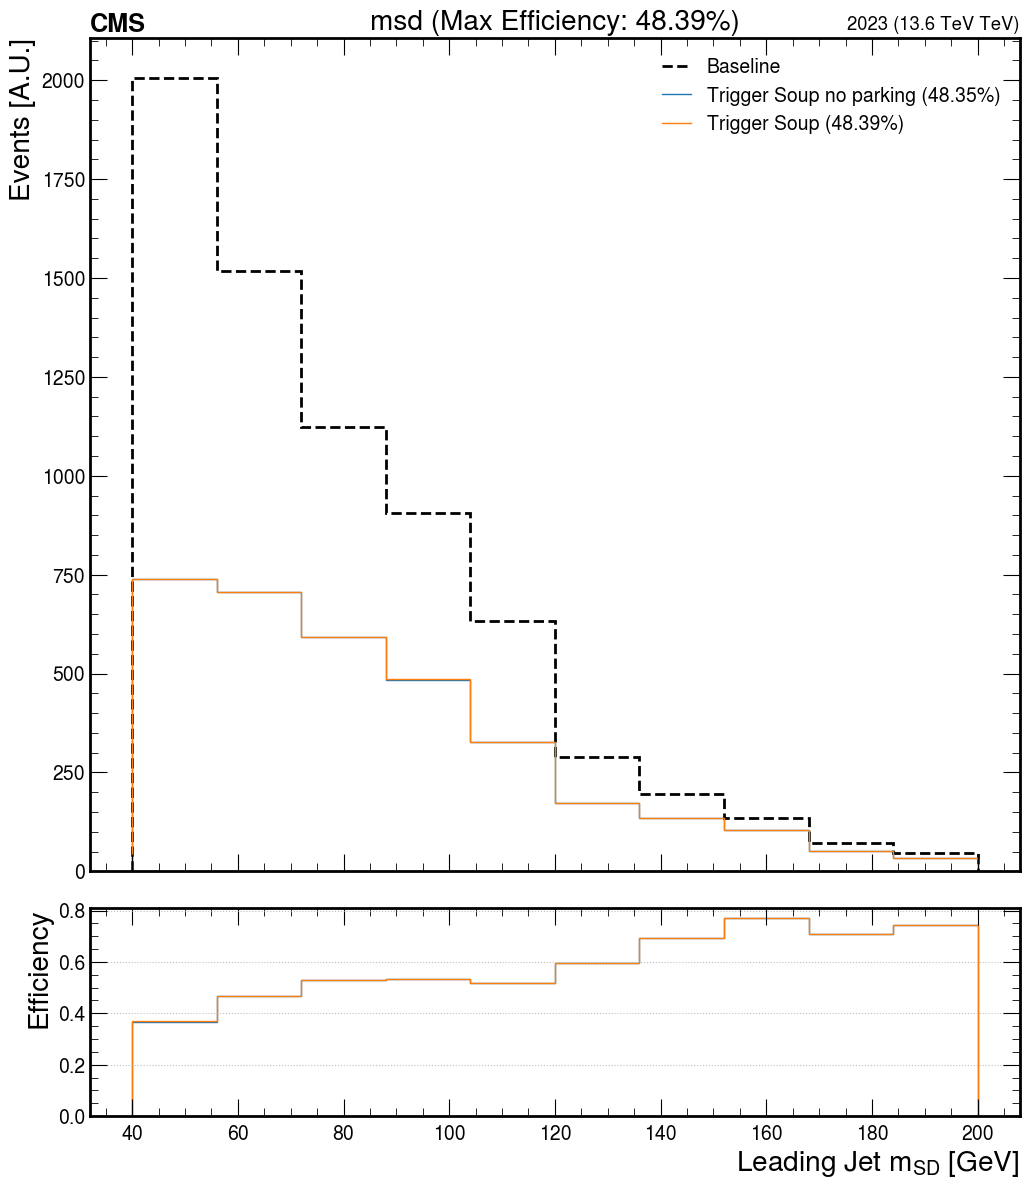

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


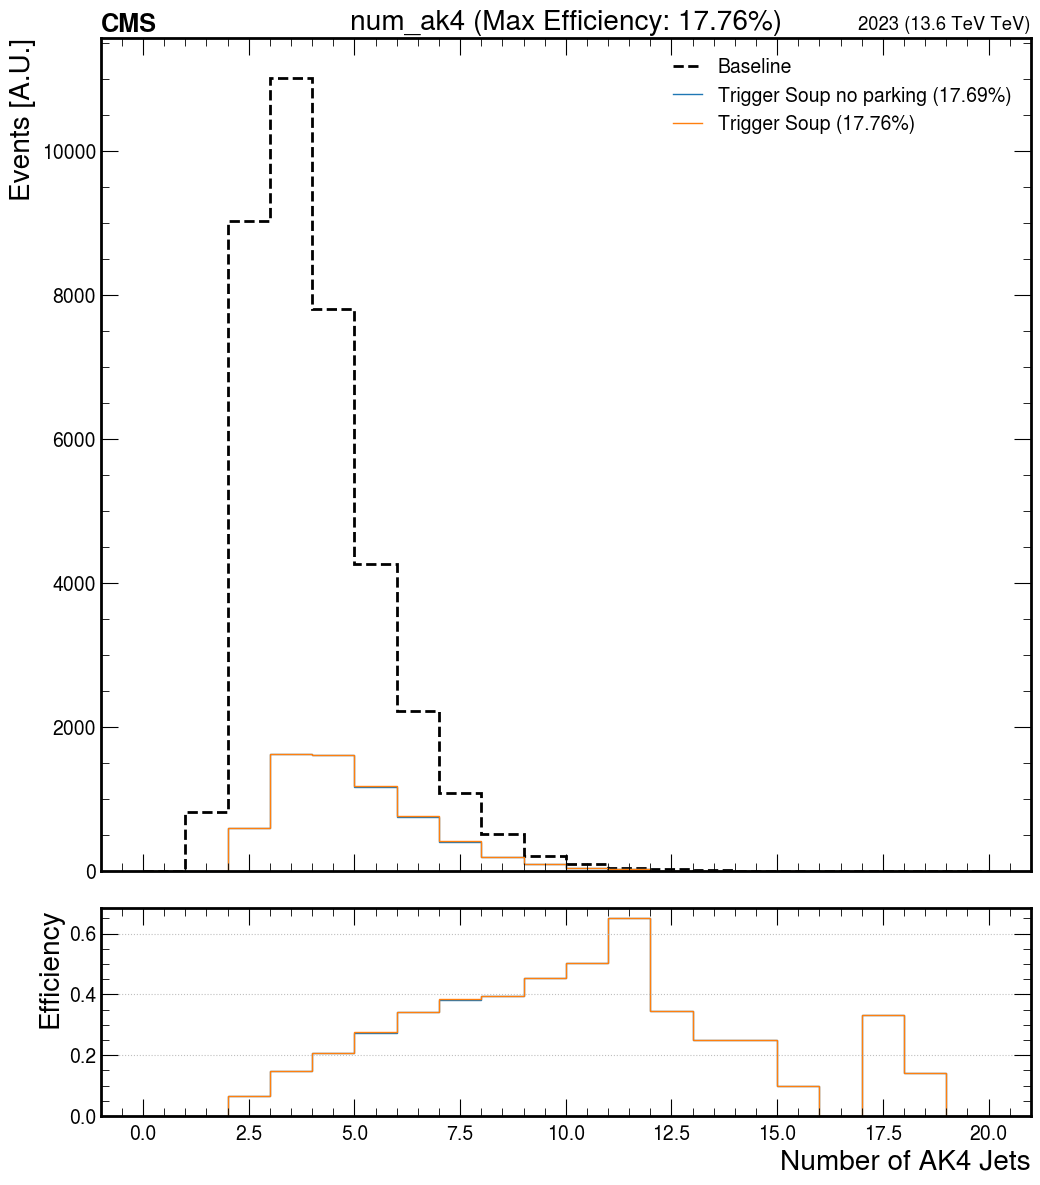

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


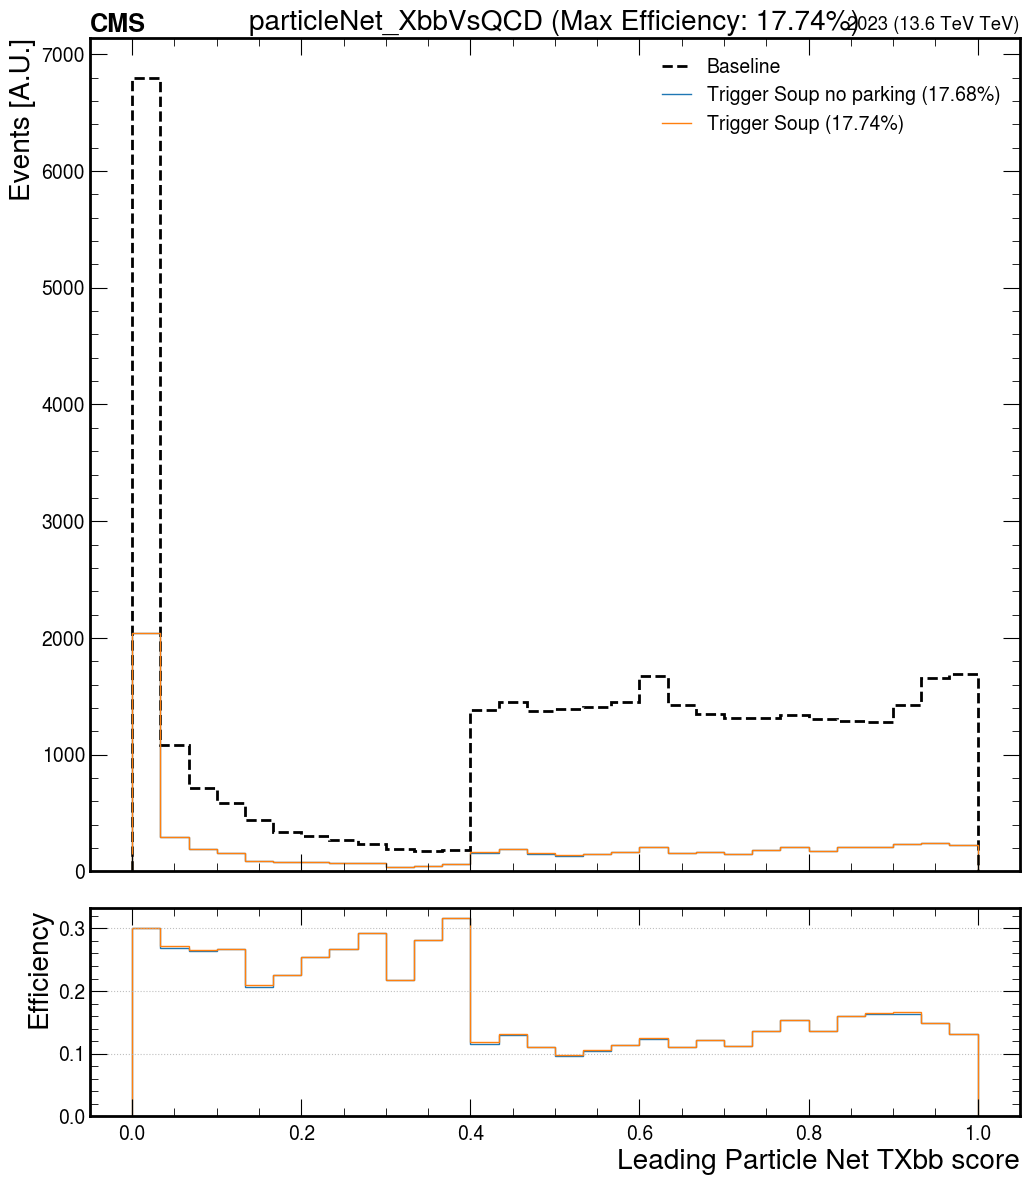

Processing period 2023BPix
Currently processing production mode JetData


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


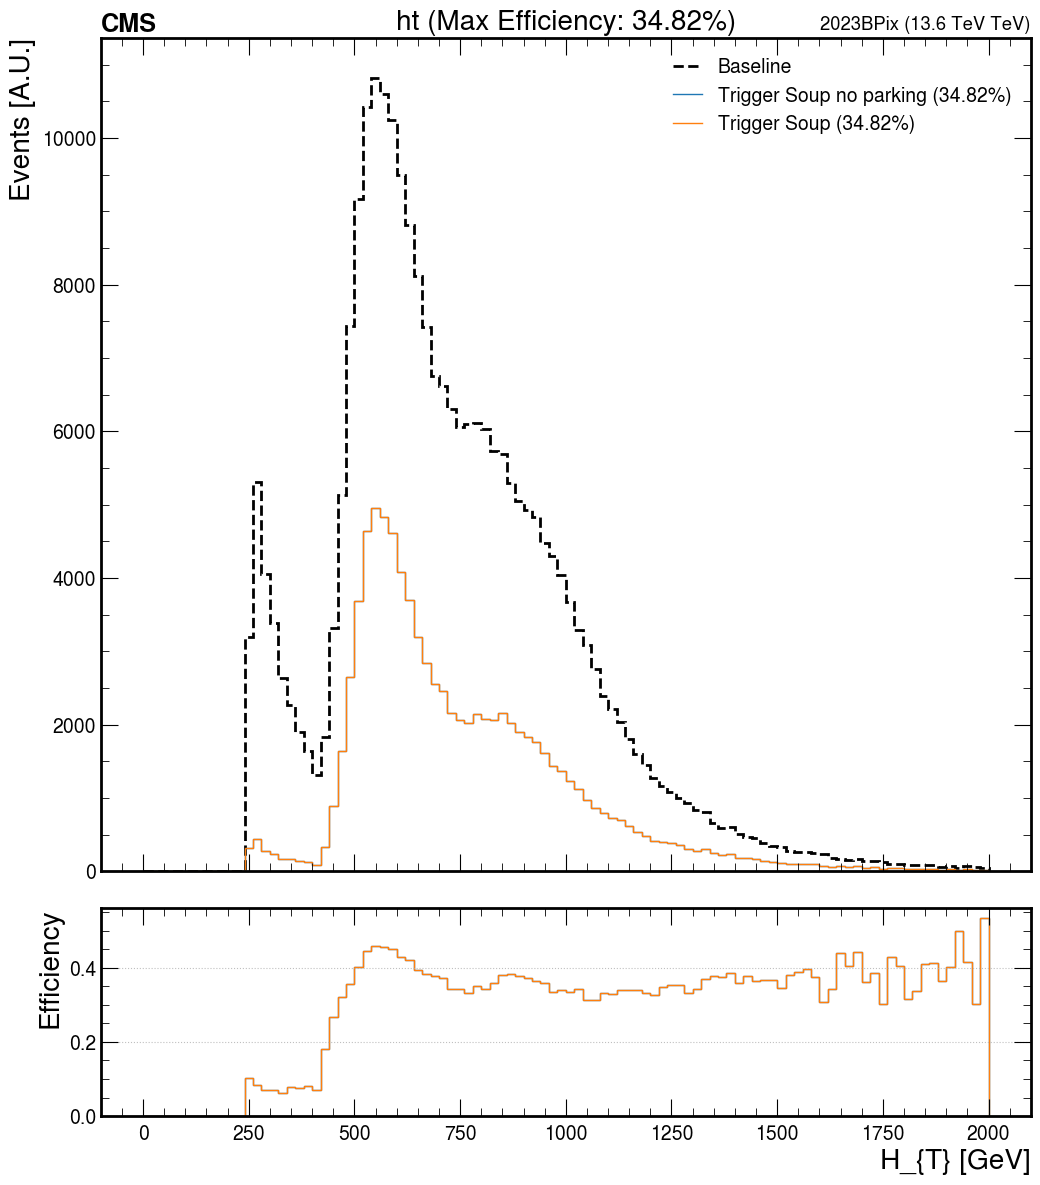

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


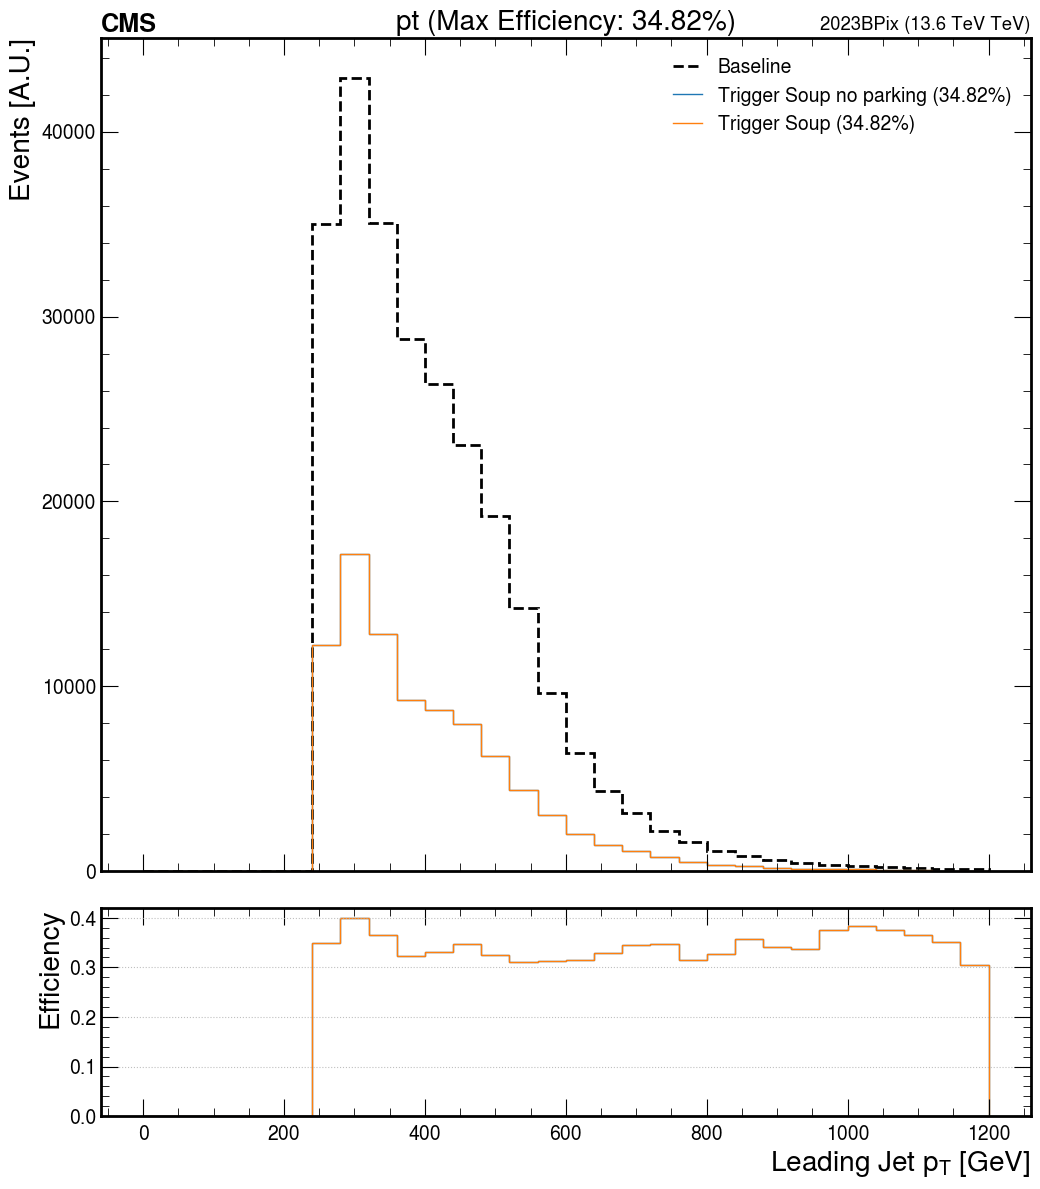

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


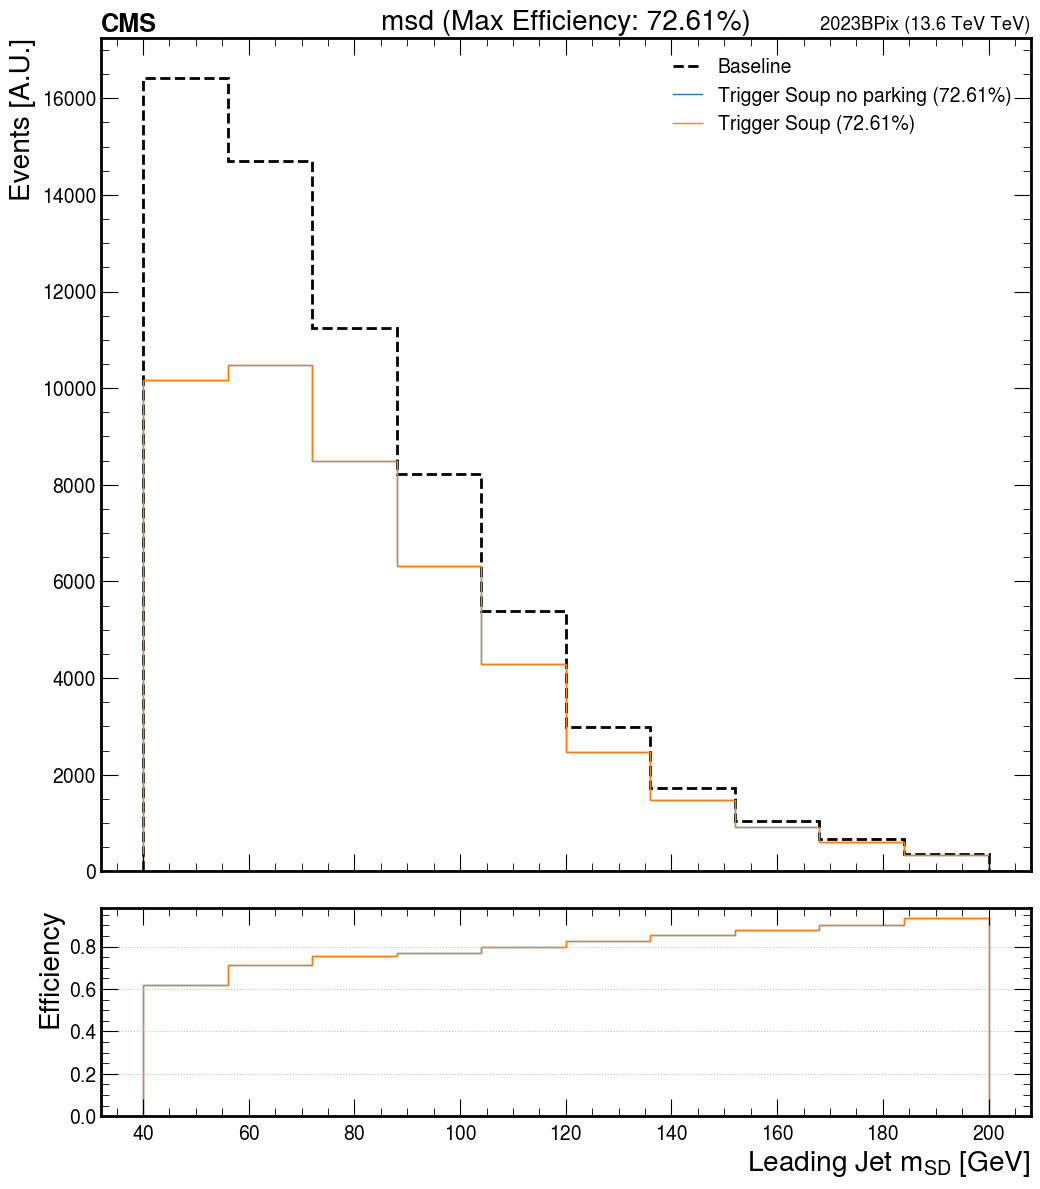

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


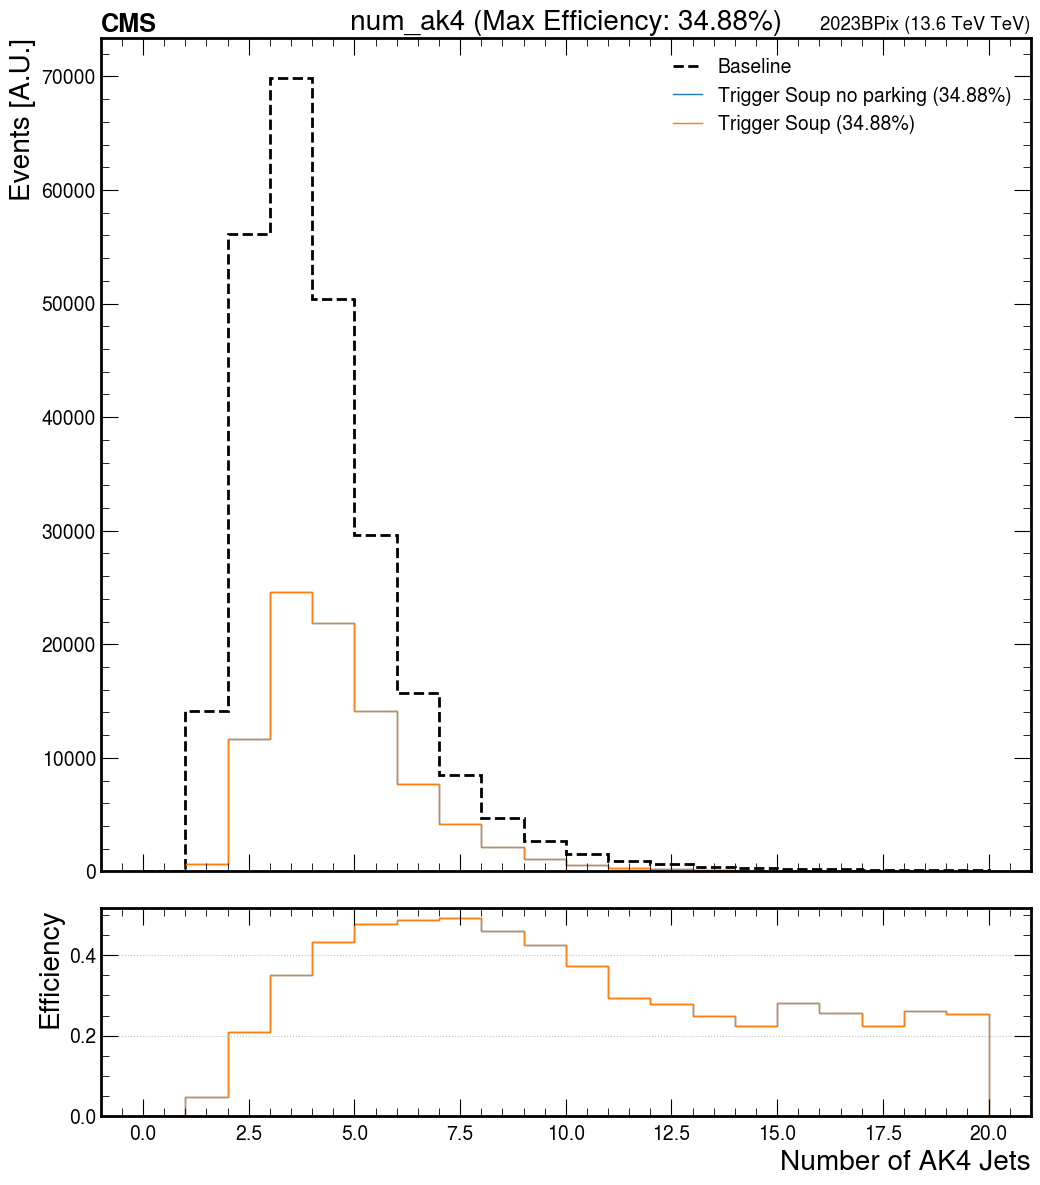

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


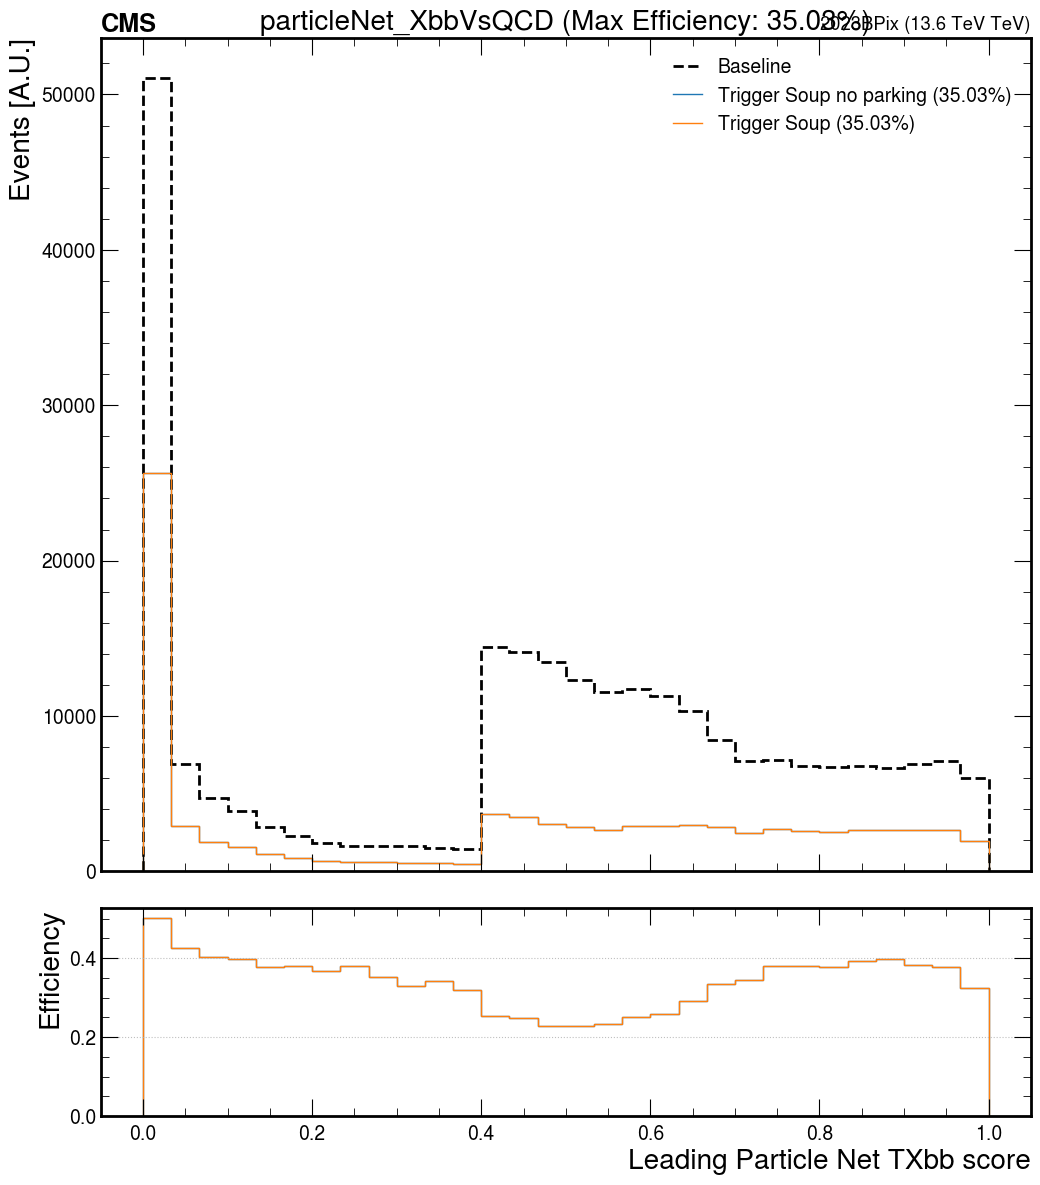

Currently processing production mode MuonData


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


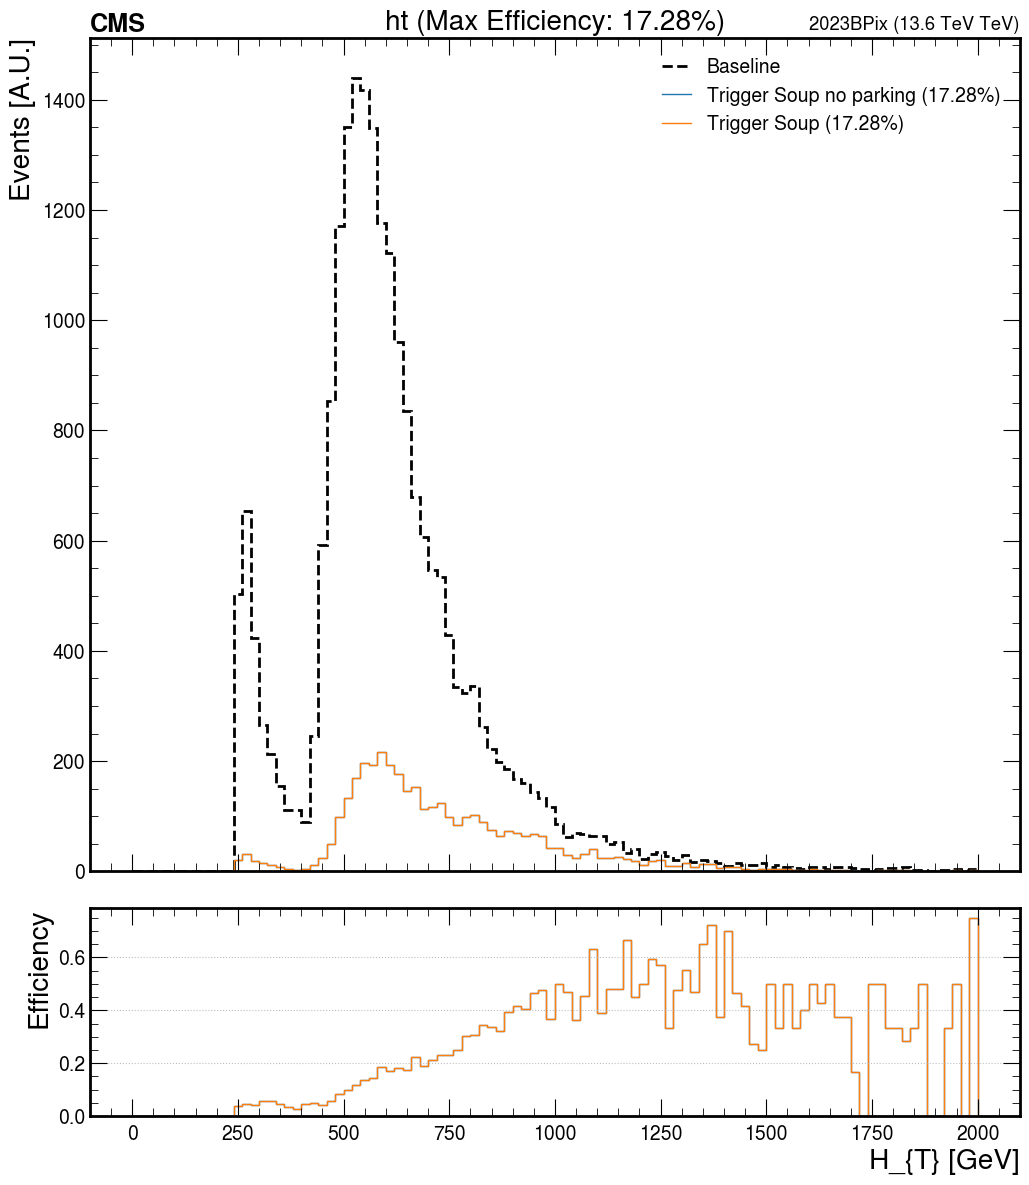

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


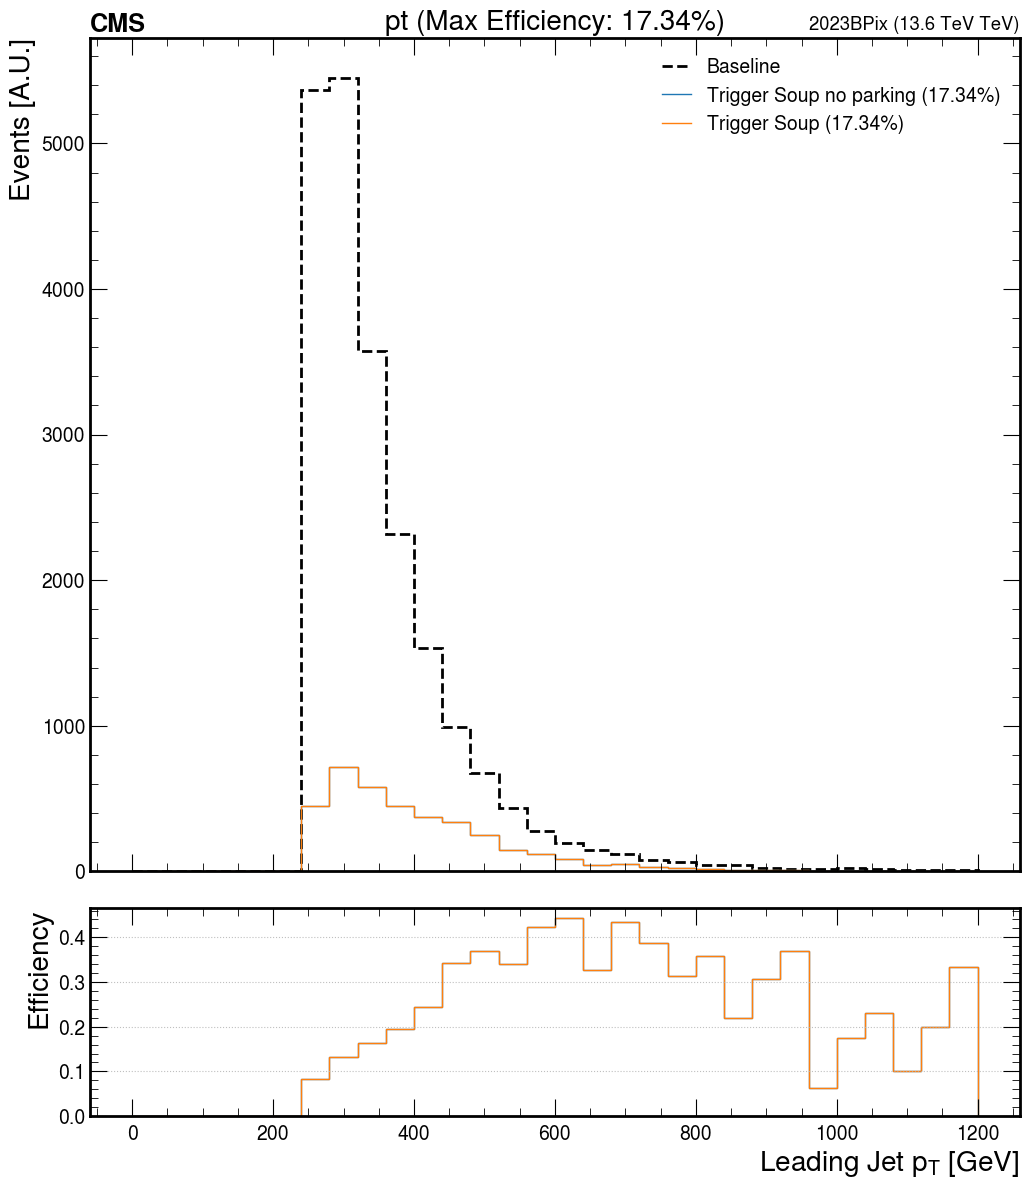

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


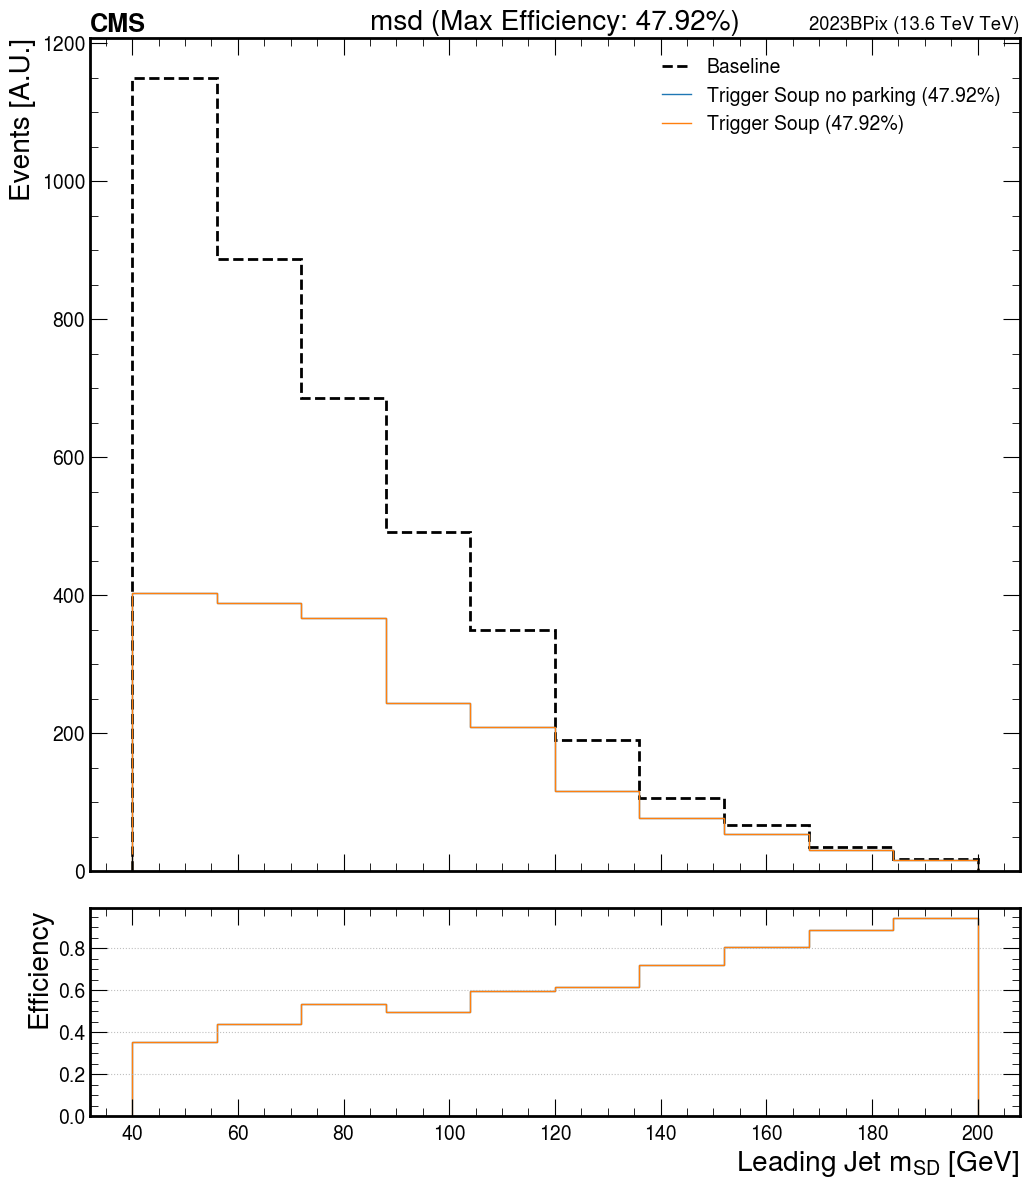

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


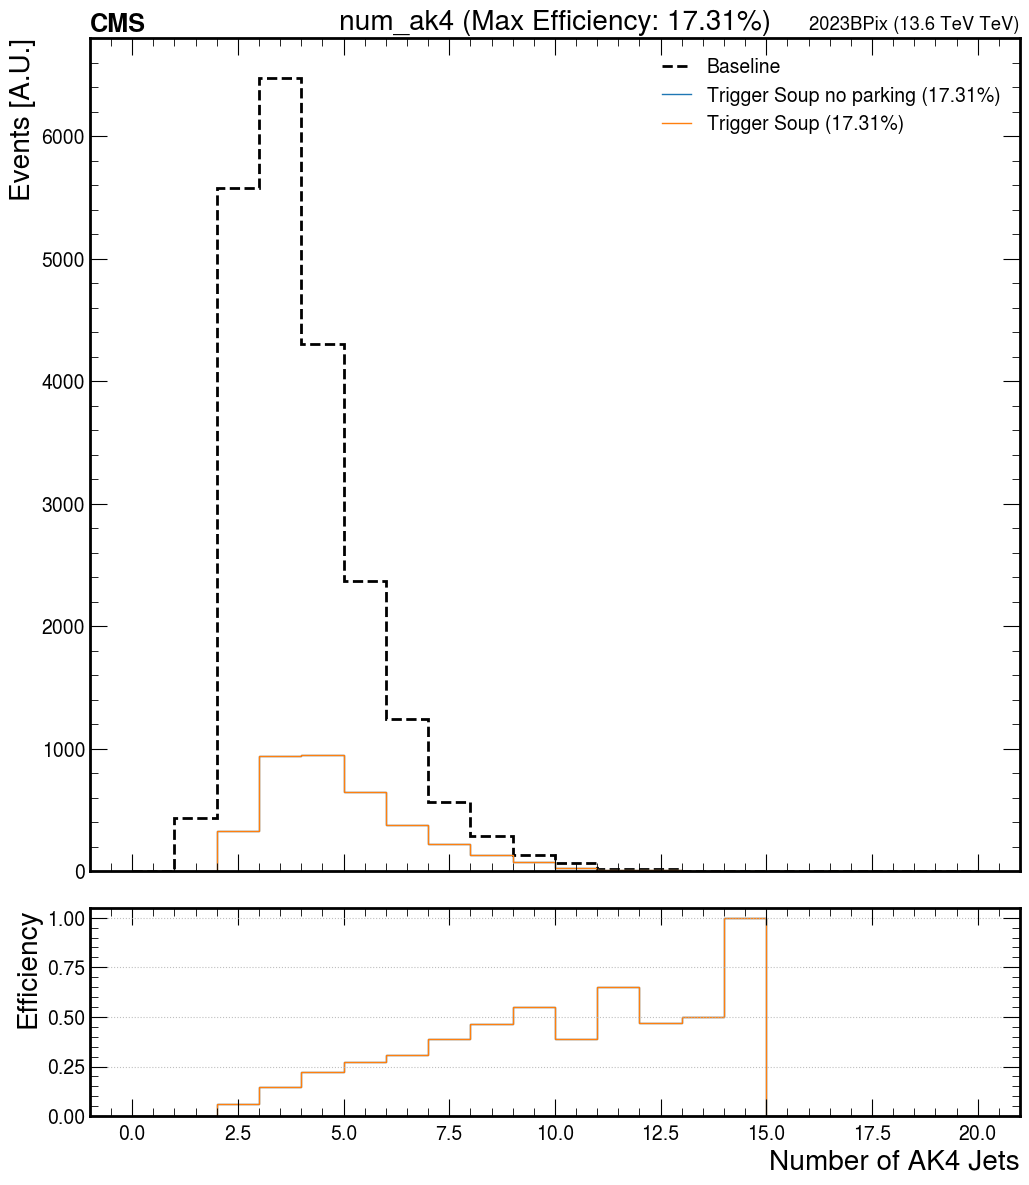

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


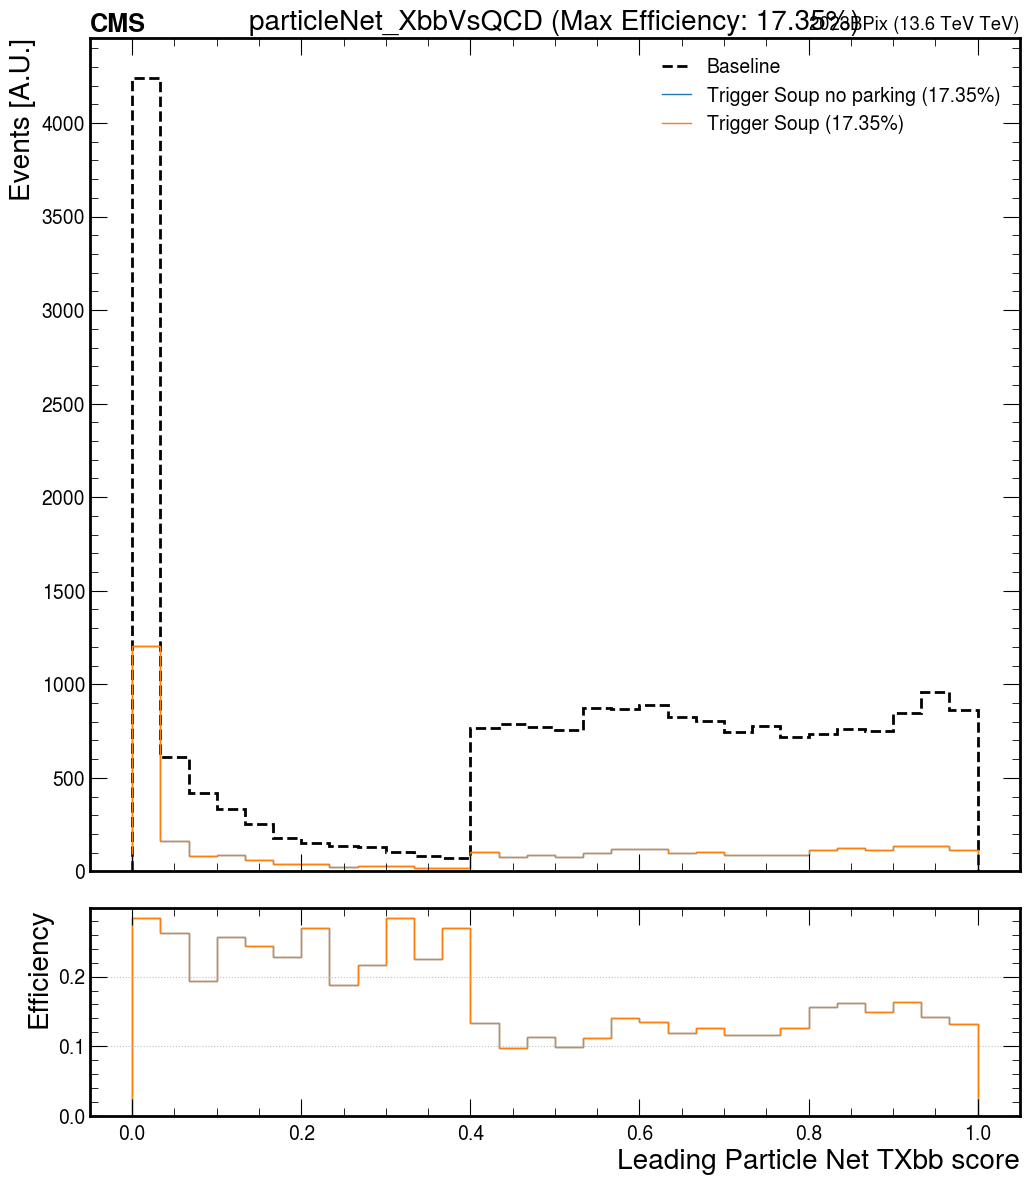

Processing period 2022EE
Currently processing production mode JetData


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


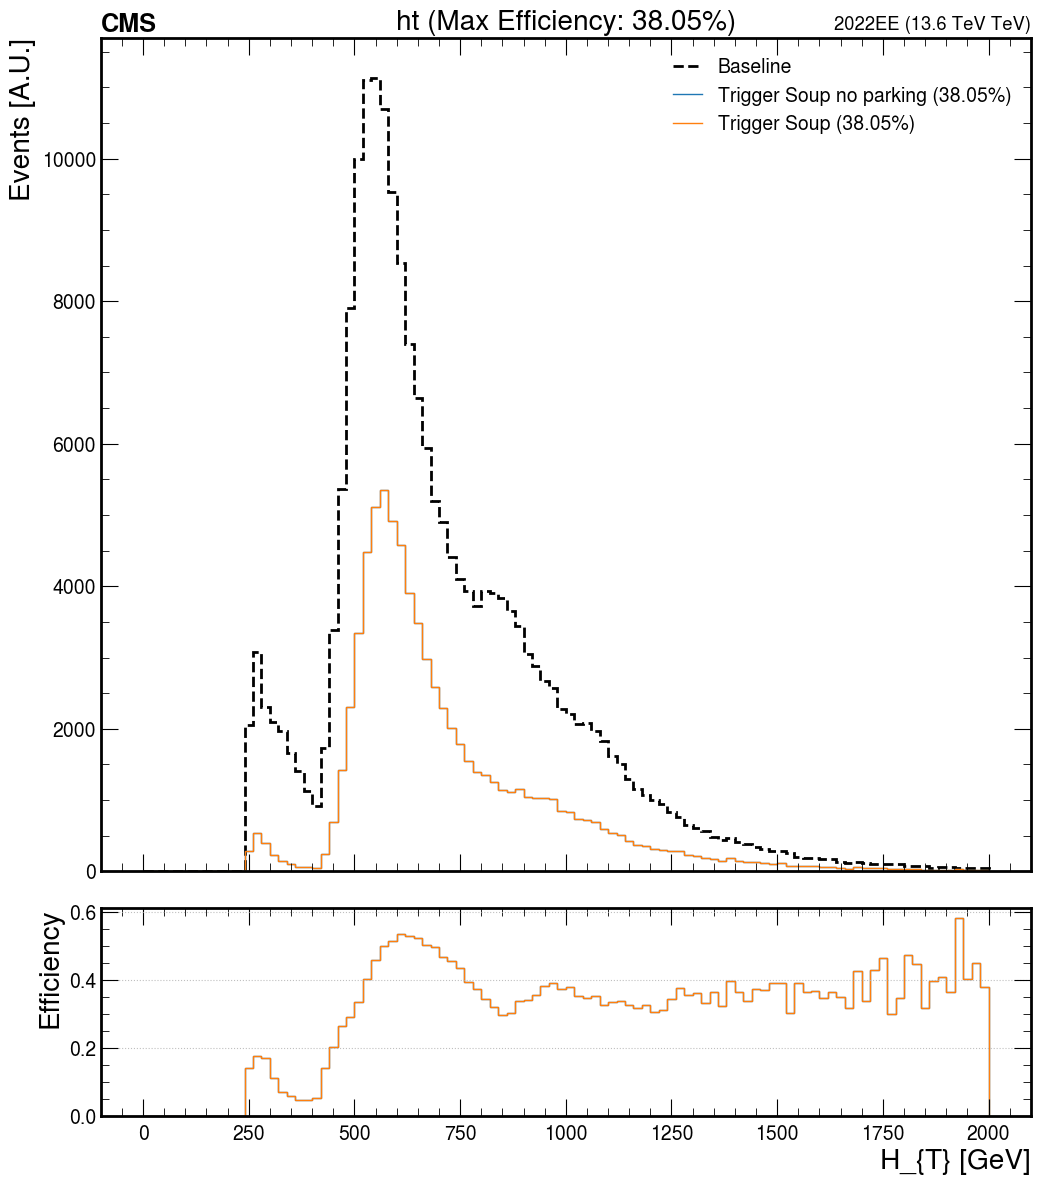

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


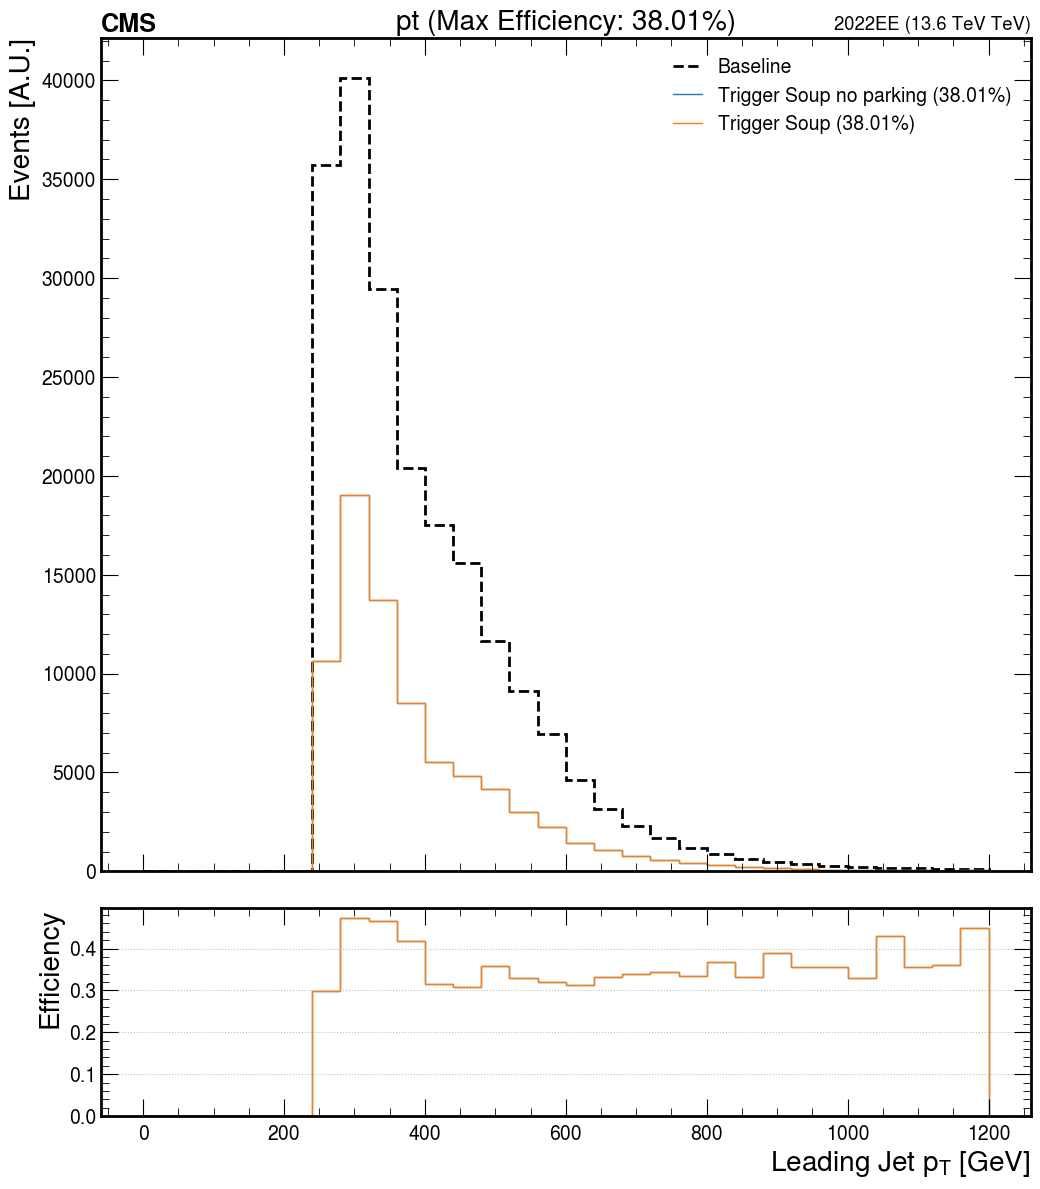

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


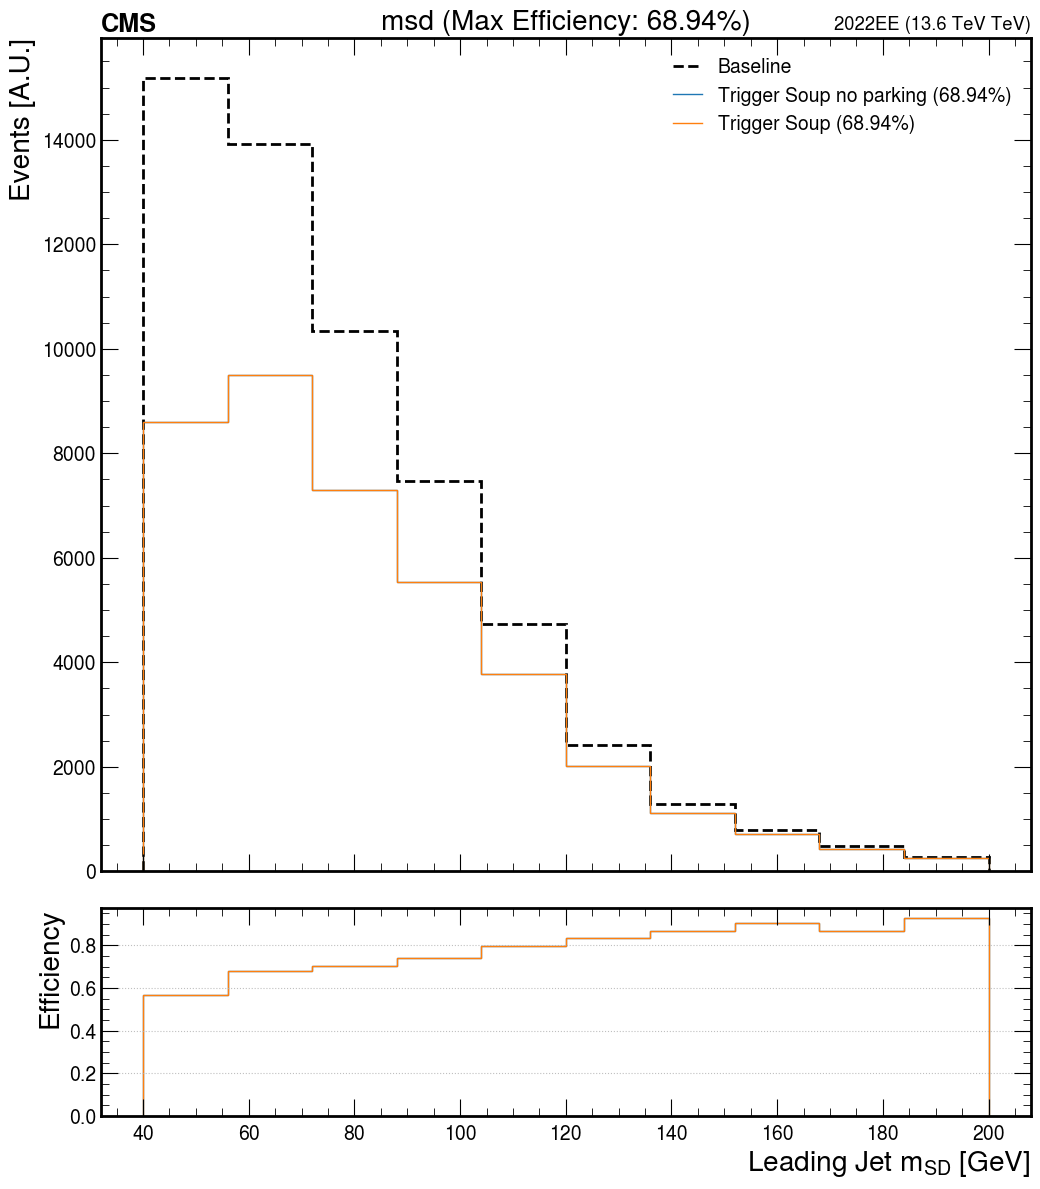

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


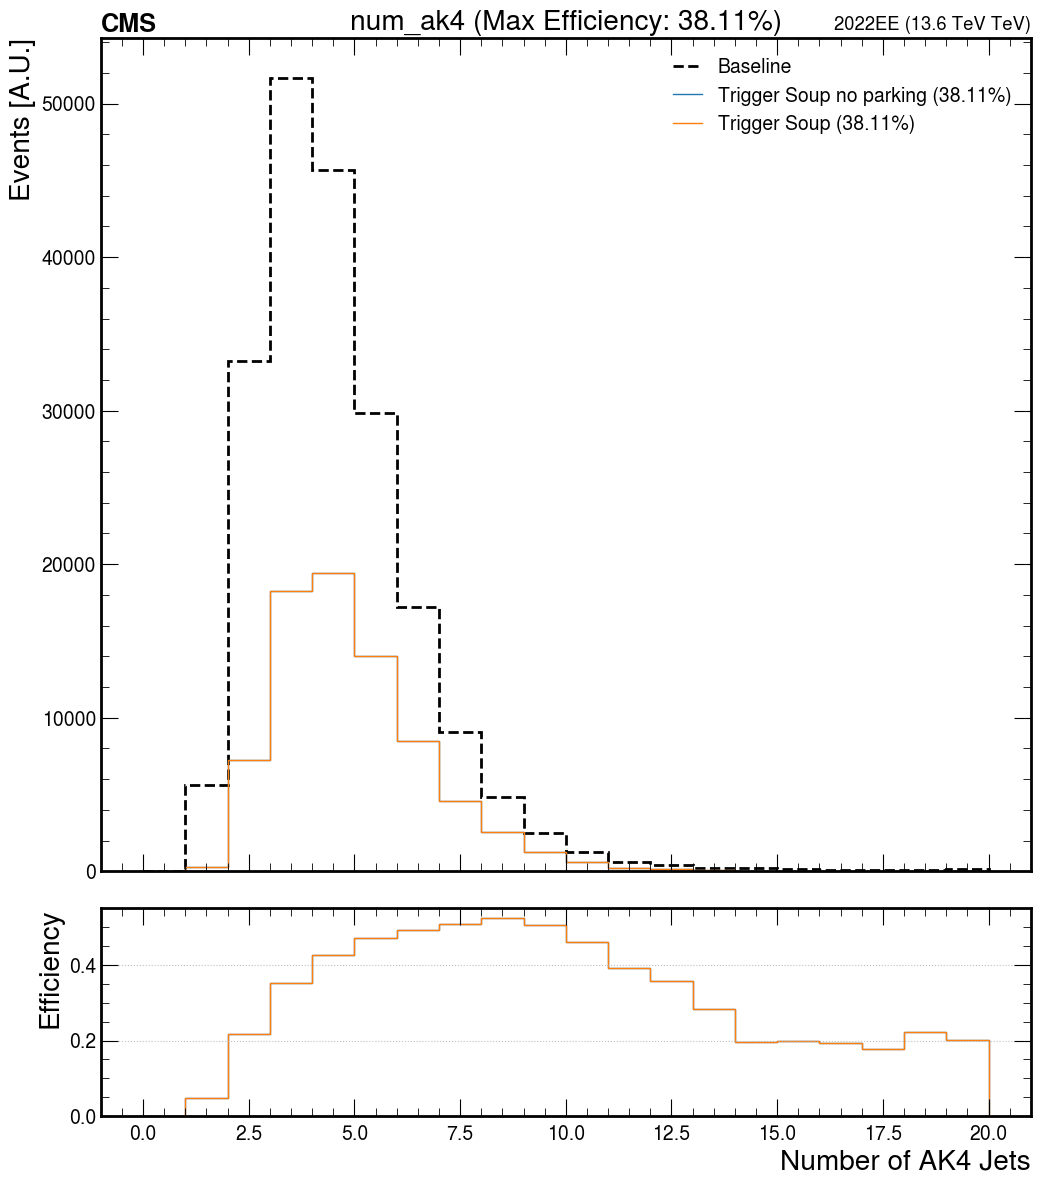

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


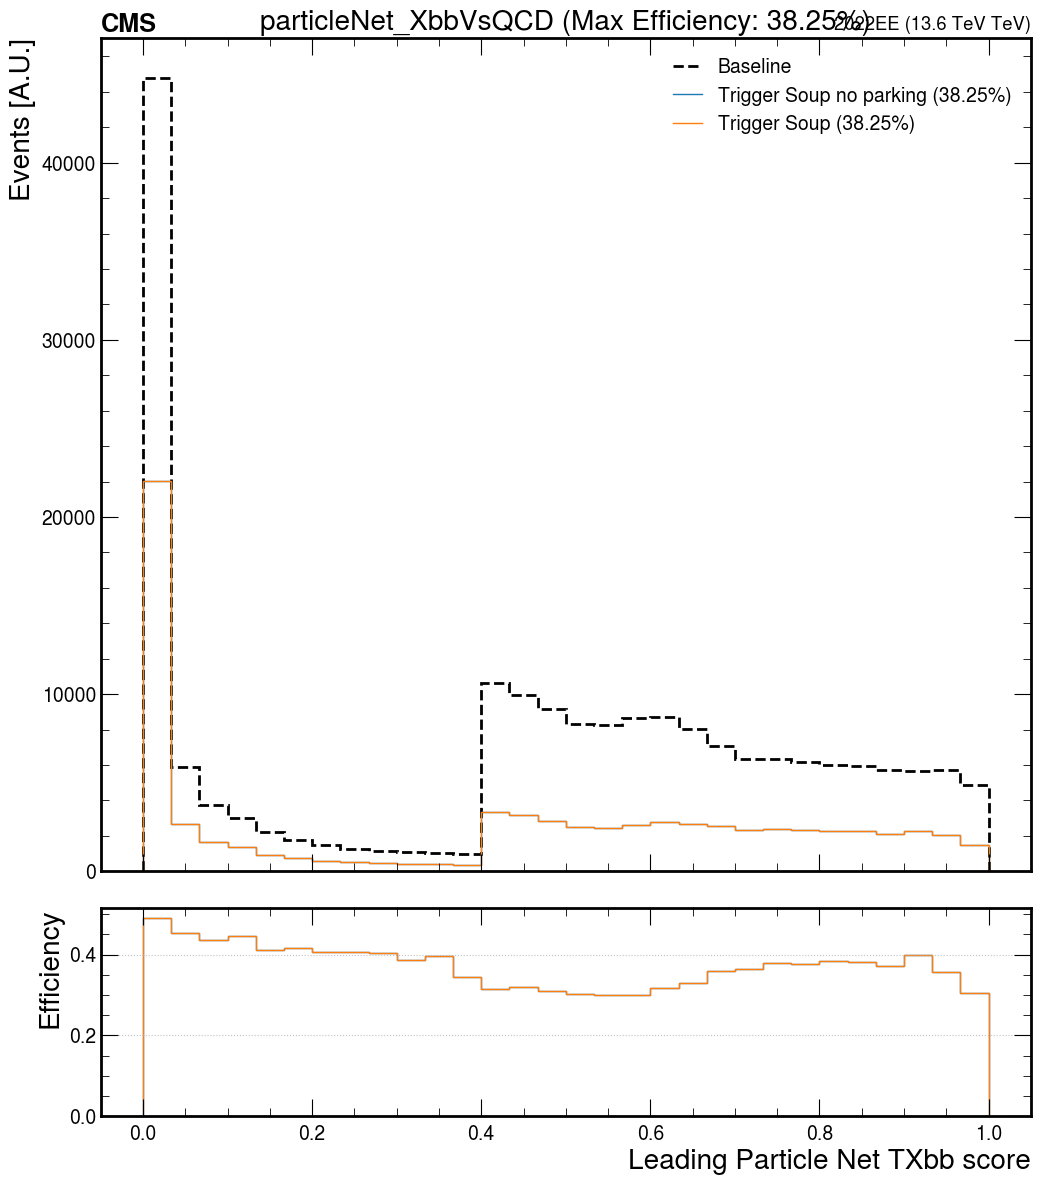

Currently processing production mode MuonData


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


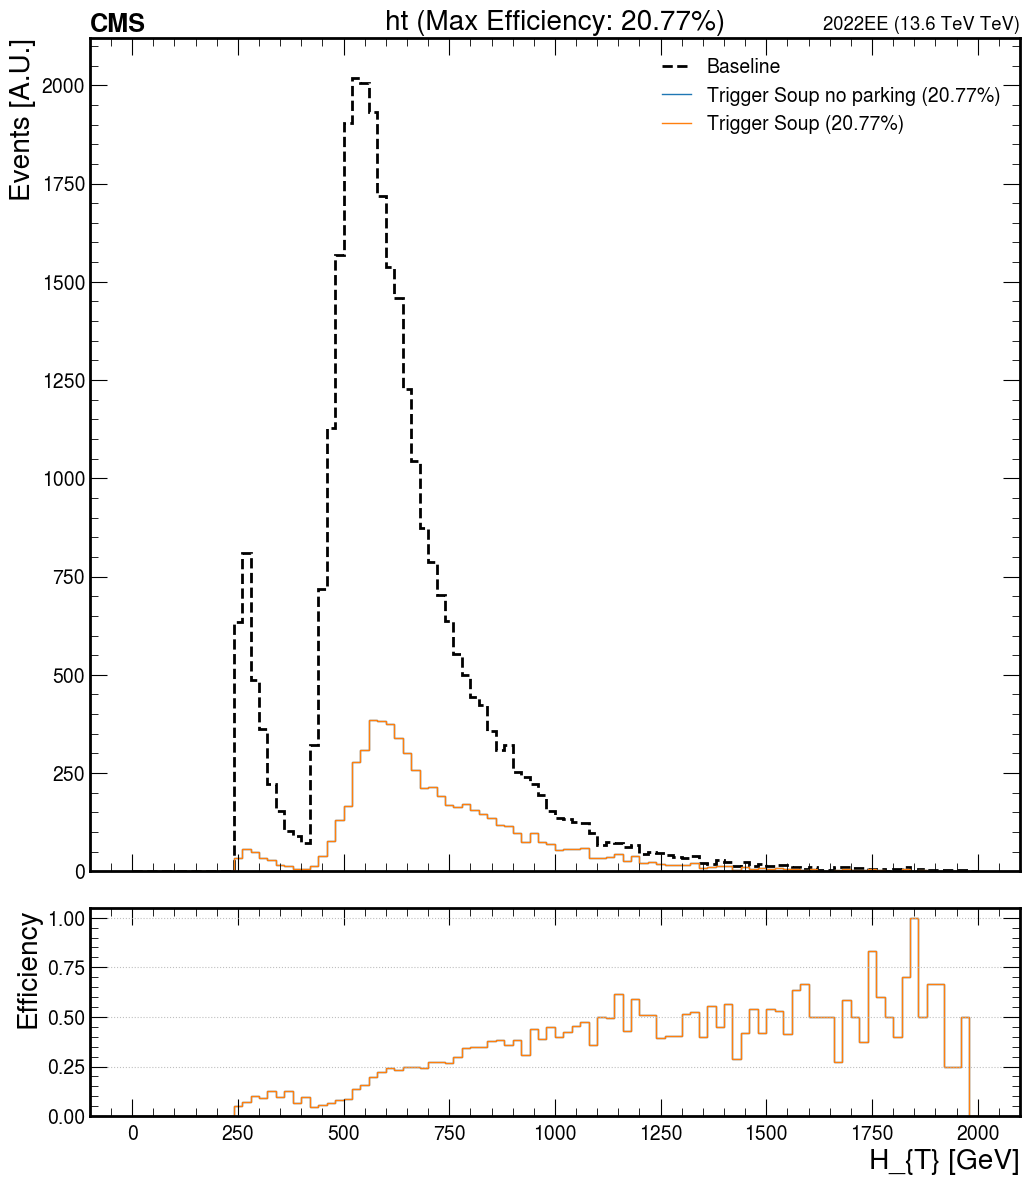

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


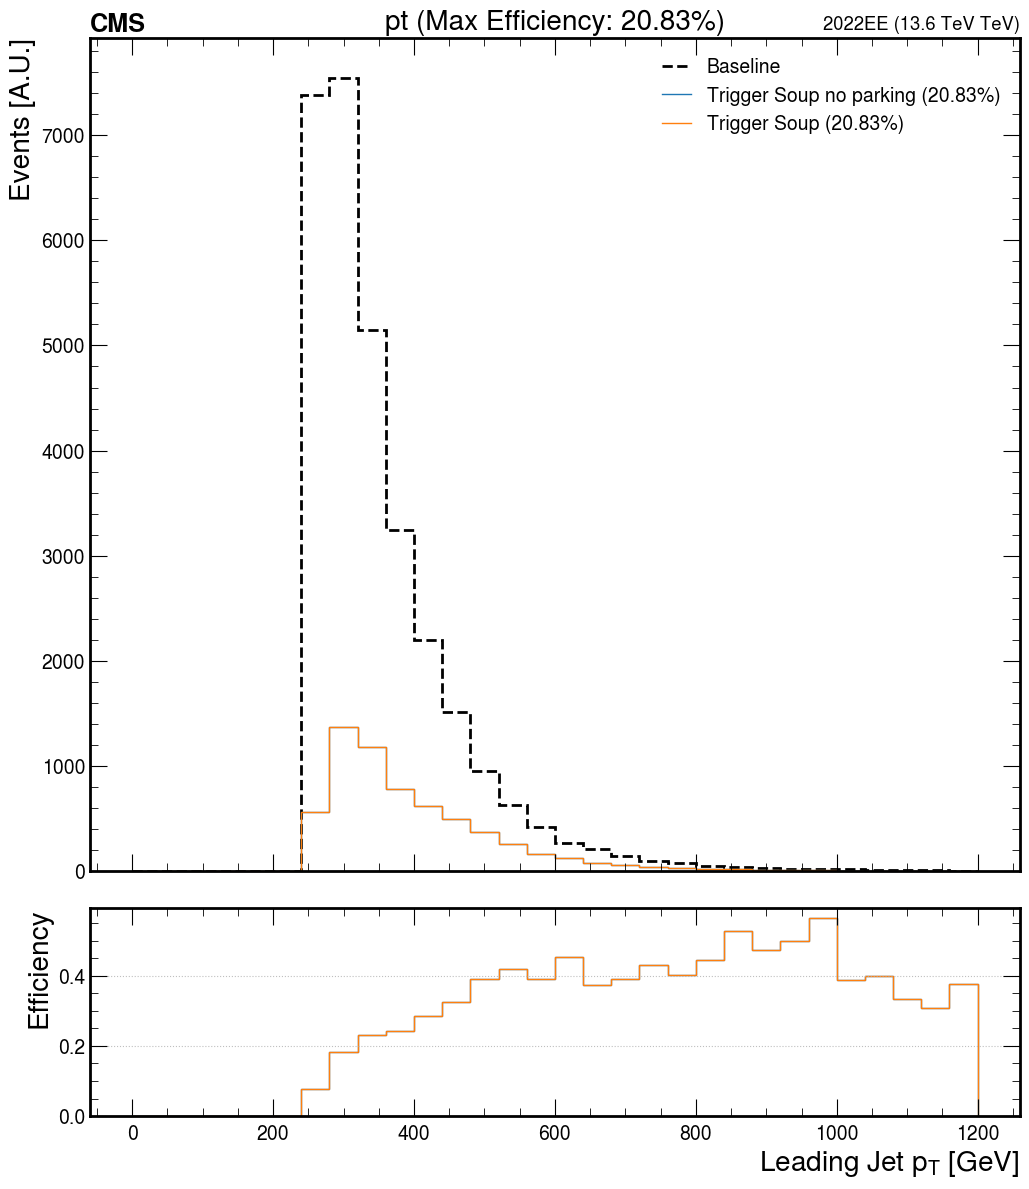

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


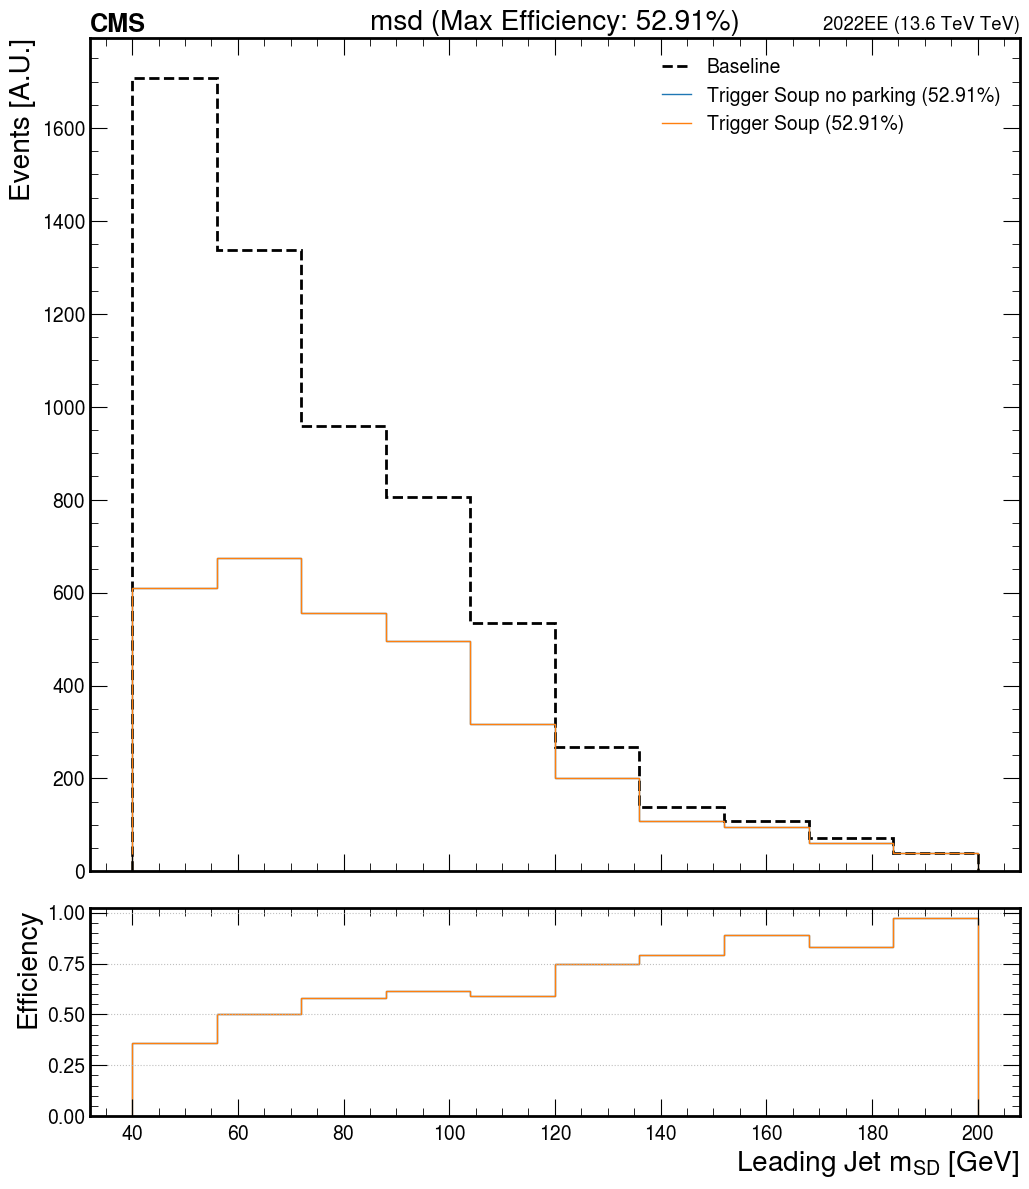

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


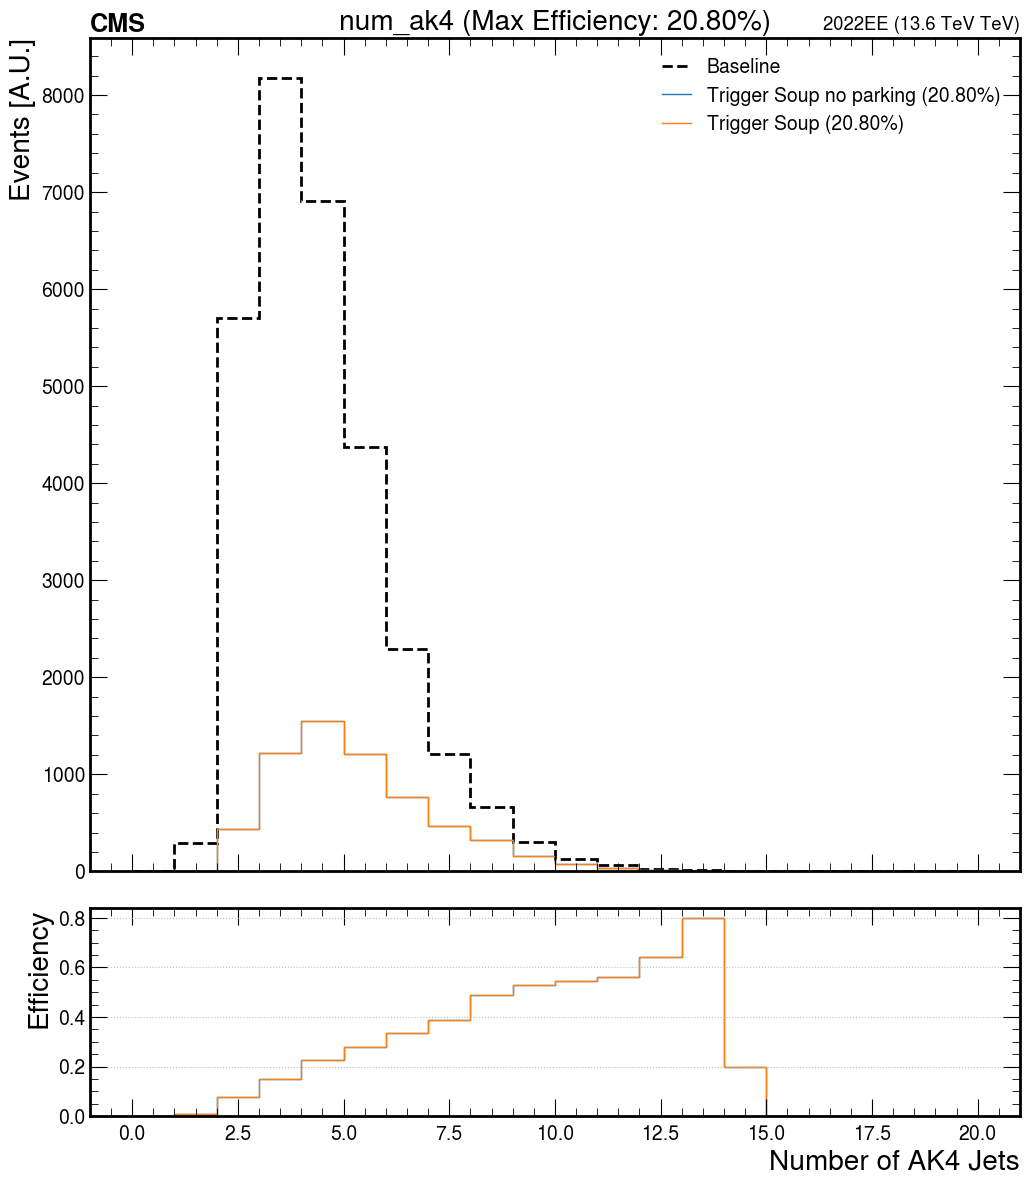

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


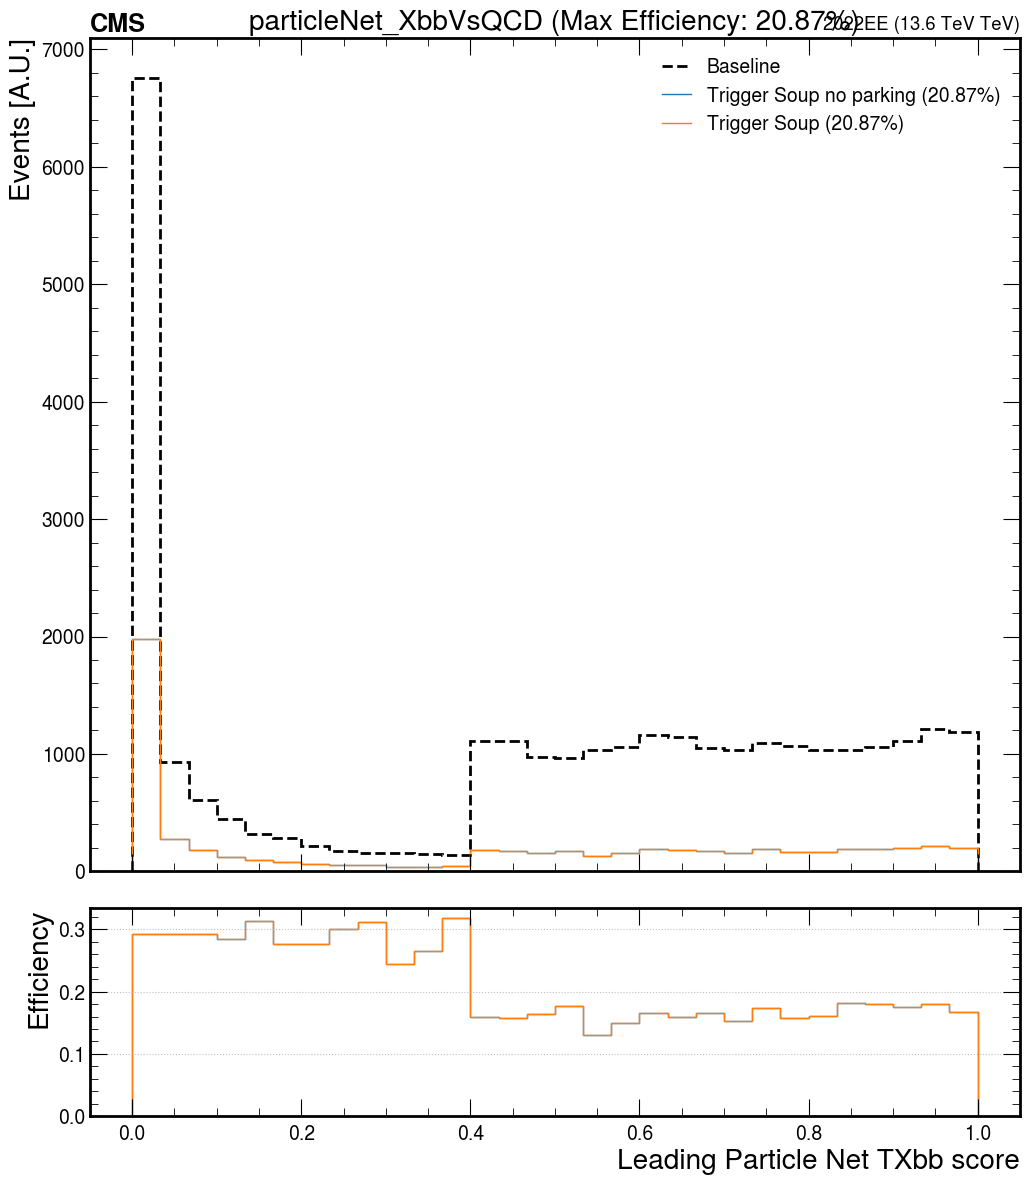

Processing period 2022
Currently processing production mode JetData


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


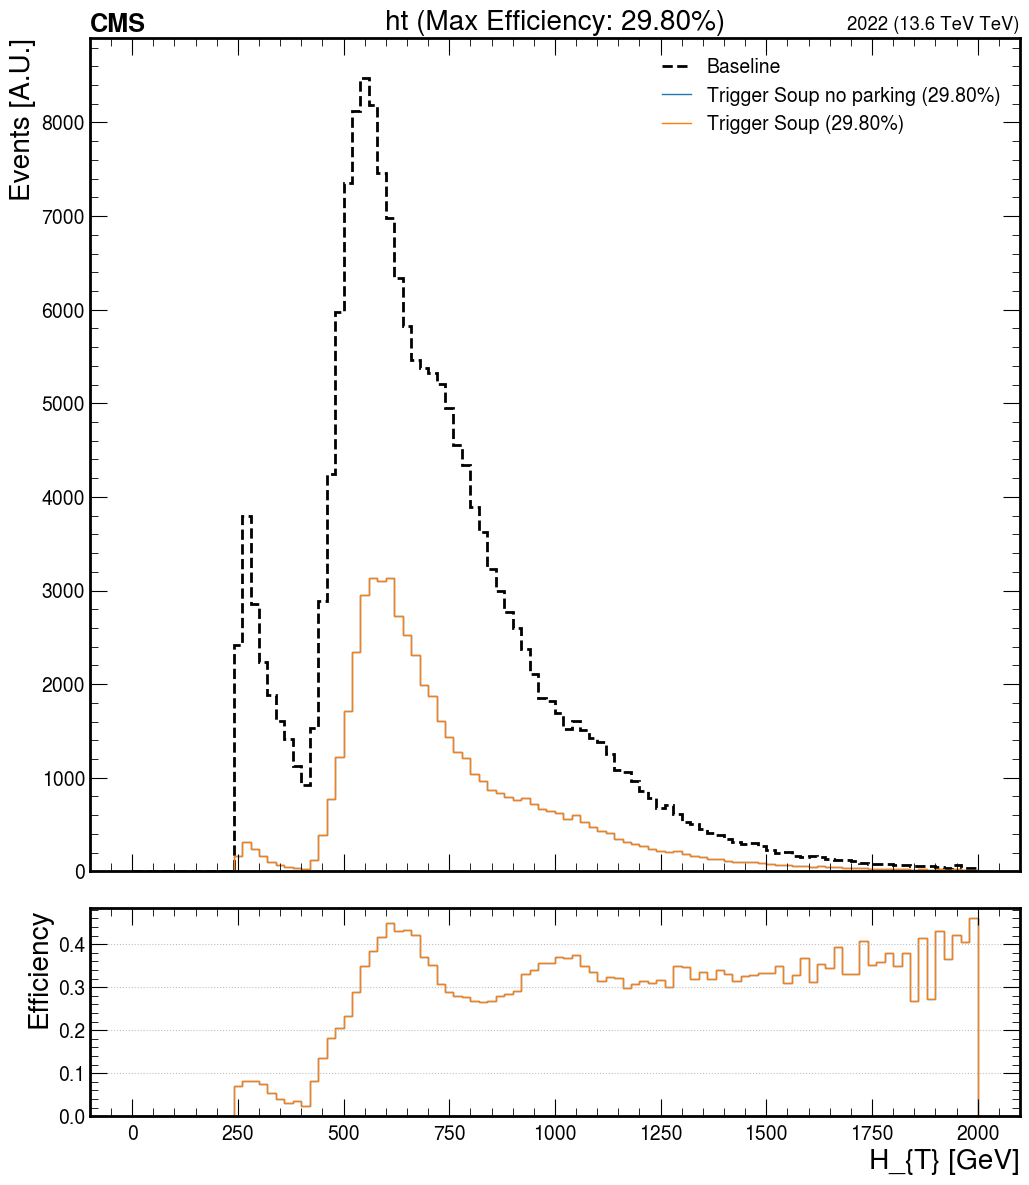

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


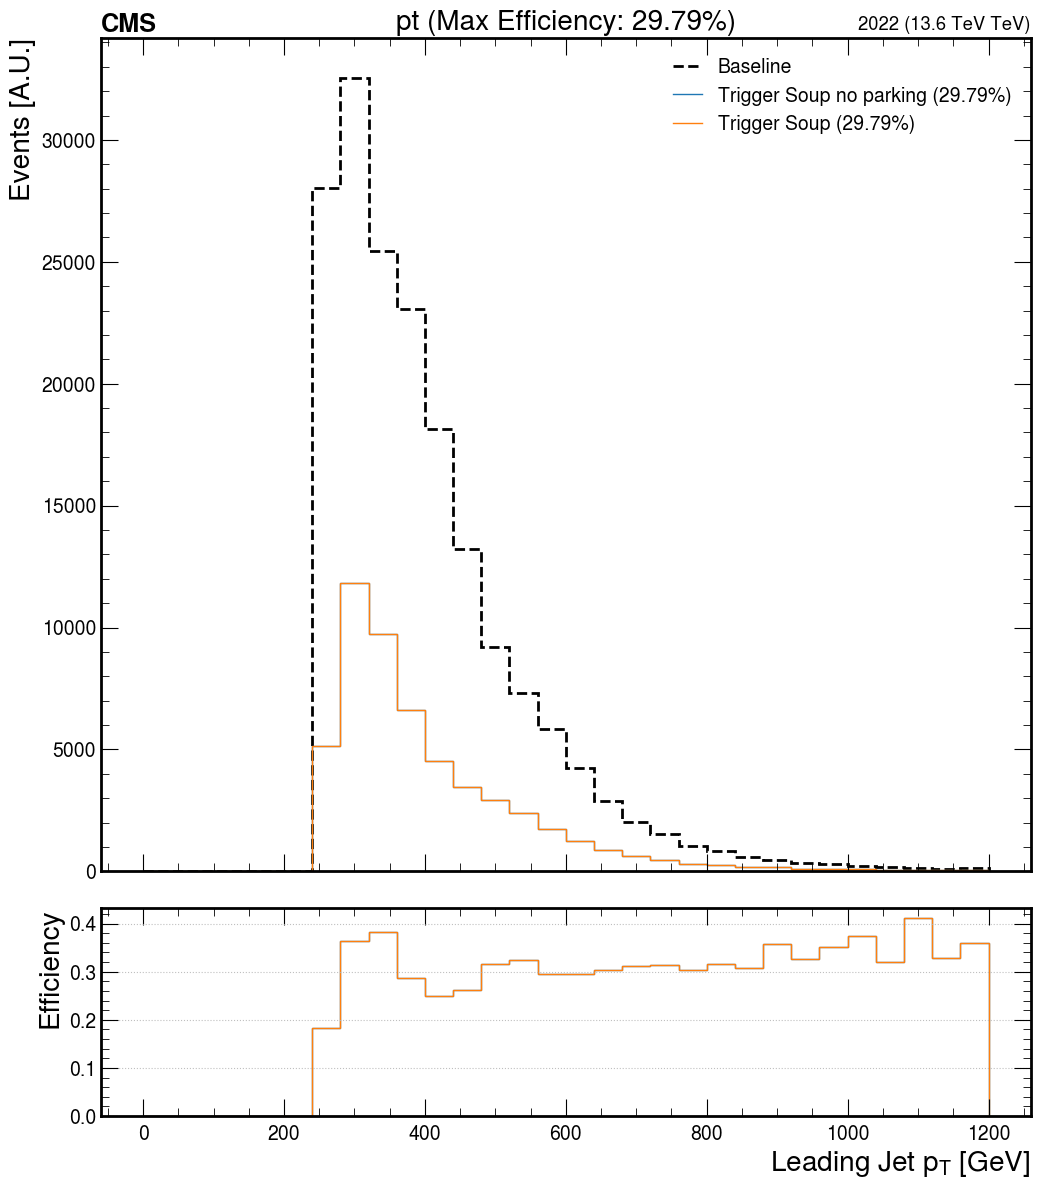

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


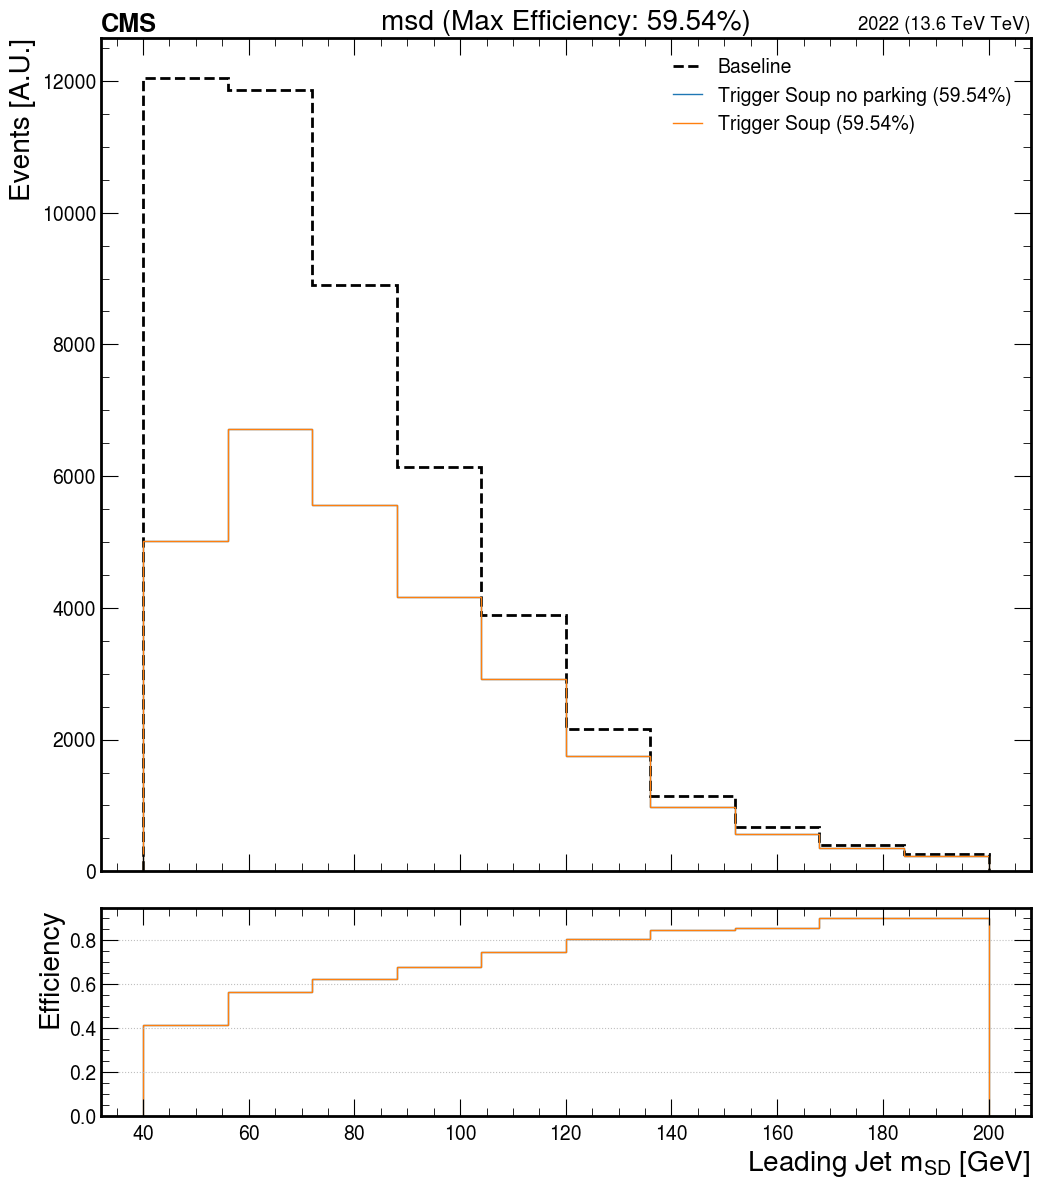

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


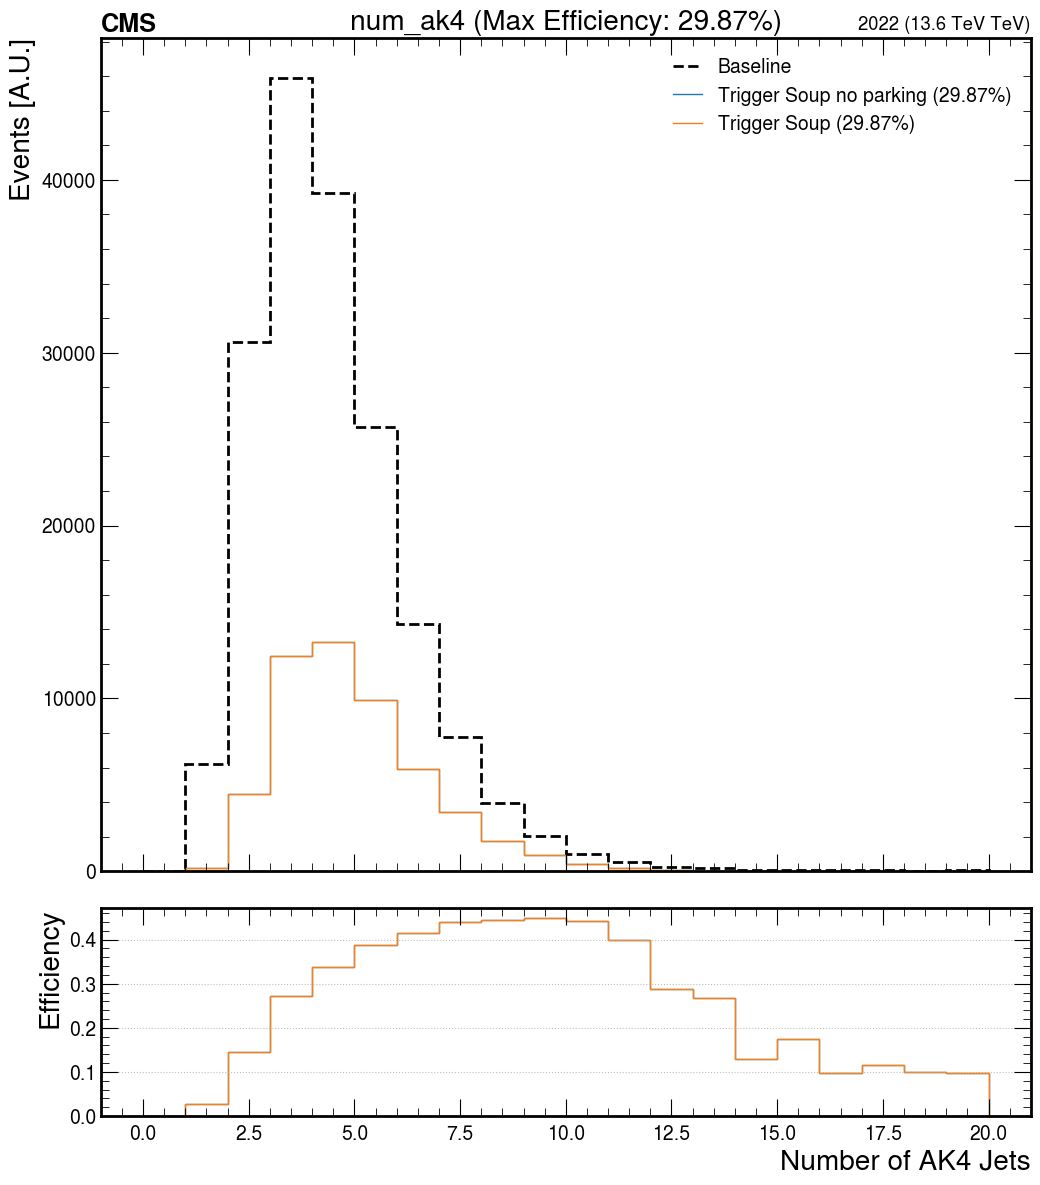

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


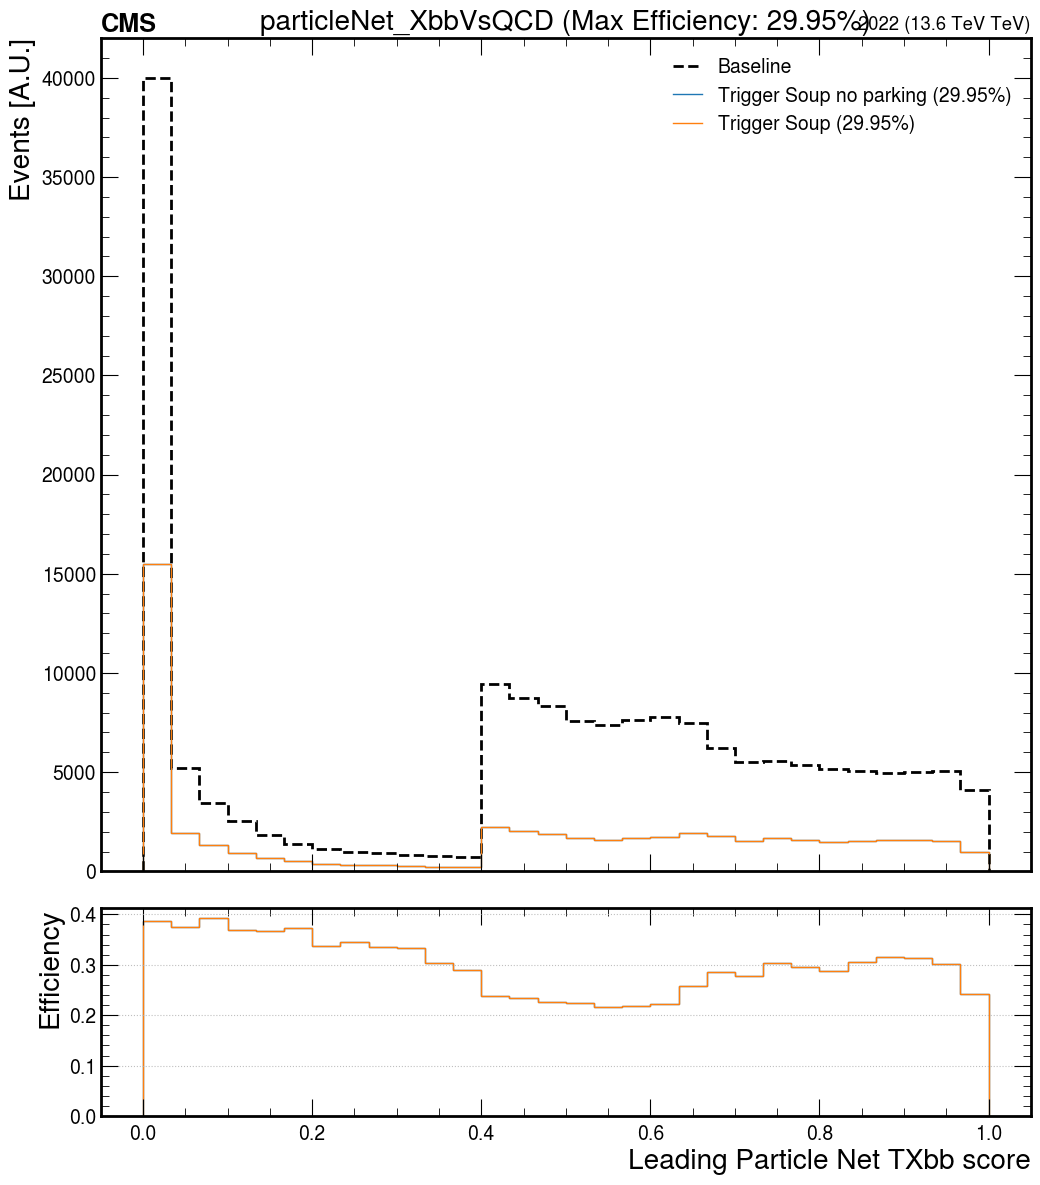

Currently processing production mode MuonData


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


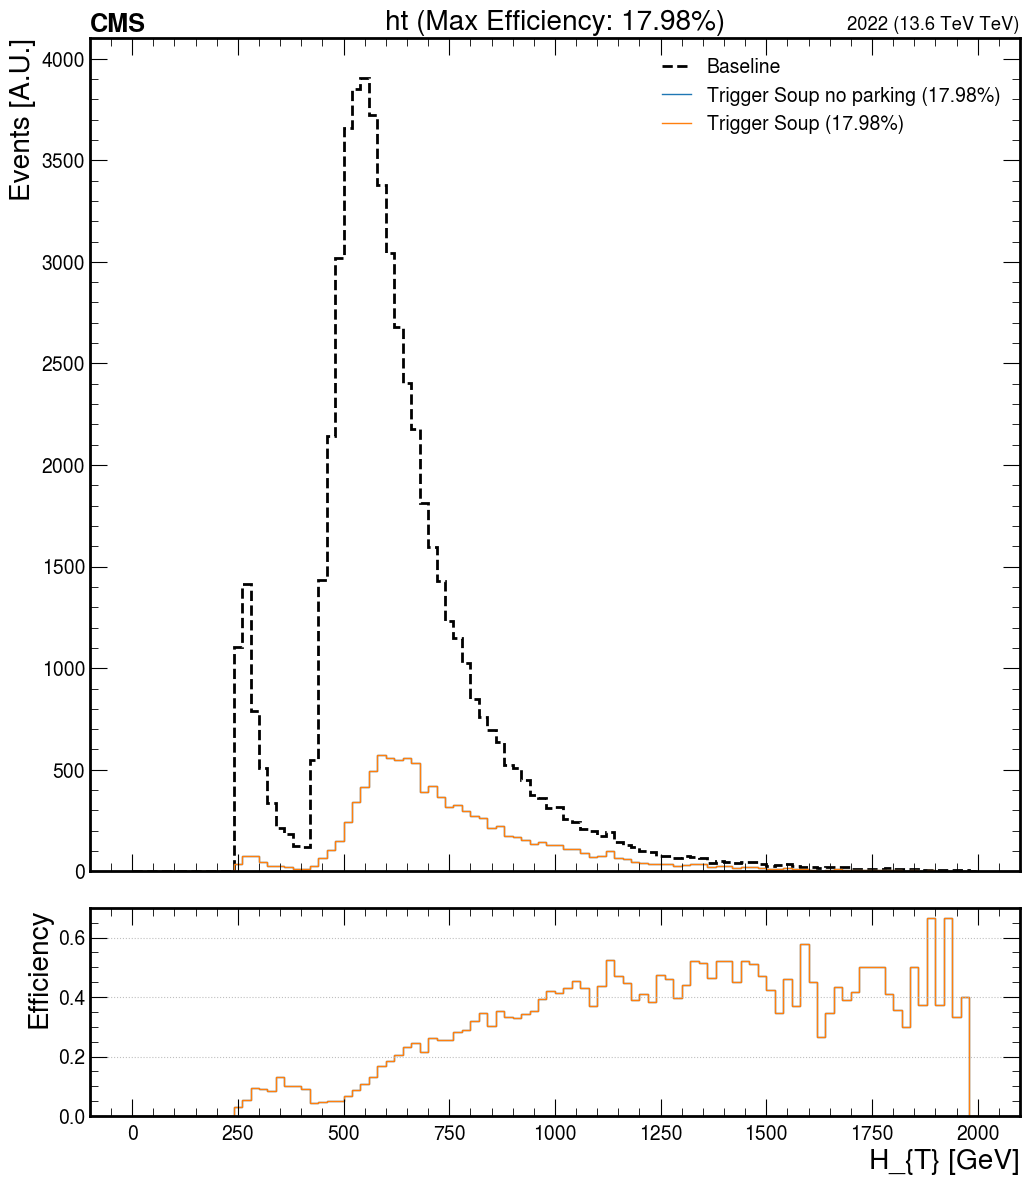

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


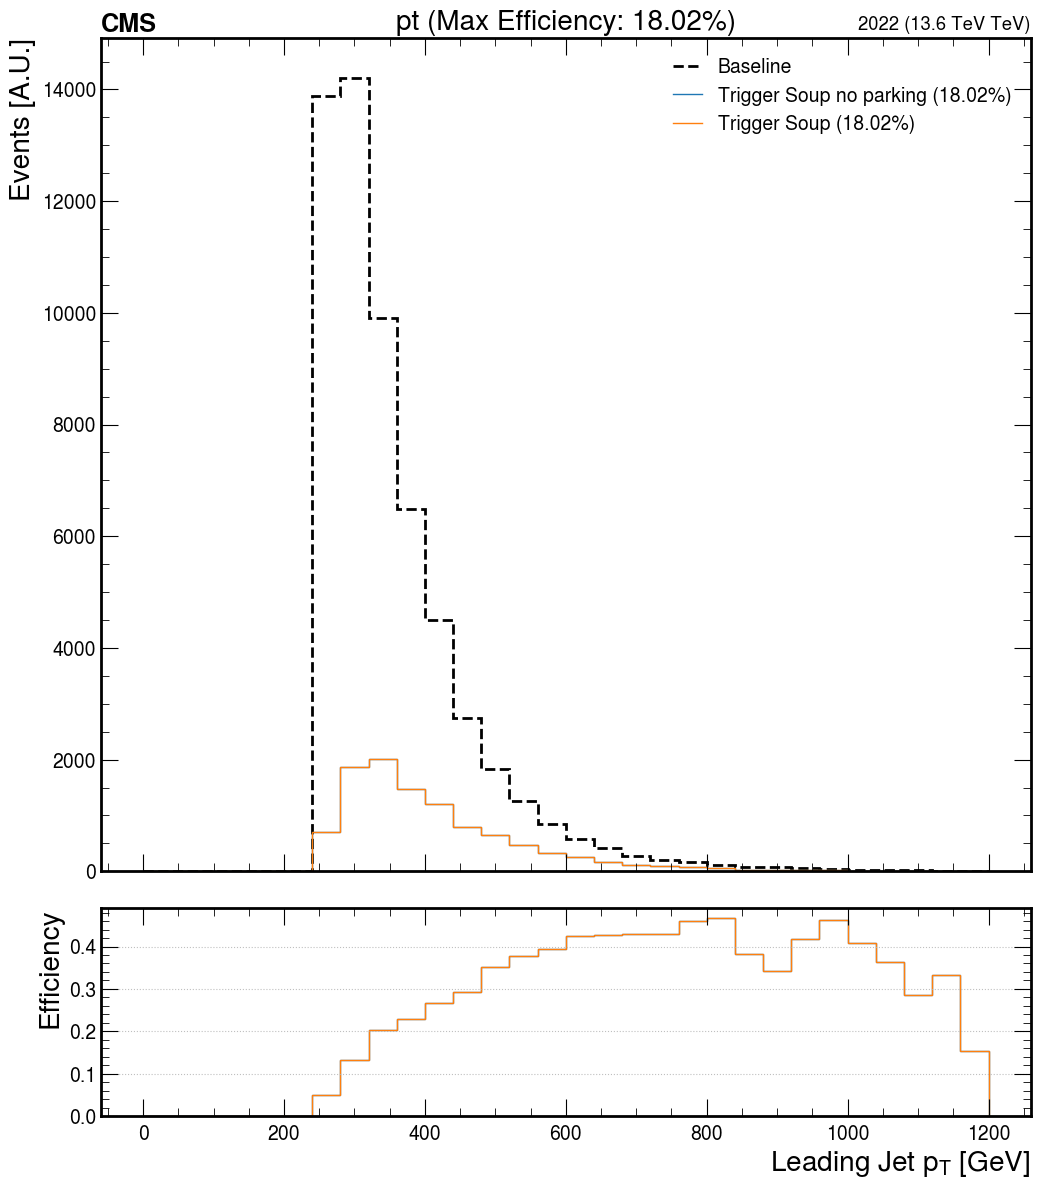

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


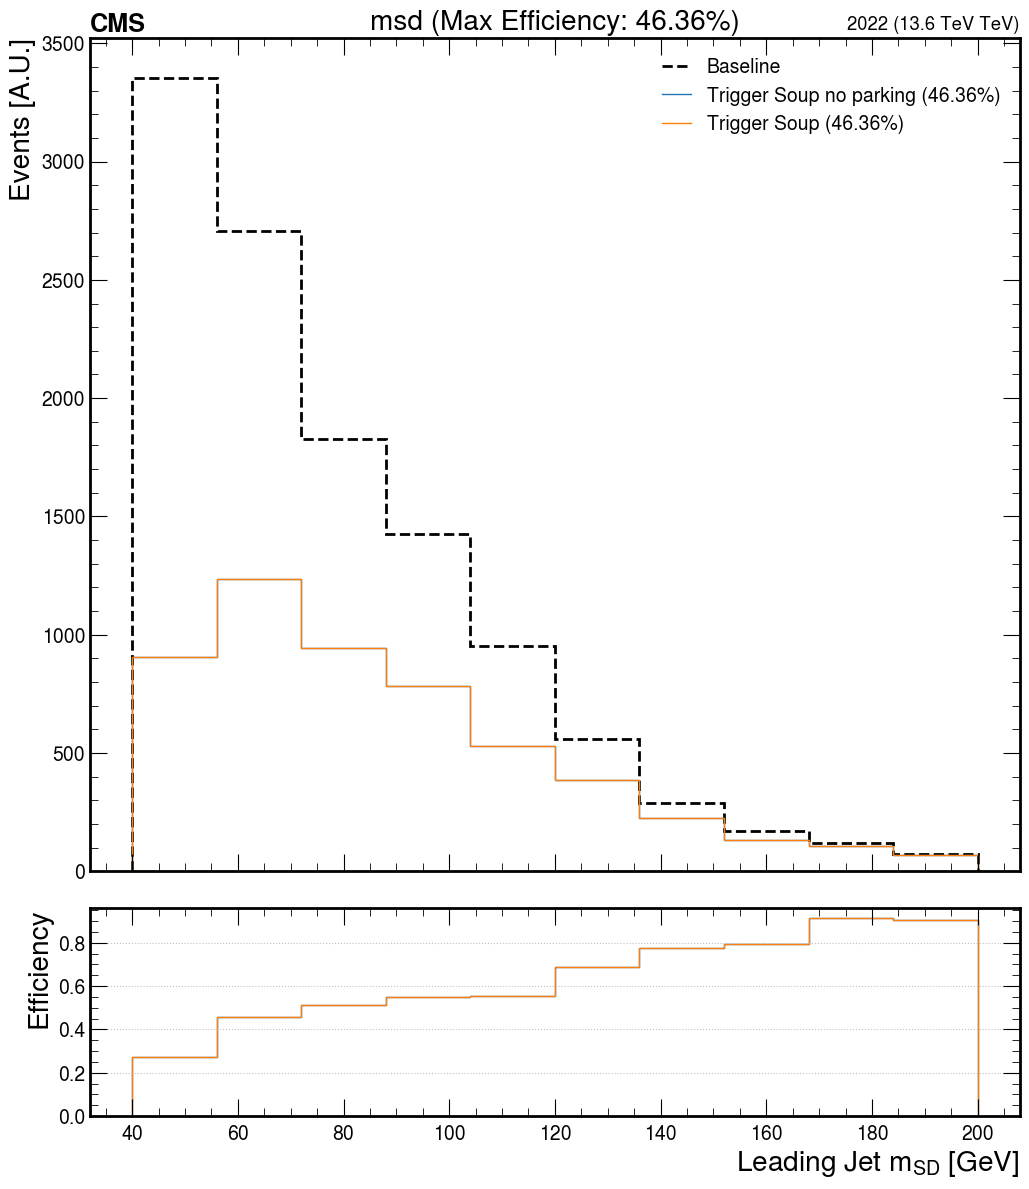

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


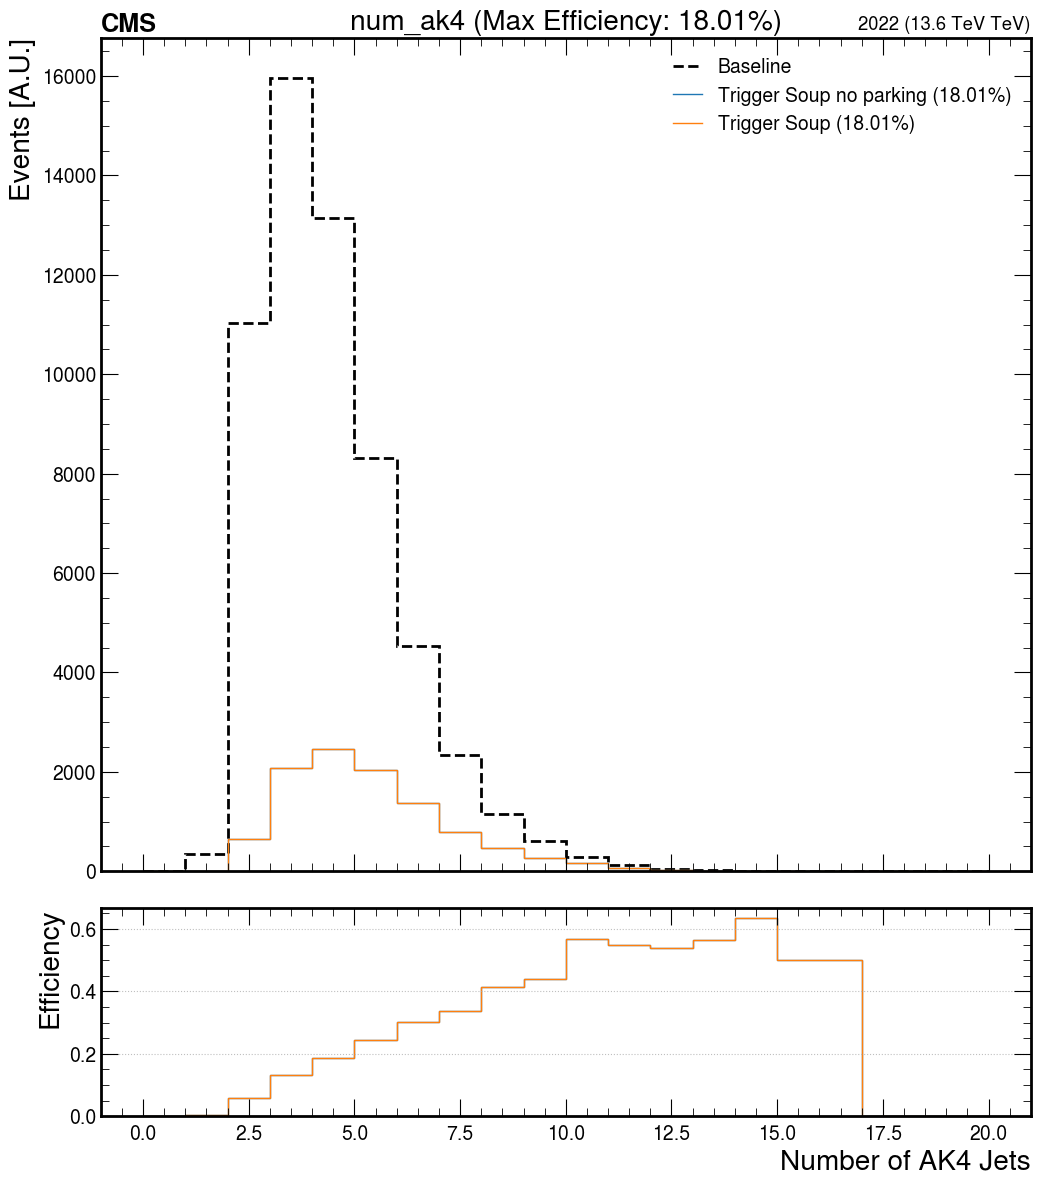

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


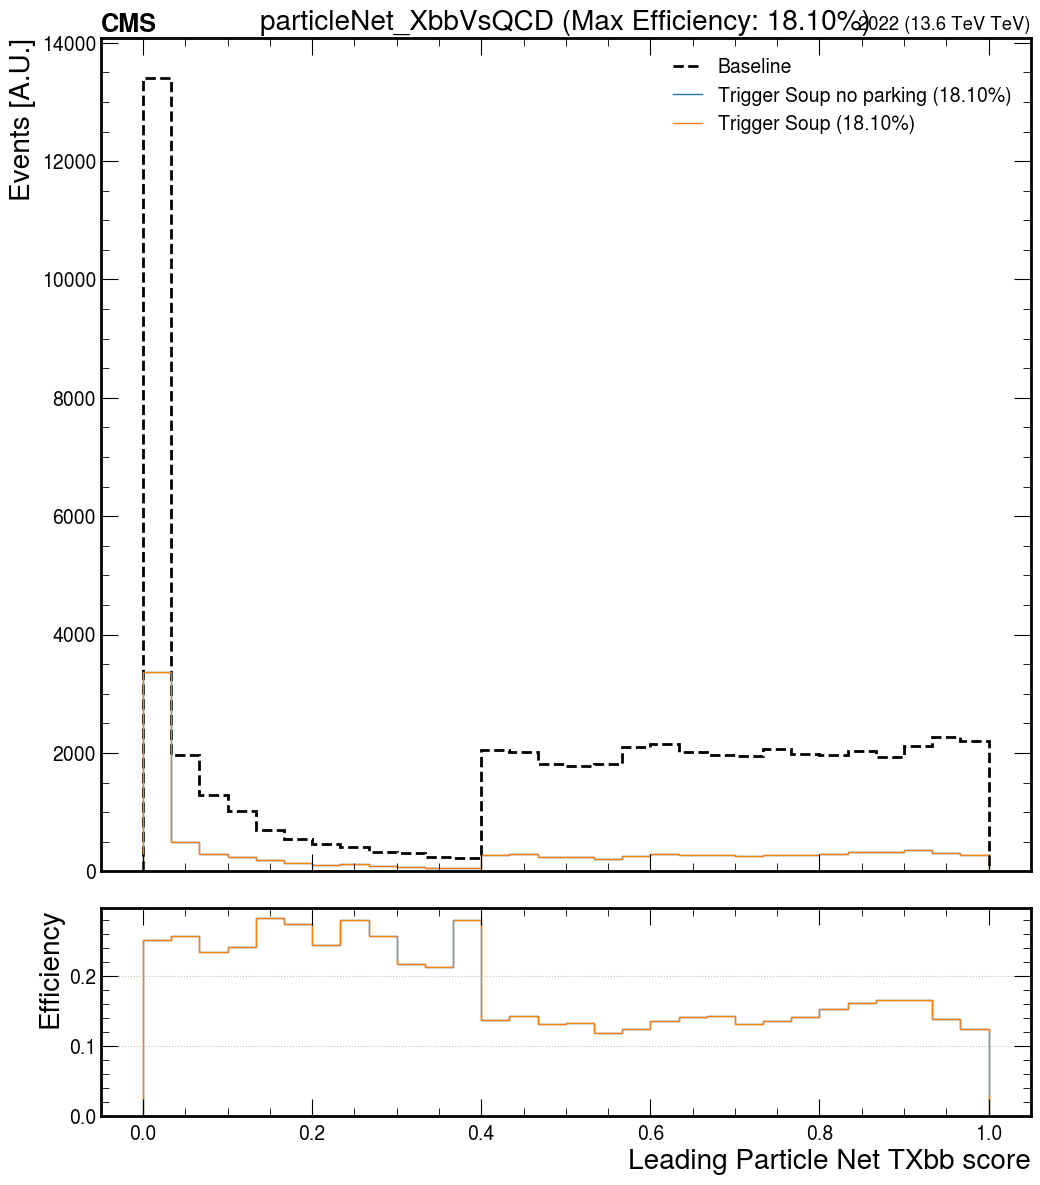

In [5]:
for year in ['2023', '2023BPix', '2022EE', '2022']:
# for year in ['2022', '2022EE', '2023', '2023BPix']:
# for year in ['2022']:
# for year in ['2023', '2023BPix']:
    print(f'Processing period {year}')
    all_triggers = trigger_dict_periods[year]
    no_parking = all_triggers[:3] # differs from all_triggers only for 2023 and 2023BPix
    file_dict = file_dict_periods[year]
    outputs = {key_prod: [] for key_prod in file_dict.keys()}
    for prod_mode, file_name in file_dict.items():
        print("Currently processing production mode", prod_mode)
        with open(f'/srv/{year}/{year}_{prod_mode}.json', 'r') as file:
            data = json.load(file)
        samples = data[file_name]
        samples = samples[:20]
        iterative_run = processor.Runner(
                executor = processor.FuturesExecutor(compression=None, workers=2),
                schema=NanoAODSchema,
                skipbadfiles=True,  # Skip files that fail to open
                savemetrics=True,   # Save metrics to understand where failures occur
        )
        fileset = {"Dataset" : samples}
        group_1_tag = 'Trigger Soup no parking'
        group_2_tag = 'Trigger Soup'
        out = iterative_run(
            fileset,
            treename="Events",
            processor_instance=ParkingSoupProcessor(no_parking, all_triggers, trig_vars_data, group_1_tag, group_2_tag, baseline_key='VBF'),
        )
        output = out[0]
        outputs[prod_mode] = output
    
        save_dir = f"/srv/figures/Data/{year}/{prod_mode}"
        plot_1d_trigger_soup_cms(output, trig_vars_data, save_dir=save_dir, year=year, data=True, show_img=False)
        